In [1]:
!pip install transformers -q
!pip install sentencepiece -q

In [2]:
import datetime
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
from torch.utils.data import Dataset, DataLoader, IterableDataset

from transformers import AutoModel, AutoTokenizer, AutoConfig

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from IPython.display import display, HTML

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
from model_bank import *

In [5]:
def get_data_loader(dataset, batch_size=16, random_seed=42):
    g = torch.Generator()
    g.manual_seed(random_seed)
    return DataLoader(dataset, batch_size=batch_size, generator=g)

In [6]:
class FusionDataset(IterableDataset):
    def __init__(self, sequences, masks, features, labels, fsize=(40,9601)):
        self.sequences = sequences
        self.masks = masks
        self.labels = labels
        self.features = features
        self.fsize = fsize
    
    def __get__(self,index):
      if self.features[index].shape[1] < self.fsize[1]:
        self.features[index] = torch.hstack((self.features[index],
                                             torch.zeros(self.fsize[0],self.fsize[1]-self.features[index].shape[1])))
      return self.features[index].reshape((1,)+self.features[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.sequences[index], self.masks[index], self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.sequences[index], self.masks[index], self.__get__(index), self.labels[index]

    def get_data_loader(self, batch_size=16, random_seed=42):
        return get_data_loader(self, batch_size, random_seed)
    
    @staticmethod
    def _prepare_data_(data, sequences, masks, ids, target='RagamCode', audfeature='mel_spec', fsize=(40,9601)):
      lbls = torch.tensor([data[target].iloc[x] for x in ids])
      features = [data[audfeature].iloc[x] for x in ids] # aud feature is already tensor
      return FusionDataset(sequences[ids], masks[ids], features, lbls, fsize)

    @staticmethod
    def prepare_data(data, sequences, masks, train_ids, test_ids, target='RagamCode', audfeature='mel_spec', fsize=(40,9601)):
      return FusionDataset._prepare_data_(data, sequences, masks, train_ids, target, audfeature, fsize), FusionDataset._prepare_data_(data, sequences, masks, train_ids, target, audfeature, fsize)

In [7]:
class FusionModel(nn.Module):
  def __init__(self, transformer, n_labels=2, dropout=0.1):
    super().__init__()
    self.VEC_SIZE = 768
    self.transformer = transformer
    self.aud_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,1), padding='same'),            
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(2,2), padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=4),
            nn.Flatten()
        )
    self.fusion = nn.Sequential(nn.Linear(48000+self.VEC_SIZE, 1000),
                                nn.ReLU(),
                                nn.Dropout(dropout),
                                nn.Linear(1000, n_labels))
  def forward(self, sequence, mask, aud):
    _, cls = self.transformer(sequence, attention_mask=mask, return_dict=False)
    aud = self.aud_layer(aud)
    x = torch.cat((aud, cls),1)
    return self.fusion(x)

In [8]:
def get_devices():
    if torch.cuda.is_available():
        gpu = torch.device("cuda")
    else:
        gpu = torch.device("cpu")
    cpu = torch.device("cpu")
    return gpu, cpu
gpu, cpu = get_devices()

In [9]:
def get_loss_function(balance_classes, labels, run_on, loss_fcn=nn.CrossEntropyLoss):
    if balance_classes:
        class_wts = compute_class_weight(class_weight='balanced',
                                         classes=np.unique(labels),
                                         y=labels
                                         )
        print(f'Class Weights : {class_wts}')
        # convert class weights to tensor
        weights = torch.tensor(class_wts, dtype=torch.float)
        weights = weights.to(run_on)
        # loss function
        loss_fcn = loss_fcn(weight=weights)
    else:
        loss_fcn = loss_fcn()
    return loss_fcn

In [10]:
def update_best_result(best_scores, valid_loss, train_labels, train_predictions, validation_labels,
                       validation_predictions, test_labels, test_predictions,
                       model=None, model_file_name=f'saved_weights_Fold_0.pt'):
    if valid_loss < best_scores['valid_loss']:
        best_scores['valid_loss'] = valid_loss
        best_scores['train_predictions'] = train_predictions
        best_scores['validation_predictions'] = validation_predictions
        best_scores['test_predictions'] = test_predictions
        best_scores['train_labels'] = train_labels
        best_scores['validation_labels'] = validation_labels
        best_scores['test_labels'] = test_labels
        if model:
            torch.save(model.state_dict(), model_file_name)
    return best_scores


def update_results_dict(results, train_labels, train_predictions, validation_labels, validation_predictions,
                        test_lbls, test_preds,
                        average='micro', pos_label=1):
    results['train_precision'].append(precision_score(train_labels, train_predictions, average=average))
    results['train_recall'].append(recall_score(train_labels, train_predictions, average=average))
    results['train_f1'].append(f1_score(train_labels, train_predictions, average=average))
    results['validation_precision'].append(precision_score(validation_labels, validation_predictions, average=average))
    results['validation_recall'].append(recall_score(validation_labels, validation_predictions, average=average))
    results['validation_f1'].append(
        f1_score(validation_labels, validation_predictions, average=average))
    results['test_precision'].append(precision_score(test_lbls, test_preds, average=average))
    results['test_recall'].append(recall_score(test_lbls, test_preds, average=average))
    results['test_f1'].append(
        f1_score(test_lbls, test_preds, average=average))
    results['train_labels'].append([train_labels])
    results['validation_labels'].append([validation_labels])
    results['test_labels'].append([test_lbls])
    results['train_predictions'].append([train_predictions])
    results['validation_predictions'].append([validation_predictions])
    results['test_predictions'].append([test_preds])
    return results

In [11]:
def run_model(model, dataset, loss_fcn, optimizer, is_training, run_on, clip_at=None, lstm_model=False, report_at=20):
    if is_training:
        model.train()
    else:
        model.eval()
    total_loss, total_accuracy, model_predictions, model_labels, aud_data = 0, 0, [], [], None
    for step, batch in enumerate(dataset):
        # push the batch to gpu
        batch = [r.to(run_on) for r in batch]
        sequences, masks, features, labels = batch
        if is_training:
            for o in optimizer:
                o.zero_grad()
            model.zero_grad()
            predictions = model(sequences, masks, features)
        else:
            with torch.no_grad(): 
              predictions = model(sequences, masks, features)
        # compute the loss between actual and predicted values
        loss = loss_fcn(predictions, labels)
        predictions = predictions.detach().cpu().numpy()
        total_loss = total_loss + loss.item()
        if is_training:
            loss.backward()  # backward pass to calculate the gradients
            if clip_at:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_at)
            # update parameters
            for o in optimizer:
                o.step()
        # append the model predictions
        model_predictions.append(predictions)
        model_labels.append(labels.detach().cpu().numpy())
        del batch
    # compute the training loss of the epoch
    avg_loss = total_loss / len(dataset)
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    model_predictions = np.concatenate(model_predictions, axis=0)
    model_labels = np.concatenate(model_labels, axis=0)
    # returns the loss and predictions
    model_predictions = np.argmax(model_predictions, axis=1)
    return avg_loss, model_predictions, model_labels

In [12]:
def plot_results(results, model_name):
    fig = plt.figure(figsize=[20, 10])
    epochs = len(results[0]['train_precision'])
    x_label = f'{len(results)} Fold and {epochs} Epochs'

    def subplot_routine(key1, key2, title, loss=False, key3=None):
        plt.plot([x for k in results for x in results[k][key1]])
        plt.plot([x for k in results for x in results[k][key2]])
        if key3:
          plt.plot([x for k in results for x in results[k][key3]])
        plt.grid()
        plt.xlabel(x_label)
        if key3:
          plt.legend([f'{x} {title}' for x in ['Train', 'Val','Test']])
        else:
          plt.legend([f'{x} {title}' for x in ['Train', 'Val']])
        if not loss:
            plt.ylim([0, 1.1])
        else:
            b, t = plt.ylim()
            plt.ylim(np.floor(b), np.ceil(t))

    plt.subplot(2,1,1)
    subplot_routine('train_losses', 'validation_losses', 'Losses', True)
    plt.subplot(2,1,2)
    subplot_routine('train_f1', 'validation_f1', 'F1', key3='test_f1')
    plt.suptitle(f'Metrics for {model_name}')
    plt.tight_layout()
    plt.show()

In [13]:
def results_to_df(results):
    p = pd.DataFrame(results[0])
    for i in range(1, len(results)):
        p = pd.concat([p, pd.DataFrame(results[i])], axis=0)
    p.sort_values(by=['validation_f1', 'train_f1'], ascending=False, inplace=True)
    return p

In [14]:
def load_tx_model(rootpath):
  return AutoModel.from_pretrained(os.path.join(rootpath,'pytorch_model.bin'), local_files_only=True,
                                  config=AutoConfig.from_pretrained(os.path.join(rootpath,'config.json')))

In [15]:
def predict_test_data(model, chkpoint, test_data, gpu, feature='mel_spec', target='RagamCode'):
  txt = list(test_data.apply(lambda x: x.Lyric, axis=1))
  sequences, masks = get_seq_masks(chkpoint, txt)
  model = model.to(gpu)
  ds = FusionDataset(sequences, masks, test_data[feature].tolist(), test_data[target].tolist())
  model.eval()
  preds, truth = [], []
  for step, batch in enumerate(ds.get_data_loader(16)):
    batch = [r.to(gpu) for r in batch]
    sequences, masks, features, labels = batch
    with torch.no_grad():
      preds_batch = model(sequences, masks, features)
    preds_batch = preds_batch.detach().cpu().numpy()
    preds.append(preds_batch)
    truth.append(labels.detach().cpu().numpy())
    del batch
  preds = np.concatenate(preds, axis=0)
  truth = np.concatenate(truth, axis=0)
  preds = np.argmax(preds, axis=1)
  return preds, truth

In [16]:
def train_model(data, test_data, sequences, masks, rootpath, gpu, chkpoint, **kwargs):
    start_time = datetime.datetime.now()

    n_labels = kwargs['n_labels']
    title = kwargs['title']
    random_seed = kwargs['random_seed'] if 'random_seed' in kwargs else 42
    report = kwargs['report'] if 'report' in kwargs else 20
    lstm = kwargs['lstm'] if 'lstm' in kwargs else False
    lr = kwargs['lr'] if 'lr' in kwargs else 1e-4
    clip_at = kwargs['clip_at'] if 'clip_at' in kwargs else None
    k_folds = kwargs['k_folds'] if 'k_folds' in kwargs else 5
    balance_classes = kwargs['balance_classes'] if 'balance_classes' in kwargs else True
    dropout = kwargs['dropout'] if 'dropout' in kwargs else 0.1
    plot = kwargs['plot'] if 'plot' in kwargs else True
    epochs = kwargs['epochs'] if 'epochs' in kwargs else 5
    mdlargs = kwargs['mdlargs'] if 'mdlargs' in kwargs else {}
    feature = kwargs['feature'] if 'feature' in kwargs else ['mfcc_mean']
    target = kwargs['target'] if 'target' in kwargs else 'RagamCode'
    fsize = kwargs['fsize'] if 'fsize' in kwargs else (40,9601)
    loss_fcn = kwargs['loss_fcn'] if 'loss_fcn' in kwargs else None
    model_name = kwargs['model_name'] if 'model_name' in kwargs else 'model_state.pt'
    batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else 32

    torch.manual_seed(random_seed)
    k_fold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=random_seed)
    results = {x: {} for x in range(k_folds)}
    ovl_best_scores = {'valid_loss': float('inf'),
                       'train_predictions': [],
                       'validation_predictions': [],
                       'train_labels': [],
                       'validation_labels': []
                       }
    for fold, (train_ids, validation_ids) in enumerate(k_fold.split(data[feature], data[target])):
        print(f'FOLD {fold + 1} \n Data Sizes (Train/Validation) : {len(train_ids)}/{len(validation_ids)}')
        fold_start = datetime.datetime.now()
        # empty lists to store training and validation loss of each epoch
        train_losses, valid_losses = [], []
        best_scores = {'valid_loss': float('inf'),
                       'train_predictions': [],
                       'validation_predictions': [],
                       'test_predictions' :[],
                       'train_labels': [],
                       'validation_labels': [],
                       'test_labels' : []
                       }
        # for each epoch
        results[fold] = {
            'train_f1': [],
            'validation_f1': [],
            'test_f1' : [],
            'train_precision': [],
            'validation_precision': [],
            'test_precision' :[],
            'train_recall': [],
            'validation_recall': [],
            'test_recall' :[],
            'train_labels': [],
            'validation_labels': [],
            'test_labels' : [],
            'train_predictions': [],
            'validation_predictions': [],
            'test_predictions':[]
        }
        train_data, validation_data = FusionDataset.prepare_data(data, sequences, masks, train_ids, validation_ids, target, feature, fsize)
        transformer = load_tx_model(rootpath)
        model = kwargs['model'](transformer, dropout=dropout, **mdlargs)
        model.to(gpu)
        if not loss_fcn:
            loss_fcn = get_loss_function(balance_classes, data[target].tolist(), gpu, nn.CrossEntropyLoss)
        # define the optimizer
        optimizer = [torch.optim.Adam(model.parameters(), lr=lr)]
        lr_schedulers = [ReduceLROnPlateau(optimizer[0], patience=3, factor=0.1, threshold=1e-9, mode='min'),
                         ExponentialLR(optimizer[0], gamma=0.9)]
        for epoch in range(epochs):
            e_start = datetime.datetime.now()
            # train model
            train_loss, train_predictions, train_labels = run_model(model,
                                                                    train_data.get_data_loader(batch_size=batch_size),
                                                                    loss_fcn, optimizer, run_on=gpu,
                                                                    is_training=True, clip_at=clip_at,
                                                                    lstm_model=lstm, report_at=report)
            # evaluate model
            valid_loss, validation_predictions, validation_labels = run_model(model,
                                                                              validation_data.get_data_loader(
                                                                              batch_size=batch_size),
                                                                              loss_fcn, optimizer, run_on=gpu,
                                                                              is_training=False, clip_at=clip_at,
                                                                              lstm_model=lstm, report_at=report)
            #for lr_scheduler in lr_schedulers:
                #lr_scheduler.step(valid_loss)
            torch.cuda.empty_cache()
            # save the best model
            test_preds, test_lbls = predict_test_data(model, chkpoint, test_data, gpu, feature=feature, target=target)
            best_scores = update_best_result(best_scores,
                                             valid_loss,
                                             train_labels, train_predictions,
                                             validation_labels, validation_predictions,
                                             test_lbls, test_preds)
            ovl_best_scores = update_best_result(ovl_best_scores,
                                                 valid_loss,
                                                 train_labels, train_predictions,
                                                 validation_labels, validation_predictions,
                                                 test_lbls, test_preds,
                                                 model=model,
                                                 model_file_name=f'{model_name}')
            # append training and validation loss
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            results[fold] = update_results_dict(results[fold],
                                                train_labels, train_predictions,
                                                validation_labels, validation_predictions,
                                                test_lbls, test_preds)
            e_end = datetime.datetime.now()
            print(
                f'Epoch {epoch + 1}/{epochs} : Training Loss: {train_loss:.3f} / Validation Loss : {valid_loss:.3f} [Time : {(e_end - e_start).total_seconds()} seconds]')
        print('*** Confusion Matrix - Training ***')
        print(confusion_matrix(best_scores['train_labels'], best_scores['train_predictions']))
        print('*** Confusion Matrix - Validation ***')
        print(confusion_matrix(best_scores['validation_labels'], best_scores['validation_predictions']))
        results[fold]['train_losses'] = train_losses
        results[fold]['validation_losses'] = valid_losses
        print(f'Fold {fold + 1} : {(datetime.datetime.now() - fold_start).total_seconds()} seconds')
        # To ensure CUDA is not overloaded
        del model        
    end_time = datetime.datetime.now()
    print(f'Overall Time : {(end_time - start_time).total_seconds()} seconds')
    print('*** Confusion Matrix - Training ***')
    print(confusion_matrix(ovl_best_scores['train_labels'], ovl_best_scores['train_predictions']))
    print('*** Confusion Matrix - Validation ***')
    print(confusion_matrix(ovl_best_scores['validation_labels'], ovl_best_scores['validation_predictions']))

    if plot:
        plot_results(results, title)
    return results

In [17]:
def ovr_train_model(data, test_data, sequences, masks, rootpath, gpu, chkpoint, title, labels, label_classes, 
                    lbl_encoder=None, target='RagamCode', feature='mfcc', lr=5e-3,
                    lstm=False, dropout=0.1, epochs=15, n_folds=2, nindex_factor=None):
  results = {}
  models = {}
  for i in labels:
    # Create new data    
    nsamples = data[data[target]==i].shape[0]
    if nsamples == 0:
      continue
    if lbl_encoder: 
      lbl = lbl_encoder.inverse_transform([i])[0]
      print(f'Training for {lbl} with {nsamples} positive samples')
    else:
      lbl = i
    
    if nindex_factor:
      np.random.seed(42)
      ndata = pd.DataFrame()
      ndata[target] = data.apply(lambda x:1 if x[target] == i else 0, axis=1)
      ndata[feature] = data[feature]
      pindex = ndata[ndata[target]==1].index
      nindex = ndata[ndata[target]==0].index
      index = np.random.choice(pindex,pindex.shape[0]).tolist() + np.random.choice(nindex,nindex_factor*pindex.shape[0]).tolist()
      tdata = ndata.loc[index]
    else:
      tdata = pd.DataFrame()
      tdata[target] = data.apply(lambda x:1 if x[target] == i else 0, axis=1)
      tdata[feature] = data[feature]

    models[lbl] = f'{lbl}.pt'
    
    results[i] = train_model(tdata, test_data, sequences, masks, rootpath, gpu, chkpoint,
                                  **{'n_labels' : 2,
                                   'report' : 50,
                                   'lstm' : lstm,
                                   'lr' : lr,
                                   'clip_at' : None,
                                   'k_folds' : n_folds,
                                   'balance_classes' : True,
                                   'dropout' : dropout,
                                   'title' : f'{title} - {lbl}',
                                   'plot' : True,
                                   'epochs' : epochs,
                                   'model' : FusionModel,
                                   'feature' : feature,
                                   'target' : target,
                                   'model_name' : models[lbl]},
                             mdlargs={'n_labels':2})
    tmp = results_to_df(results[i])
    res_tbl_keys = ['train_f1','validation_f1','test_f1','train_precision','validation_precision','test_precision','train_recall','validation_recall','test_recall']
    display(HTML(tmp[res_tbl_keys].to_html().replace("\\n", "<br>")))    
  return results, models

In [18]:
data = pd.read_pickle('/content/drive/MyDrive/mp3_mels.pkl')
labels = torch.tensor(data['RagamCode'].tolist())
n_labels = len(data['RagamCode'].unique())
res_tbl_keys = ['train_f1','validation_f1','test_f1','train_precision','validation_precision','test_precision','train_recall','validation_recall','test_recall']

In [19]:
# Held out 10% Data
from sklearn.model_selection import train_test_split
Y1, Y2 = train_test_split(data['RagamCode'], test_size=0.1, random_state=42)

test_data = data.loc[Y2.index]
data = data.loc[Y1.index]

txt = list(data.apply(lambda x: x.Lyric, axis=1))

In [20]:
def create_results_table(overall, le, n_results=1, display_results=True, display_train=True):
    df = pd.DataFrame(
        columns=['Raga', 'train_confusion', 'validation_confusion'] + list(overall[list(overall.keys())[0]][1].keys()))
    idx = 0
    for item in overall:
        # Get top "n_results"
        tmp = results_to_df(overall[item]).head(n_results)
        for _ in range(n_results):
            df.loc[idx, 'Raga'] = le.inverse_transform([item])[0]
            for i in tmp.columns:
                df.loc[idx, i] = tmp[i].tolist()[_]
            t = confusion_matrix(df.loc[idx, 'train_labels'][0], df.loc[idx, 'train_predictions'][0])
            df.loc[idx, 'train_confusion'] = str(t[0]) + '\n' + str(t[1])
            t = confusion_matrix(df.loc[idx, 'validation_labels'][0], df.loc[idx, 'validation_predictions'][0])
            df.loc[idx, 'validation_confusion'] = str(t[0]) + '\n' + str(t[1])
            idx = idx + 1
    df.index = df['Raga']
    if display_results:
        if display_train:
            cols_to_display = ['Raga', 'train_confusion', 'validation_confusion', 'train_f1', 'validation_f1',
                               'train_precision', 'validation_precision', 'train_recall', 'validation_recall']
        else:
            cols_to_display = ['Raga', 'validation_confusion',
                               'validation_f1', 'validation_precision', 'validation_recall']
        display(HTML(df[cols_to_display].to_html().replace("\\n", "<br>")))
    return df

In [21]:
def bar_plot(df, metric, title=None, fig_size=None):
    if fig_size is None:
        fig_size = [20, 5]
    if title is None:
        title = f'{metric} values'
    cols = [f'train_{metric}', f'validation_{metric}']
    df[cols].plot.bar(figsize=fig_size, grid=True)
    plt.title(title)
    plt.legend(['Train', 'Validation'])
    plt.xticks(rotation=45)
    plt.show()

In [34]:
def predict_probabilities(mdl, spec, seq, mask):
    if spec.shape[1] < 9601:
        spec = torch.hstack((spec, torch.zeros(40, 9601 - spec.shape[1])))
    spec = spec.reshape((1, 1, 40, 9601))
    mdl.eval()
    with torch.no_grad():
        r = softmax(mdl(spec, seq, mask).detach().numpy())
    return [r[0][0], r[0][1]]

In [37]:
def predict_ovr(models,test_data,rootpath,chkpoint,feature='mel_spec',average='micro'):
  test_preds = pd.DataFrame(columns=['Original','Predicted','Confidence','Original Confidence'])
  idx = 0
  transformer = load_tx_model(rootpath)  
  model_banks = {k: FusionModel(transformer) for k in models}
  txt = list(test_data.apply(lambda x: x.Lyric, axis=1))
  sequences, attention_masks = get_seq_masks(chkpoint,txt)
  for k in model_banks:
    model_banks[k].load_state_dict(torch.load(models[k]))
  for i in test_data.index:
      test_preds.loc[idx, 'Original'] = test_data.loc[i, 'Ragam']
      test_preds.loc[idx, 'Predicted'], test_preds.loc[idx, 'Confidence'], test_preds.loc[idx, 'Original Confidence'] = get_raga_name(predict(model_banks,test_data.loc[i,feature], sequences[i], attention_masks[i]),
                                                                                                                                  original=test_preds.loc[idx,'Original'])
      idx = idx + 1
  test_preds['is_true'] = test_preds.apply(lambda x:x['Original']==x['Predicted'], axis=1)
  print('Median Confidence Levels')
  for g in test_preds.groupby('Predicted'):
    print(g[0], g[1]['Confidence'].median())
  print('Correctly classified Ragas')
  print(test_preds[test_preds['is_true']]['Original'].value_counts())
  print(f'With {average} average')
  print('F1 Score : ', f1_score(test_preds['Original'],test_preds['Predicted'],average=average))
  print('Precision : ', precision_score(test_preds['Original'],test_preds['Predicted'],average=average))
  print('Recall : ', recall_score(test_preds['Original'],test_preds['Predicted'],average=average))

  plt.figure(figsize=[30,8])
  plt.scatter(test_preds.index, test_preds['is_true'],facecolor='g')
  plt.bar(test_preds[test_preds['is_true']].index,test_preds[test_preds['is_true']]['Confidence'])
  plt.bar(test_preds[test_preds['is_true']!=True].index,test_preds[test_preds['is_true']!=True]['Confidence'],facecolor='r')
  plt.grid(True)
  plt.legend(['Correct Classification','Correct Classification Confidence','Misclassification Confidence'],loc='upper right')
  plt.ylim([-0.2,1.4])
  plt.title('Confidence Levels')
  plt.show()
  return test_preds

# Fusion with IndicBERT and MEL Spectrogram

In [23]:
def get_seq_masks(chkpoint, txt):
  tokenizer = AutoTokenizer.from_pretrained(chkpoint)
  all_tokens = tokenizer.batch_encode_plus(txt, max_length=96,
                                             padding='longest',
                                             truncation=True,
                                             return_token_type_ids=False)
  sequences = torch.tensor(all_tokens['input_ids'])
  attention_masks = torch.tensor(all_tokens['attention_mask'])
  return sequences, attention_masks

Training for ఆహిరి with 41 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 196/50


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.735 / Validation Loss : 0.563 [Time : 13.866976 seconds]
Epoch 2/10 : Training Loss: 0.490 / Validation Loss : 0.462 [Time : 13.912738 seconds]
Epoch 3/10 : Training Loss: 0.421 / Validation Loss : 0.420 [Time : 13.963345 seconds]
Epoch 4/10 : Training Loss: 0.399 / Validation Loss : 0.407 [Time : 13.924211 seconds]
Epoch 5/10 : Training Loss: 0.398 / Validation Loss : 0.404 [Time : 13.89236 seconds]
Epoch 6/10 : Training Loss: 0.402 / Validation Loss : 0.403 [Time : 15.24996 seconds]
Epoch 7/10 : Training Loss: 0.407 / Validation Loss : 0.402 [Time : 13.975752 seconds]
Epoch 8/10 : Training Loss: 0.405 / Validation Loss : 0.401 [Time : 13.96444 seconds]
Epoch 9/10 : Training Loss: 0.406 / Validation Loss : 0.399 [Time : 13.993262 seconds]
Epoch 10/10 : Training Loss: 0.403 / Validation Loss : 0.397 [Time : 13.903432 seconds]
*** Confusion Matrix - Training ***
[[164   0]
 [ 32   0]]
*** Confusion Matrix - Validation ***
[[164   0

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 5.184 / Validation Loss : 6.532 [Time : 13.058564 seconds]
Epoch 2/10 : Training Loss: 6.476 / Validation Loss : 4.664 [Time : 13.008406 seconds]
Epoch 3/10 : Training Loss: 4.560 / Validation Loss : 0.793 [Time : 13.040212 seconds]
Epoch 4/10 : Training Loss: 0.851 / Validation Loss : 0.147 [Time : 14.075502 seconds]
Epoch 5/10 : Training Loss: 0.354 / Validation Loss : 0.056 [Time : 13.938127 seconds]
Epoch 6/10 : Training Loss: 0.031 / Validation Loss : 0.072 [Time : 13.024556 seconds]
Epoch 7/10 : Training Loss: 0.076 / Validation Loss : 0.078 [Time : 13.019389 seconds]
Epoch 8/10 : Training Loss: 0.078 / Validation Loss : 0.055 [Time : 13.834473 seconds]
Epoch 9/10 : Training Loss: 0.062 / Validation Loss : 0.029 [Time : 13.954846 seconds]
Epoch 10/10 : Training Loss: 0.029 / Validation Loss : 0.017 [Time : 13.99069 seconds]
*** Confusion Matrix - Training ***
[[164   0]
 [  4  29]]
*** Confusion Matrix - Validation ***
[[164   0]
 [  1  32]]
Fold 2 : 1

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.751 / Validation Loss : 0.482 [Time : 13.045997 seconds]
Epoch 2/10 : Training Loss: 0.408 / Validation Loss : 0.434 [Time : 13.001176 seconds]
Epoch 3/10 : Training Loss: 0.418 / Validation Loss : 0.437 [Time : 12.982633 seconds]
Epoch 4/10 : Training Loss: 0.439 / Validation Loss : 0.438 [Time : 12.962025 seconds]
Epoch 5/10 : Training Loss: 0.445 / Validation Loss : 0.434 [Time : 13.028693 seconds]
Epoch 6/10 : Training Loss: 0.444 / Validation Loss : 0.428 [Time : 13.049389 seconds]
Epoch 7/10 : Training Loss: 0.439 / Validation Loss : 0.423 [Time : 12.999925 seconds]
Epoch 8/10 : Training Loss: 0.433 / Validation Loss : 0.419 [Time : 12.940672 seconds]
Epoch 9/10 : Training Loss: 0.426 / Validation Loss : 0.416 [Time : 13.0345 seconds]
Epoch 10/10 : Training Loss: 0.423 / Validation Loss : 0.413 [Time : 13.138737 seconds]
*** Confusion Matrix - Training ***
[[164   0]
 [ 33   0]]
*** Confusion Matrix - Validation ***
[[164   0]
 [ 33   0]]
Fold 3 : 13

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 4.027 / Validation Loss : 3.645 [Time : 13.001747 seconds]
Epoch 2/10 : Training Loss: 3.581 / Validation Loss : 3.238 [Time : 13.040132 seconds]
Epoch 3/10 : Training Loss: 3.268 / Validation Loss : 1.326 [Time : 13.04153 seconds]
Epoch 4/10 : Training Loss: 1.364 / Validation Loss : 0.178 [Time : 12.994066 seconds]
Epoch 5/10 : Training Loss: 0.418 / Validation Loss : 0.242 [Time : 13.024484 seconds]
Epoch 6/10 : Training Loss: 0.081 / Validation Loss : 0.067 [Time : 12.955982 seconds]
Epoch 7/10 : Training Loss: 0.059 / Validation Loss : 0.071 [Time : 13.029012 seconds]
Epoch 8/10 : Training Loss: 0.071 / Validation Loss : 0.060 [Time : 12.951567 seconds]
Epoch 9/10 : Training Loss: 0.065 / Validation Loss : 0.042 [Time : 12.978454 seconds]
Epoch 10/10 : Training Loss: 0.046 / Validation Loss : 0.032 [Time : 13.001552 seconds]
*** Confusion Matrix - Training ***
[[164   0]
 [  2  31]]
*** Confusion Matrix - Validation ***
[[164   0]
 [  2  31]]
Fold 4 : 1

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.796 / Validation Loss : 0.444 [Time : 13.034773 seconds]
Epoch 2/10 : Training Loss: 0.400 / Validation Loss : 0.469 [Time : 13.016567 seconds]
Epoch 3/10 : Training Loss: 0.472 / Validation Loss : 0.471 [Time : 13.014717 seconds]
Epoch 4/10 : Training Loss: 0.488 / Validation Loss : 0.456 [Time : 12.968461 seconds]
Epoch 5/10 : Training Loss: 0.473 / Validation Loss : 0.443 [Time : 13.011916 seconds]
Epoch 6/10 : Training Loss: 0.463 / Validation Loss : 0.438 [Time : 12.921683 seconds]
Epoch 7/10 : Training Loss: 0.455 / Validation Loss : 0.435 [Time : 12.94297 seconds]
Epoch 8/10 : Training Loss: 0.442 / Validation Loss : 0.433 [Time : 12.964548 seconds]
Epoch 9/10 : Training Loss: 0.442 / Validation Loss : 0.430 [Time : 12.964985 seconds]
Epoch 10/10 : Training Loss: 0.439 / Validation Loss : 0.428 [Time : 12.969833 seconds]
*** Confusion Matrix - Training ***
[[164   0]
 [ 33   0]]
*** Confusion Matrix - Validation ***
[[164   0]
 [ 33   0]]
Fold 5 : 1

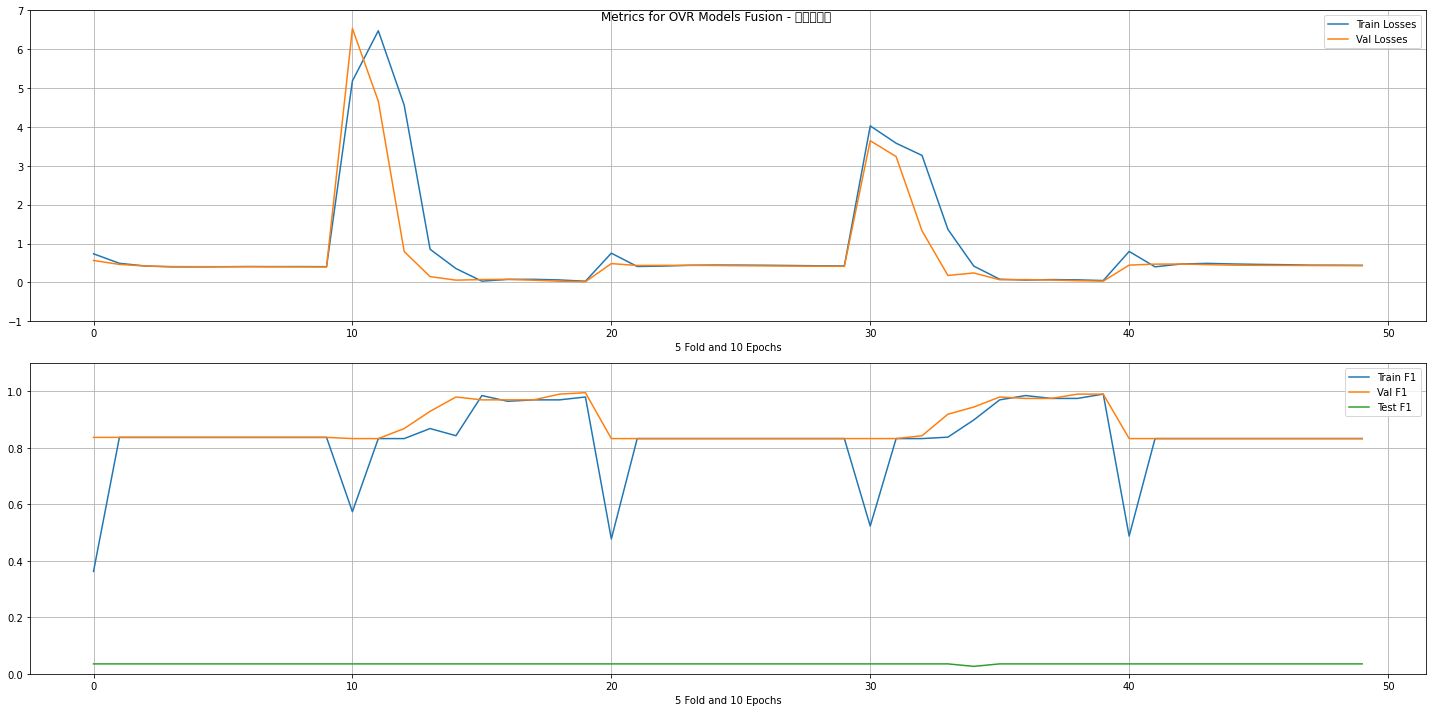

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
9,0.979695,0.994924,0.035088,0.979695,0.994924,0.035088,0.979695,0.994924,0.035088
9,0.989848,0.989848,0.035088,0.989848,0.989848,0.035088,0.989848,0.989848,0.035088
8,0.974619,0.989848,0.035088,0.974619,0.989848,0.035088,0.974619,0.989848,0.035088
8,0.969543,0.989848,0.035088,0.969543,0.989848,0.035088,0.969543,0.989848,0.035088
5,0.969543,0.979695,0.035088,0.969543,0.979695,0.035088,0.969543,0.979695,0.035088
4,0.842640,0.979695,0.035088,0.842640,0.979695,0.035088,0.842640,0.979695,0.035088
6,0.984772,0.974619,0.035088,0.984772,0.974619,0.035088,0.984772,0.974619,0.035088
7,0.974619,0.974619,0.035088,0.974619,0.974619,0.035088,0.974619,0.974619,0.035088
5,0.984772,0.969543,0.035088,0.984772,0.969543,0.035088,0.984772,0.969543,0.035088
7,0.969543,0.969543,0.035088,0.969543,0.969543,0.035088,0.969543,0.969543,0.035088


Training for కన్నడగౌళ with 15 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 72/18


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.811 / Validation Loss : 0.704 [Time : 12.152468 seconds]
Epoch 2/10 : Training Loss: 0.651 / Validation Loss : 0.624 [Time : 12.106823 seconds]
Epoch 3/10 : Training Loss: 0.592 / Validation Loss : 0.589 [Time : 12.053455 seconds]
Epoch 4/10 : Training Loss: 0.569 / Validation Loss : 0.572 [Time : 12.070762 seconds]
Epoch 5/10 : Training Loss: 0.563 / Validation Loss : 0.564 [Time : 11.847439 seconds]
Epoch 6/10 : Training Loss: 0.554 / Validation Loss : 0.561 [Time : 11.884273 seconds]
Epoch 7/10 : Training Loss: 0.555 / Validation Loss : 0.561 [Time : 11.780786 seconds]
Epoch 8/10 : Training Loss: 0.555 / Validation Loss : 0.561 [Time : 11.130769 seconds]
Epoch 9/10 : Training Loss: 0.563 / Validation Loss : 0.561 [Time : 11.010713 seconds]
Epoch 10/10 : Training Loss: 0.561 / Validation Loss : 0.561 [Time : 10.998522 seconds]
*** Confusion Matrix - Training ***
[[60  0]
 [12  0]]
*** Confusion Matrix - Validation ***
[[60  0]
 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 1.951 / Validation Loss : 1.567 [Time : 11.032183 seconds]
Epoch 2/10 : Training Loss: 1.793 / Validation Loss : 0.089 [Time : 11.978694 seconds]
Epoch 3/10 : Training Loss: 0.264 / Validation Loss : 0.007 [Time : 11.83962 seconds]
Epoch 4/10 : Training Loss: 0.011 / Validation Loss : 0.017 [Time : 10.958208 seconds]
Epoch 5/10 : Training Loss: 0.022 / Validation Loss : 0.026 [Time : 11.023015 seconds]
Epoch 6/10 : Training Loss: 0.028 / Validation Loss : 0.022 [Time : 10.954046 seconds]
Epoch 7/10 : Training Loss: 0.024 / Validation Loss : 0.013 [Time : 10.940928 seconds]
Epoch 8/10 : Training Loss: 0.015 / Validation Loss : 0.006 [Time : 11.836295 seconds]
Epoch 9/10 : Training Loss: 0.011 / Validation Loss : 0.003 [Time : 11.873237 seconds]
Epoch 10/10 : Training Loss: 0.003 / Validation Loss : 0.002 [Time : 11.920713 seconds]
*** Confusion Matrix - Training ***
[[60  0]
 [ 0 12]]
*** Confusion Matrix - Validation ***
[[60  0]
 [ 0 12]]
Fold 2 : 115.20242

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.904 / Validation Loss : 0.686 [Time : 10.962451 seconds]
Epoch 2/10 : Training Loss: 0.588 / Validation Loss : 0.577 [Time : 10.97819 seconds]
Epoch 3/10 : Training Loss: 0.543 / Validation Loss : 0.569 [Time : 10.968115 seconds]
Epoch 4/10 : Training Loss: 0.557 / Validation Loss : 0.575 [Time : 10.95475 seconds]
Epoch 5/10 : Training Loss: 0.572 / Validation Loss : 0.578 [Time : 11.004078 seconds]
Epoch 6/10 : Training Loss: 0.579 / Validation Loss : 0.576 [Time : 10.963908 seconds]
Epoch 7/10 : Training Loss: 0.579 / Validation Loss : 0.572 [Time : 10.995992 seconds]
Epoch 8/10 : Training Loss: 0.576 / Validation Loss : 0.566 [Time : 10.956195 seconds]
Epoch 9/10 : Training Loss: 0.571 / Validation Loss : 0.562 [Time : 10.991001 seconds]
Epoch 10/10 : Training Loss: 0.566 / Validation Loss : 0.558 [Time : 11.006297 seconds]
*** Confusion Matrix - Training ***
[[60  0]
 [12  0]]
*** Confusion Matrix - Validation ***
[[60  0]
 [12  0]]
Fold 3 : 110.647738

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.577 / Validation Loss : 0.612 [Time : 10.995955 seconds]
Epoch 2/10 : Training Loss: 0.688 / Validation Loss : 0.633 [Time : 11.112713 seconds]
Epoch 3/10 : Training Loss: 0.755 / Validation Loss : 0.062 [Time : 10.975401 seconds]
Epoch 4/10 : Training Loss: 0.085 / Validation Loss : 0.010 [Time : 10.95151 seconds]
Epoch 5/10 : Training Loss: 0.018 / Validation Loss : 0.024 [Time : 10.98663 seconds]
Epoch 6/10 : Training Loss: 0.040 / Validation Loss : 0.038 [Time : 10.987034 seconds]
Epoch 7/10 : Training Loss: 0.040 / Validation Loss : 0.034 [Time : 10.973379 seconds]
Epoch 8/10 : Training Loss: 0.033 / Validation Loss : 0.021 [Time : 10.994441 seconds]
Epoch 9/10 : Training Loss: 0.025 / Validation Loss : 0.010 [Time : 10.966884 seconds]
Epoch 10/10 : Training Loss: 0.013 / Validation Loss : 0.005 [Time : 11.113894 seconds]
*** Confusion Matrix - Training ***
[[60  0]
 [ 0 12]]
*** Confusion Matrix - Validation ***
[[60  0]
 [ 0 12]]
Fold 4 : 110.874886

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 1.091 / Validation Loss : 0.677 [Time : 10.979786 seconds]
Epoch 2/10 : Training Loss: 0.522 / Validation Loss : 0.562 [Time : 11.029593 seconds]
Epoch 3/10 : Training Loss: 0.527 / Validation Loss : 0.590 [Time : 11.046793 seconds]
Epoch 4/10 : Training Loss: 0.585 / Validation Loss : 0.602 [Time : 11.054404 seconds]
Epoch 5/10 : Training Loss: 0.602 / Validation Loss : 0.598 [Time : 11.03079 seconds]
Epoch 6/10 : Training Loss: 0.605 / Validation Loss : 0.585 [Time : 10.986172 seconds]
Epoch 7/10 : Training Loss: 0.598 / Validation Loss : 0.571 [Time : 10.937484 seconds]
Epoch 8/10 : Training Loss: 0.590 / Validation Loss : 0.562 [Time : 10.957024 seconds]
Epoch 9/10 : Training Loss: 0.575 / Validation Loss : 0.558 [Time : 10.955698 seconds]
Epoch 10/10 : Training Loss: 0.576 / Validation Loss : 0.558 [Time : 10.962479 seconds]
*** Confusion Matrix - Training ***
[[60  0]
 [12  0]]
*** Confusion Matrix - Validation ***
[[60  0]
 [12  0]]
Fold 5 : 110.77467

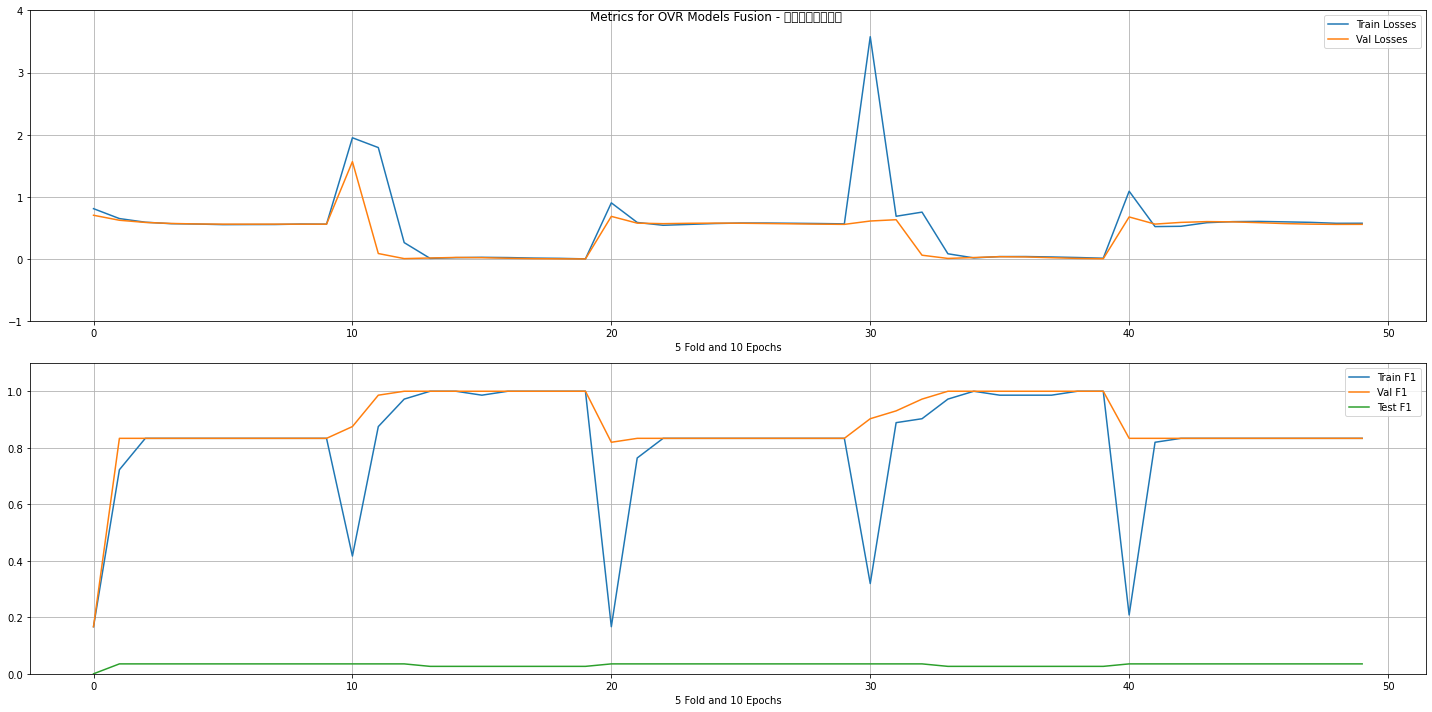

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
3,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
4,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
6,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
7,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
8,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
9,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
4,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
8,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
9,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
5,0.986111,1.000000,0.026316,0.986111,1.000000,0.026316,0.986111,1.000000,0.026316


Training for కాంబోది with 17 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 81/21


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.811 / Validation Loss : 0.708 [Time : 11.951092 seconds]
Epoch 2/10 : Training Loss: 0.657 / Validation Loss : 0.631 [Time : 12.121537 seconds]
Epoch 3/10 : Training Loss: 0.601 / Validation Loss : 0.597 [Time : 11.978848 seconds]
Epoch 4/10 : Training Loss: 0.579 / Validation Loss : 0.581 [Time : 11.970651 seconds]
Epoch 5/10 : Training Loss: 0.568 / Validation Loss : 0.574 [Time : 12.011599 seconds]
Epoch 6/10 : Training Loss: 0.565 / Validation Loss : 0.571 [Time : 11.958416 seconds]
Epoch 7/10 : Training Loss: 0.566 / Validation Loss : 0.570 [Time : 11.907253 seconds]
Epoch 8/10 : Training Loss: 0.568 / Validation Loss : 0.570 [Time : 11.151972 seconds]
Epoch 9/10 : Training Loss: 0.571 / Validation Loss : 0.571 [Time : 11.149749 seconds]
Epoch 10/10 : Training Loss: 0.573 / Validation Loss : 0.570 [Time : 11.111042 seconds]
*** Confusion Matrix - Training ***
[[68  0]
 [13  0]]
*** Confusion Matrix - Validation ***
[[68  0]
 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 6.948 / Validation Loss : 0.198 [Time : 12.039499 seconds]
Epoch 2/10 : Training Loss: 0.203 / Validation Loss : 2.800 [Time : 11.165499 seconds]
Epoch 3/10 : Training Loss: 2.828 / Validation Loss : 1.382 [Time : 11.129419 seconds]
Epoch 4/10 : Training Loss: 1.421 / Validation Loss : 0.119 [Time : 12.009481 seconds]
Epoch 5/10 : Training Loss: 0.130 / Validation Loss : 0.062 [Time : 11.978953 seconds]
Epoch 6/10 : Training Loss: 0.062 / Validation Loss : 0.047 [Time : 12.121147 seconds]
Epoch 7/10 : Training Loss: 0.048 / Validation Loss : 0.036 [Time : 12.02206 seconds]
Epoch 8/10 : Training Loss: 0.037 / Validation Loss : 0.028 [Time : 12.055435 seconds]
Epoch 9/10 : Training Loss: 0.027 / Validation Loss : 0.022 [Time : 12.047351 seconds]
Epoch 10/10 : Training Loss: 0.028 / Validation Loss : 0.019 [Time : 12.000915 seconds]
*** Confusion Matrix - Training ***
[[68  0]
 [ 1 12]]
*** Confusion Matrix - Validation ***
[[68  0]
 [ 0 13]]
Fold 2 : 119.38728

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.908 / Validation Loss : 0.692 [Time : 11.121751 seconds]
Epoch 2/10 : Training Loss: 0.597 / Validation Loss : 0.581 [Time : 11.23265 seconds]
Epoch 3/10 : Training Loss: 0.545 / Validation Loss : 0.568 [Time : 11.133458 seconds]
Epoch 4/10 : Training Loss: 0.557 / Validation Loss : 0.572 [Time : 11.203046 seconds]
Epoch 5/10 : Training Loss: 0.572 / Validation Loss : 0.575 [Time : 11.151438 seconds]
Epoch 6/10 : Training Loss: 0.574 / Validation Loss : 0.575 [Time : 11.160799 seconds]
Epoch 7/10 : Training Loss: 0.580 / Validation Loss : 0.573 [Time : 11.10799 seconds]
Epoch 8/10 : Training Loss: 0.582 / Validation Loss : 0.569 [Time : 11.14721 seconds]
Epoch 9/10 : Training Loss: 0.574 / Validation Loss : 0.565 [Time : 11.170816 seconds]
Epoch 10/10 : Training Loss: 0.573 / Validation Loss : 0.561 [Time : 11.251818 seconds]
*** Confusion Matrix - Training ***
[[68  0]
 [14  0]]
*** Confusion Matrix - Validation ***
[[68  0]
 [14  0]]
Fold 3 : 112.575818 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 6.322 / Validation Loss : 0.290 [Time : 11.155856 seconds]
Epoch 2/10 : Training Loss: 0.168 / Validation Loss : 1.739 [Time : 11.142212 seconds]
Epoch 3/10 : Training Loss: 1.769 / Validation Loss : 1.127 [Time : 11.136144 seconds]
Epoch 4/10 : Training Loss: 1.202 / Validation Loss : 0.296 [Time : 11.166862 seconds]
Epoch 5/10 : Training Loss: 0.295 / Validation Loss : 0.031 [Time : 11.15635 seconds]
Epoch 6/10 : Training Loss: 0.043 / Validation Loss : 0.009 [Time : 12.04732 seconds]
Epoch 7/10 : Training Loss: 0.010 / Validation Loss : 0.014 [Time : 11.197987 seconds]
Epoch 8/10 : Training Loss: 0.018 / Validation Loss : 0.026 [Time : 11.148679 seconds]
Epoch 9/10 : Training Loss: 0.032 / Validation Loss : 0.035 [Time : 11.138031 seconds]
Epoch 10/10 : Training Loss: 0.034 / Validation Loss : 0.034 [Time : 11.185019 seconds]
*** Confusion Matrix - Training ***
[[68  0]
 [ 1 13]]
*** Confusion Matrix - Validation ***
[[68  0]
 [ 0 14]]
Fold 4 : 113.291308

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 1.097 / Validation Loss : 0.697 [Time : 11.083427 seconds]
Epoch 2/10 : Training Loss: 0.543 / Validation Loss : 0.580 [Time : 11.208516 seconds]
Epoch 3/10 : Training Loss: 0.550 / Validation Loss : 0.606 [Time : 11.195066 seconds]
Epoch 4/10 : Training Loss: 0.601 / Validation Loss : 0.619 [Time : 11.112084 seconds]
Epoch 5/10 : Training Loss: 0.622 / Validation Loss : 0.614 [Time : 11.153321 seconds]
Epoch 6/10 : Training Loss: 0.628 / Validation Loss : 0.601 [Time : 11.171247 seconds]
Epoch 7/10 : Training Loss: 0.619 / Validation Loss : 0.587 [Time : 11.160624 seconds]
Epoch 8/10 : Training Loss: 0.611 / Validation Loss : 0.578 [Time : 11.114069 seconds]
Epoch 9/10 : Training Loss: 0.594 / Validation Loss : 0.576 [Time : 11.105048 seconds]
Epoch 10/10 : Training Loss: 0.593 / Validation Loss : 0.576 [Time : 11.152346 seconds]
*** Confusion Matrix - Training ***
[[68  0]
 [14  0]]
*** Confusion Matrix - Validation ***
[[68  0]
 [14  0]]
Fold 5 : 112.2784

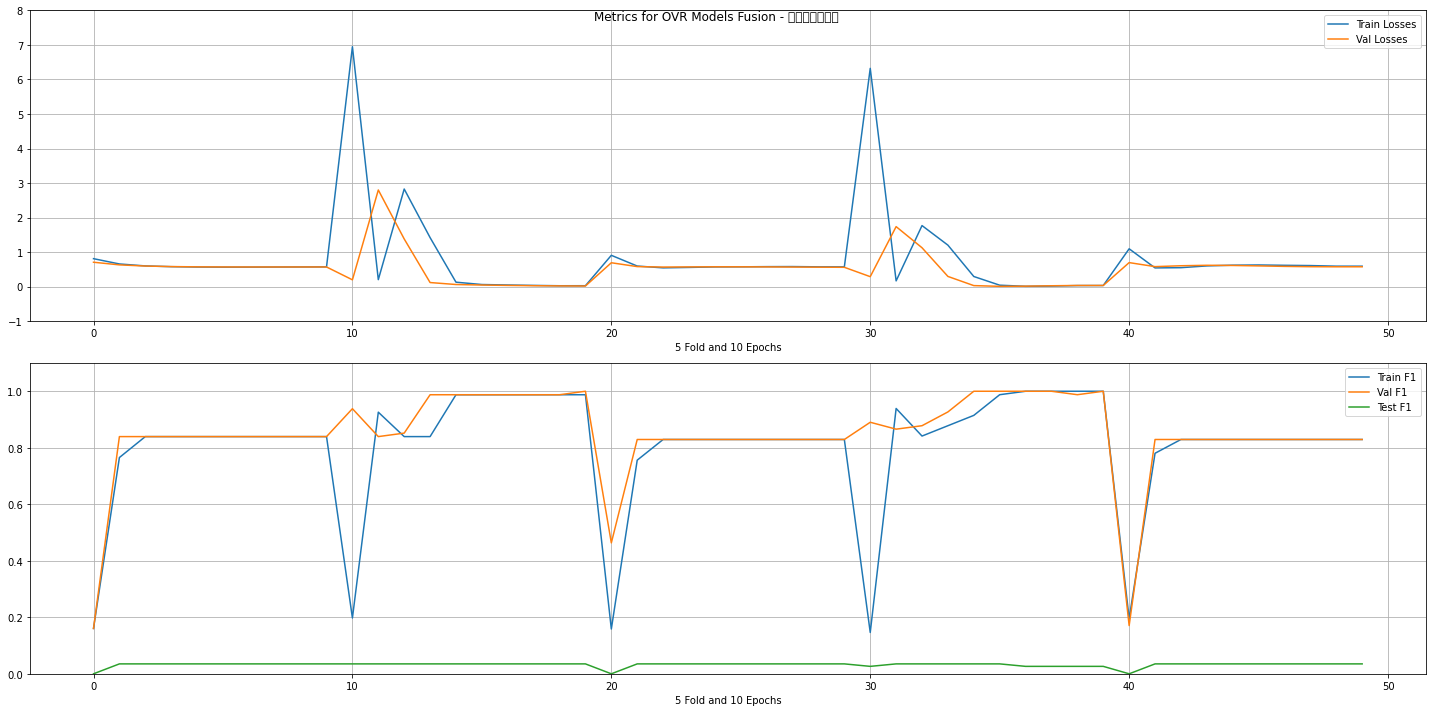

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
6,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
7,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
9,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
5,0.987805,1.000000,0.035088,0.987805,1.000000,0.035088,0.987805,1.000000,0.035088
9,0.987654,1.000000,0.035088,0.987654,1.000000,0.035088,0.987654,1.000000,0.035088
4,0.914634,1.000000,0.035088,0.914634,1.000000,0.035088,0.914634,1.000000,0.035088
8,1.000000,0.987805,0.026316,1.000000,0.987805,0.026316,1.000000,0.987805,0.026316
4,0.987654,0.987654,0.035088,0.987654,0.987654,0.035088,0.987654,0.987654,0.035088
5,0.987654,0.987654,0.035088,0.987654,0.987654,0.035088,0.987654,0.987654,0.035088
6,0.987654,0.987654,0.035088,0.987654,0.987654,0.035088,0.987654,0.987654,0.035088


Training for గుండుక్రియ with 25 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 120/30


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.806 / Validation Loss : 0.679 [Time : 12.616947 seconds]
Epoch 2/10 : Training Loss: 0.615 / Validation Loss : 0.594 [Time : 12.571264 seconds]
Epoch 3/10 : Training Loss: 0.562 / Validation Loss : 0.559 [Time : 12.620659 seconds]
Epoch 4/10 : Training Loss: 0.540 / Validation Loss : 0.541 [Time : 12.786349 seconds]
Epoch 5/10 : Training Loss: 0.528 / Validation Loss : 0.533 [Time : 12.728215 seconds]
Epoch 6/10 : Training Loss: 0.524 / Validation Loss : 0.530 [Time : 12.645392 seconds]
Epoch 7/10 : Training Loss: 0.526 / Validation Loss : 0.529 [Time : 12.594125 seconds]
Epoch 8/10 : Training Loss: 0.529 / Validation Loss : 0.530 [Time : 11.761027 seconds]
Epoch 9/10 : Training Loss: 0.530 / Validation Loss : 0.529 [Time : 12.568884 seconds]
Epoch 10/10 : Training Loss: 0.531 / Validation Loss : 0.529 [Time : 12.701968 seconds]
*** Confusion Matrix - Training ***
[[100   0]
 [ 20   0]]
*** Confusion Matrix - Validation ***
[[100 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.050 / Validation Loss : 2.657 [Time : 11.705815 seconds]
Epoch 2/10 : Training Loss: 2.583 / Validation Loss : 2.663 [Time : 11.70517 seconds]
Epoch 3/10 : Training Loss: 2.747 / Validation Loss : 0.957 [Time : 11.754385 seconds]
Epoch 4/10 : Training Loss: 0.971 / Validation Loss : 0.098 [Time : 12.675906 seconds]
Epoch 5/10 : Training Loss: 0.154 / Validation Loss : 0.089 [Time : 12.653216 seconds]
Epoch 6/10 : Training Loss: 0.233 / Validation Loss : 0.088 [Time : 12.656703 seconds]
Epoch 7/10 : Training Loss: 0.051 / Validation Loss : 0.017 [Time : 12.968448 seconds]
Epoch 8/10 : Training Loss: 0.017 / Validation Loss : 0.014 [Time : 12.811452 seconds]
Epoch 9/10 : Training Loss: 0.015 / Validation Loss : 0.014 [Time : 12.618225 seconds]
Epoch 10/10 : Training Loss: 0.016 / Validation Loss : 0.013 [Time : 13.108618 seconds]
*** Confusion Matrix - Training ***
[[100   0]
 [  0  20]]
*** Confusion Matrix - Validation ***
[[100   0]
 [  0  20]]
Fold 2 : 1

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.887 / Validation Loss : 0.626 [Time : 11.72205 seconds]
Epoch 2/10 : Training Loss: 0.525 / Validation Loss : 0.526 [Time : 11.757167 seconds]
Epoch 3/10 : Training Loss: 0.493 / Validation Loss : 0.519 [Time : 11.753183 seconds]
Epoch 4/10 : Training Loss: 0.506 / Validation Loss : 0.523 [Time : 11.718241 seconds]
Epoch 5/10 : Training Loss: 0.523 / Validation Loss : 0.525 [Time : 11.719211 seconds]
Epoch 6/10 : Training Loss: 0.529 / Validation Loss : 0.524 [Time : 11.761011 seconds]
Epoch 7/10 : Training Loss: 0.530 / Validation Loss : 0.520 [Time : 11.685206 seconds]
Epoch 8/10 : Training Loss: 0.526 / Validation Loss : 0.516 [Time : 11.739053 seconds]
Epoch 9/10 : Training Loss: 0.525 / Validation Loss : 0.512 [Time : 11.789129 seconds]
Epoch 10/10 : Training Loss: 0.524 / Validation Loss : 0.510 [Time : 11.736661 seconds]
*** Confusion Matrix - Training ***
[[100   0]
 [ 20   0]]
*** Confusion Matrix - Validation ***
[[100   0]
 [ 20   0]]
Fold 3 : 1

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 5.978 / Validation Loss : 1.641 [Time : 11.698059 seconds]
Epoch 2/10 : Training Loss: 1.647 / Validation Loss : 2.969 [Time : 11.72416 seconds]
Epoch 3/10 : Training Loss: 2.969 / Validation Loss : 2.532 [Time : 11.715408 seconds]
Epoch 4/10 : Training Loss: 2.620 / Validation Loss : 1.441 [Time : 11.710821 seconds]
Epoch 5/10 : Training Loss: 1.489 / Validation Loss : 0.380 [Time : 11.682878 seconds]
Epoch 6/10 : Training Loss: 0.395 / Validation Loss : 0.056 [Time : 11.765762 seconds]
Epoch 7/10 : Training Loss: 0.093 / Validation Loss : 0.101 [Time : 11.700922 seconds]
Epoch 8/10 : Training Loss: 0.167 / Validation Loss : 0.148 [Time : 11.708793 seconds]
Epoch 9/10 : Training Loss: 0.108 / Validation Loss : 0.058 [Time : 11.710191 seconds]
Epoch 10/10 : Training Loss: 0.039 / Validation Loss : 0.027 [Time : 11.710548 seconds]
*** Confusion Matrix - Training ***
[[100   0]
 [  0  20]]
*** Confusion Matrix - Validation ***
[[100   0]
 [  0  20]]
Fold 4 : 1

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 1.038 / Validation Loss : 0.590 [Time : 11.684353 seconds]
Epoch 2/10 : Training Loss: 0.460 / Validation Loss : 0.539 [Time : 11.794134 seconds]
Epoch 3/10 : Training Loss: 0.520 / Validation Loss : 0.563 [Time : 11.72343 seconds]
Epoch 4/10 : Training Loss: 0.565 / Validation Loss : 0.566 [Time : 11.815087 seconds]
Epoch 5/10 : Training Loss: 0.572 / Validation Loss : 0.555 [Time : 11.818809 seconds]
Epoch 6/10 : Training Loss: 0.570 / Validation Loss : 0.541 [Time : 11.722469 seconds]
Epoch 7/10 : Training Loss: 0.559 / Validation Loss : 0.532 [Time : 11.733948 seconds]
Epoch 8/10 : Training Loss: 0.553 / Validation Loss : 0.528 [Time : 11.722894 seconds]
Epoch 9/10 : Training Loss: 0.540 / Validation Loss : 0.527 [Time : 12.340678 seconds]
Epoch 10/10 : Training Loss: 0.539 / Validation Loss : 0.526 [Time : 11.736148 seconds]
*** Confusion Matrix - Training ***
[[100   0]
 [ 20   0]]
*** Confusion Matrix - Validation ***
[[100   0]
 [ 20   0]]
Fold 5 : 1

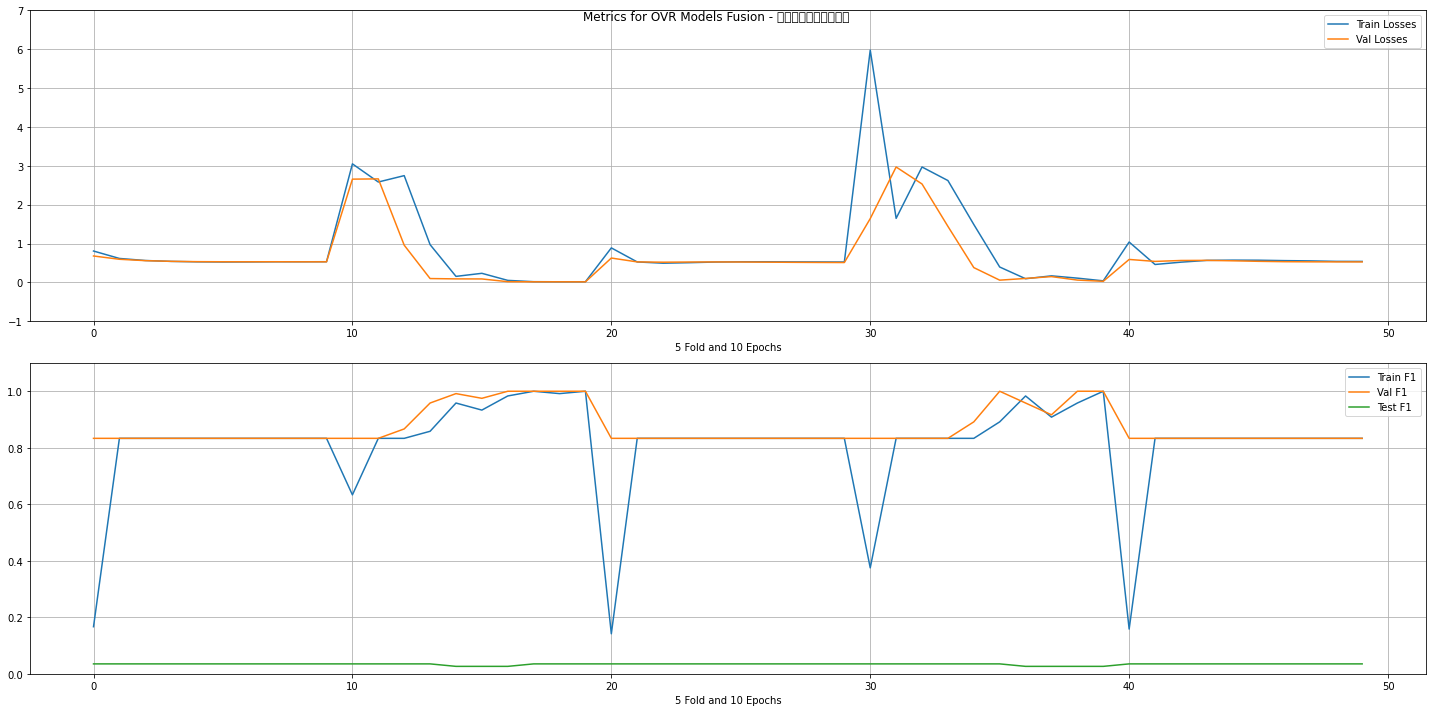

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
7,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
9,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
9,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
8,0.991667,1.000000,0.035088,0.991667,1.000000,0.035088,0.991667,1.000000,0.035088
6,0.983333,1.000000,0.026316,0.983333,1.000000,0.026316,0.983333,1.000000,0.026316
8,0.958333,1.000000,0.026316,0.958333,1.000000,0.026316,0.958333,1.000000,0.026316
5,0.891667,1.000000,0.035088,0.891667,1.000000,0.035088,0.891667,1.000000,0.035088
4,0.958333,0.991667,0.026316,0.958333,0.991667,0.026316,0.958333,0.991667,0.026316
5,0.933333,0.975000,0.026316,0.933333,0.975000,0.026316,0.933333,0.975000,0.026316
6,0.983333,0.958333,0.026316,0.983333,0.958333,0.026316,0.983333,0.958333,0.026316


Training for గుజ్జరి with 13 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 62/16


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.796 / Validation Loss : 0.731 [Time : 11.621742 seconds]
Epoch 2/10 : Training Loss: 0.710 / Validation Loss : 0.688 [Time : 11.753377 seconds]
Epoch 3/10 : Training Loss: 0.668 / Validation Loss : 0.662 [Time : 11.795051 seconds]
Epoch 4/10 : Training Loss: 0.647 / Validation Loss : 0.650 [Time : 11.945272 seconds]
Epoch 5/10 : Training Loss: 0.641 / Validation Loss : 0.645 [Time : 11.90899 seconds]
Epoch 6/10 : Training Loss: 0.640 / Validation Loss : 0.643 [Time : 11.669411 seconds]
Epoch 7/10 : Training Loss: 0.640 / Validation Loss : 0.642 [Time : 11.664672 seconds]
Epoch 8/10 : Training Loss: 0.640 / Validation Loss : 0.642 [Time : 11.734237 seconds]
Epoch 9/10 : Training Loss: 0.642 / Validation Loss : 0.642 [Time : 11.699527 seconds]
Epoch 10/10 : Training Loss: 0.642 / Validation Loss : 0.642 [Time : 11.930061 seconds]
*** Confusion Matrix - Training ***
[[52  0]
 [10  0]]
*** Confusion Matrix - Validation ***
[[52  0]
 [

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.376 / Validation Loss : 0.235 [Time : 11.699178 seconds]
Epoch 2/10 : Training Loss: 0.189 / Validation Loss : 0.891 [Time : 10.999261 seconds]
Epoch 3/10 : Training Loss: 0.886 / Validation Loss : 0.712 [Time : 10.778915 seconds]
Epoch 4/10 : Training Loss: 0.656 / Validation Loss : 0.202 [Time : 11.769043 seconds]
Epoch 5/10 : Training Loss: 0.265 / Validation Loss : 0.014 [Time : 11.670884 seconds]
Epoch 6/10 : Training Loss: 0.020 / Validation Loss : 0.001 [Time : 11.956585 seconds]
Epoch 7/10 : Training Loss: 0.001 / Validation Loss : 0.000 [Time : 11.730841 seconds]
Epoch 8/10 : Training Loss: 0.000 / Validation Loss : 0.000 [Time : 10.849666 seconds]
Epoch 9/10 : Training Loss: 0.000 / Validation Loss : 0.000 [Time : 10.998293 seconds]
Epoch 10/10 : Training Loss: 0.001 / Validation Loss : 0.000 [Time : 11.010741 seconds]
*** Confusion Matrix - Training ***
[[52  0]
 [ 0 10]]
*** Confusion Matrix - Validation ***
[[52  0]
 [ 0 10]]
Fold 2 : 114.3475

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.892 / Validation Loss : 0.752 [Time : 10.774926 seconds]
Epoch 2/10 : Training Loss: 0.693 / Validation Loss : 0.655 [Time : 10.809485 seconds]
Epoch 3/10 : Training Loss: 0.618 / Validation Loss : 0.629 [Time : 11.144951 seconds]
Epoch 4/10 : Training Loss: 0.610 / Validation Loss : 0.631 [Time : 10.869302 seconds]
Epoch 5/10 : Training Loss: 0.625 / Validation Loss : 0.636 [Time : 10.860377 seconds]
Epoch 6/10 : Training Loss: 0.635 / Validation Loss : 0.638 [Time : 10.836426 seconds]
Epoch 7/10 : Training Loss: 0.640 / Validation Loss : 0.635 [Time : 11.104241 seconds]
Epoch 8/10 : Training Loss: 0.634 / Validation Loss : 0.630 [Time : 10.745622 seconds]
Epoch 9/10 : Training Loss: 0.639 / Validation Loss : 0.623 [Time : 10.739824 seconds]
Epoch 10/10 : Training Loss: 0.630 / Validation Loss : 0.617 [Time : 10.808975 seconds]
*** Confusion Matrix - Training ***
[[52  0]
 [10  0]]
*** Confusion Matrix - Validation ***
[[52  0]
 [10  0]]
Fold 3 : 109.5311

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.068 / Validation Loss : 0.229 [Time : 10.777326 seconds]
Epoch 2/10 : Training Loss: 0.175 / Validation Loss : 1.681 [Time : 10.833849 seconds]
Epoch 3/10 : Training Loss: 1.958 / Validation Loss : 1.198 [Time : 10.793882 seconds]
Epoch 4/10 : Training Loss: 1.156 / Validation Loss : 0.256 [Time : 10.821722 seconds]
Epoch 5/10 : Training Loss: 0.269 / Validation Loss : 0.050 [Time : 10.947952 seconds]
Epoch 6/10 : Training Loss: 0.051 / Validation Loss : 0.014 [Time : 10.815157 seconds]
Epoch 7/10 : Training Loss: 0.021 / Validation Loss : 0.022 [Time : 10.864703 seconds]
Epoch 8/10 : Training Loss: 0.033 / Validation Loss : 0.049 [Time : 10.79569 seconds]
Epoch 9/10 : Training Loss: 0.065 / Validation Loss : 0.064 [Time : 11.07542 seconds]
Epoch 10/10 : Training Loss: 0.064 / Validation Loss : 0.049 [Time : 10.875423 seconds]
*** Confusion Matrix - Training ***
[[52  0]
 [ 1 10]]
*** Confusion Matrix - Validation ***
[[52  0]
 [ 0 11]]
Fold 4 : 109.422107

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 1.083 / Validation Loss : 0.817 [Time : 10.781907 seconds]
Epoch 2/10 : Training Loss: 0.699 / Validation Loss : 0.659 [Time : 10.880429 seconds]
Epoch 3/10 : Training Loss: 0.610 / Validation Loss : 0.671 [Time : 11.113493 seconds]
Epoch 4/10 : Training Loss: 0.658 / Validation Loss : 0.699 [Time : 10.793348 seconds]
Epoch 5/10 : Training Loss: 0.702 / Validation Loss : 0.703 [Time : 10.811644 seconds]
Epoch 6/10 : Training Loss: 0.706 / Validation Loss : 0.690 [Time : 10.79711 seconds]
Epoch 7/10 : Training Loss: 0.706 / Validation Loss : 0.671 [Time : 10.834861 seconds]
Epoch 8/10 : Training Loss: 0.683 / Validation Loss : 0.656 [Time : 10.897008 seconds]
Epoch 9/10 : Training Loss: 0.669 / Validation Loss : 0.648 [Time : 10.773373 seconds]
Epoch 10/10 : Training Loss: 0.672 / Validation Loss : 0.647 [Time : 10.78386 seconds]
*** Confusion Matrix - Training ***
[[52  0]
 [11  0]]
*** Confusion Matrix - Validation ***
[[52  0]
 [11  0]]
Fold 5 : 109.304217

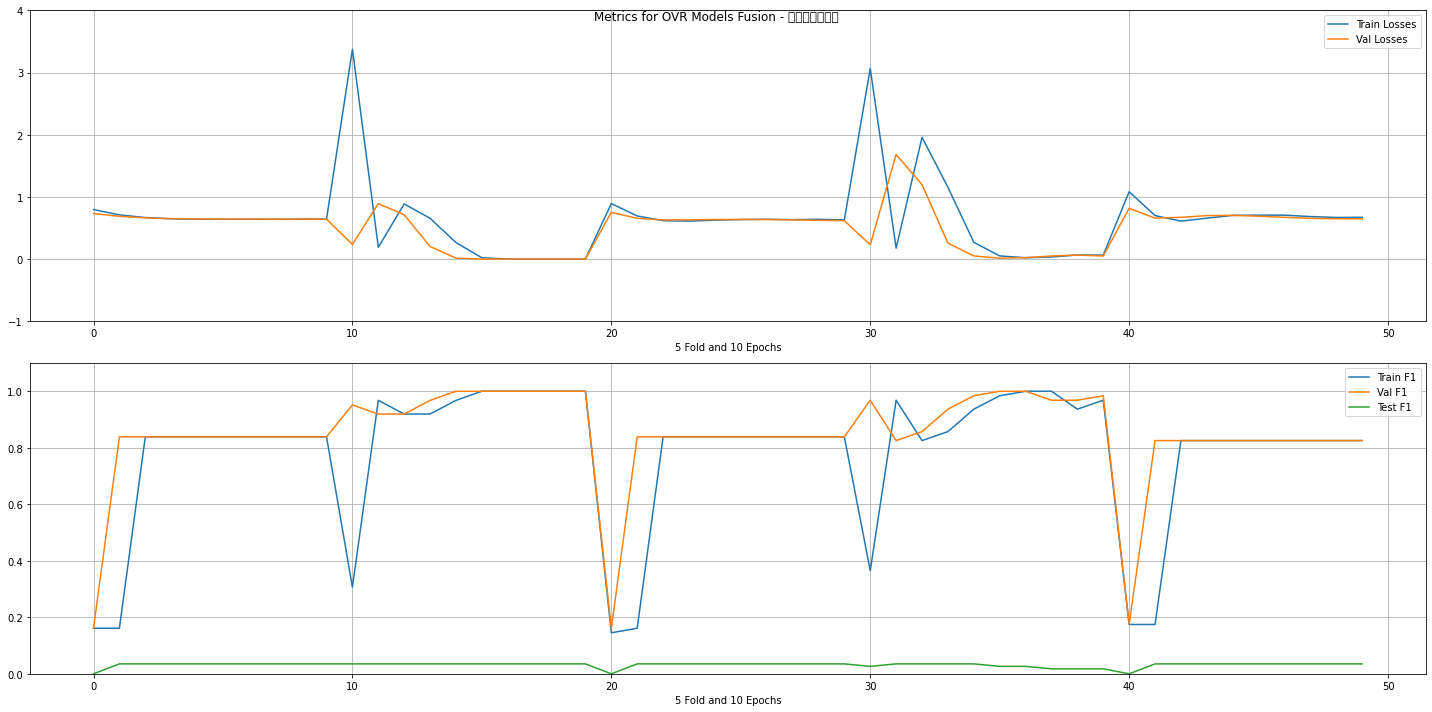

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
5,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
6,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
7,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
8,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
9,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
6,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
5,0.984127,1.000000,0.026316,0.984127,1.000000,0.026316,0.984127,1.000000,0.026316
4,0.967742,1.000000,0.035088,0.967742,1.000000,0.035088,0.967742,1.000000,0.035088
9,0.968254,0.984127,0.017544,0.968254,0.984127,0.017544,0.968254,0.984127,0.017544
4,0.936508,0.984127,0.035088,0.936508,0.984127,0.035088,0.936508,0.984127,0.035088


Training for గౌళ with 11 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 52/14


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.791 / Validation Loss : 0.727 [Time : 11.457263 seconds]
Epoch 2/10 : Training Loss: 0.694 / Validation Loss : 0.667 [Time : 11.750782 seconds]
Epoch 3/10 : Training Loss: 0.641 / Validation Loss : 0.638 [Time : 11.500809 seconds]
Epoch 4/10 : Training Loss: 0.622 / Validation Loss : 0.626 [Time : 11.547659 seconds]
Epoch 5/10 : Training Loss: 0.617 / Validation Loss : 0.621 [Time : 11.999352 seconds]
Epoch 6/10 : Training Loss: 0.616 / Validation Loss : 0.620 [Time : 11.540664 seconds]
Epoch 7/10 : Training Loss: 0.618 / Validation Loss : 0.620 [Time : 10.62428 seconds]
Epoch 8/10 : Training Loss: 0.613 / Validation Loss : 0.620 [Time : 10.631375 seconds]
Epoch 9/10 : Training Loss: 0.621 / Validation Loss : 0.621 [Time : 10.633184 seconds]
Epoch 10/10 : Training Loss: 0.621 / Validation Loss : 0.621 [Time : 10.669091 seconds]
*** Confusion Matrix - Training ***
[[44  0]
 [ 8  0]]
*** Confusion Matrix - Validation ***
[[44  0]
 [

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 4.255 / Validation Loss : 1.324 [Time : 10.633788 seconds]
Epoch 2/10 : Training Loss: 1.474 / Validation Loss : 0.496 [Time : 11.501618 seconds]
Epoch 3/10 : Training Loss: 0.525 / Validation Loss : 0.229 [Time : 11.566721 seconds]
Epoch 4/10 : Training Loss: 0.325 / Validation Loss : 0.032 [Time : 11.558599 seconds]
Epoch 5/10 : Training Loss: 0.031 / Validation Loss : 0.003 [Time : 11.540953 seconds]
Epoch 6/10 : Training Loss: 0.003 / Validation Loss : 0.002 [Time : 11.57083 seconds]
Epoch 7/10 : Training Loss: 0.003 / Validation Loss : 0.002 [Time : 10.785251 seconds]
Epoch 8/10 : Training Loss: 0.002 / Validation Loss : 0.002 [Time : 10.689266 seconds]
Epoch 9/10 : Training Loss: 0.002 / Validation Loss : 0.002 [Time : 10.612784 seconds]
Epoch 10/10 : Training Loss: 0.002 / Validation Loss : 0.002 [Time : 10.628846 seconds]
*** Confusion Matrix - Training ***
[[44  0]
 [ 0  9]]
*** Confusion Matrix - Validation ***
[[44  0]
 [ 0  9]]
Fold 2 : 111.92997

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.891 / Validation Loss : 0.749 [Time : 10.613807 seconds]
Epoch 2/10 : Training Loss: 0.686 / Validation Loss : 0.652 [Time : 10.701388 seconds]
Epoch 3/10 : Training Loss: 0.619 / Validation Loss : 0.635 [Time : 11.614007 seconds]
Epoch 4/10 : Training Loss: 0.619 / Validation Loss : 0.641 [Time : 10.686699 seconds]
Epoch 5/10 : Training Loss: 0.642 / Validation Loss : 0.646 [Time : 10.694888 seconds]
Epoch 6/10 : Training Loss: 0.646 / Validation Loss : 0.646 [Time : 10.670803 seconds]
Epoch 7/10 : Training Loss: 0.650 / Validation Loss : 0.641 [Time : 10.681948 seconds]
Epoch 8/10 : Training Loss: 0.653 / Validation Loss : 0.633 [Time : 10.654241 seconds]
Epoch 9/10 : Training Loss: 0.643 / Validation Loss : 0.626 [Time : 10.61672 seconds]
Epoch 10/10 : Training Loss: 0.637 / Validation Loss : 0.620 [Time : 10.747817 seconds]
*** Confusion Matrix - Training ***
[[44  0]
 [ 9  0]]
*** Confusion Matrix - Validation ***
[[44  0]
 [ 9  0]]
Fold 3 : 108.55213

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 4.457 / Validation Loss : 0.379 [Time : 10.753798 seconds]
Epoch 2/10 : Training Loss: 0.093 / Validation Loss : 0.487 [Time : 10.665796 seconds]
Epoch 3/10 : Training Loss: 0.595 / Validation Loss : 0.349 [Time : 10.636346 seconds]
Epoch 4/10 : Training Loss: 0.395 / Validation Loss : 0.104 [Time : 10.630641 seconds]
Epoch 5/10 : Training Loss: 0.109 / Validation Loss : 0.010 [Time : 10.610967 seconds]
Epoch 6/10 : Training Loss: 0.007 / Validation Loss : 0.003 [Time : 10.666423 seconds]
Epoch 7/10 : Training Loss: 0.004 / Validation Loss : 0.003 [Time : 10.625141 seconds]
Epoch 8/10 : Training Loss: 0.003 / Validation Loss : 0.003 [Time : 10.66571 seconds]
Epoch 9/10 : Training Loss: 0.003 / Validation Loss : 0.003 [Time : 10.680425 seconds]
Epoch 10/10 : Training Loss: 0.004 / Validation Loss : 0.004 [Time : 10.65225 seconds]
*** Confusion Matrix - Training ***
[[44  0]
 [ 0  9]]
*** Confusion Matrix - Validation ***
[[44  0]
 [ 0  9]]
Fold 4 : 107.402649

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 1.064 / Validation Loss : 0.811 [Time : 10.60313 seconds]
Epoch 2/10 : Training Loss: 0.679 / Validation Loss : 0.636 [Time : 10.702687 seconds]
Epoch 3/10 : Training Loss: 0.587 / Validation Loss : 0.657 [Time : 10.676252 seconds]
Epoch 4/10 : Training Loss: 0.648 / Validation Loss : 0.685 [Time : 10.777769 seconds]
Epoch 5/10 : Training Loss: 0.674 / Validation Loss : 0.691 [Time : 10.627649 seconds]
Epoch 6/10 : Training Loss: 0.703 / Validation Loss : 0.678 [Time : 10.633792 seconds]
Epoch 7/10 : Training Loss: 0.692 / Validation Loss : 0.656 [Time : 10.638704 seconds]
Epoch 8/10 : Training Loss: 0.681 / Validation Loss : 0.639 [Time : 10.667125 seconds]
Epoch 9/10 : Training Loss: 0.661 / Validation Loss : 0.631 [Time : 10.717511 seconds]
Epoch 10/10 : Training Loss: 0.651 / Validation Loss : 0.631 [Time : 10.696401 seconds]
*** Confusion Matrix - Training ***
[[44  0]
 [ 9  0]]
*** Confusion Matrix - Validation ***
[[44  0]
 [ 9  0]]
Fold 5 : 107.57479

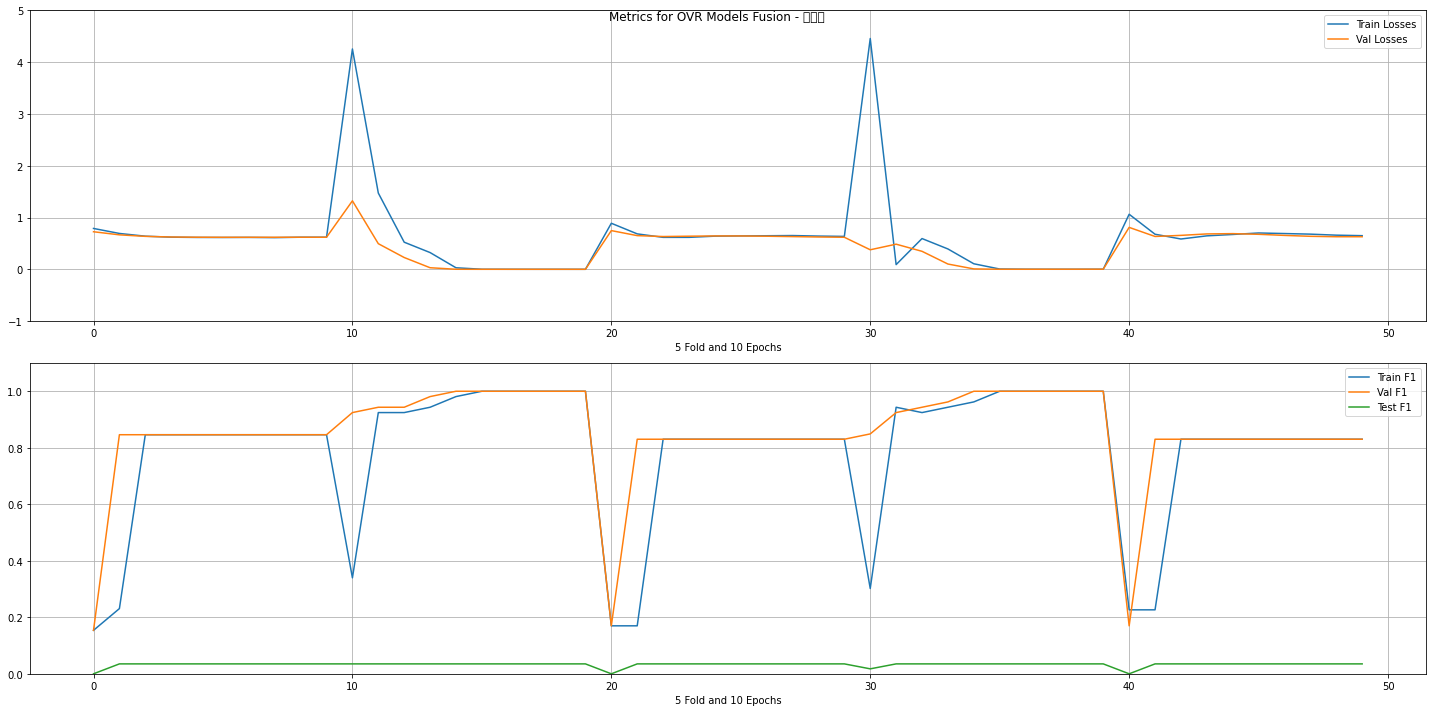

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
5,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
6,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
7,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
8,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
9,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
5,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
6,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
7,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
8,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
9,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088


Training for దేవగాంధారి with 30 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 144/36


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.786 / Validation Loss : 0.637 [Time : 12.994495 seconds]
Epoch 2/10 : Training Loss: 0.571 / Validation Loss : 0.547 [Time : 12.971571 seconds]
Epoch 3/10 : Training Loss: 0.512 / Validation Loss : 0.507 [Time : 12.989272 seconds]
Epoch 4/10 : Training Loss: 0.481 / Validation Loss : 0.488 [Time : 13.014316 seconds]
Epoch 5/10 : Training Loss: 0.474 / Validation Loss : 0.481 [Time : 13.204706 seconds]
Epoch 6/10 : Training Loss: 0.473 / Validation Loss : 0.478 [Time : 12.999131 seconds]
Epoch 7/10 : Training Loss: 0.476 / Validation Loss : 0.477 [Time : 13.025971 seconds]
Epoch 8/10 : Training Loss: 0.477 / Validation Loss : 0.476 [Time : 12.98914 seconds]
Epoch 9/10 : Training Loss: 0.480 / Validation Loss : 0.475 [Time : 13.028538 seconds]
Epoch 10/10 : Training Loss: 0.476 / Validation Loss : 0.475 [Time : 12.217159 seconds]
*** Confusion Matrix - Training ***
[[120   0]
 [ 24   0]]
*** Confusion Matrix - Validation ***
[[120  

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 7.414 / Validation Loss : 3.105 [Time : 12.27251 seconds]
Epoch 2/10 : Training Loss: 3.310 / Validation Loss : 1.920 [Time : 12.103149 seconds]
Epoch 3/10 : Training Loss: 1.815 / Validation Loss : 0.238 [Time : 13.037563 seconds]
Epoch 4/10 : Training Loss: 0.245 / Validation Loss : 0.060 [Time : 12.966732 seconds]
Epoch 5/10 : Training Loss: 0.245 / Validation Loss : 0.103 [Time : 12.142753 seconds]
Epoch 6/10 : Training Loss: 0.060 / Validation Loss : 0.023 [Time : 13.174481 seconds]
Epoch 7/10 : Training Loss: 0.014 / Validation Loss : 0.017 [Time : 12.974941 seconds]
Epoch 8/10 : Training Loss: 0.017 / Validation Loss : 0.016 [Time : 13.011715 seconds]
Epoch 9/10 : Training Loss: 0.022 / Validation Loss : 0.014 [Time : 13.022547 seconds]
Epoch 10/10 : Training Loss: 0.017 / Validation Loss : 0.011 [Time : 13.042173 seconds]
*** Confusion Matrix - Training ***
[[120   0]
 [  1  23]]
*** Confusion Matrix - Validation ***
[[120   0]
 [  1  23]]
Fold 2 : 1

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.845 / Validation Loss : 0.574 [Time : 12.130805 seconds]
Epoch 2/10 : Training Loss: 0.481 / Validation Loss : 0.495 [Time : 12.099387 seconds]
Epoch 3/10 : Training Loss: 0.469 / Validation Loss : 0.491 [Time : 12.142007 seconds]
Epoch 4/10 : Training Loss: 0.485 / Validation Loss : 0.495 [Time : 12.116866 seconds]
Epoch 5/10 : Training Loss: 0.497 / Validation Loss : 0.495 [Time : 12.077143 seconds]
Epoch 6/10 : Training Loss: 0.503 / Validation Loss : 0.492 [Time : 12.133494 seconds]
Epoch 7/10 : Training Loss: 0.502 / Validation Loss : 0.488 [Time : 12.131103 seconds]
Epoch 8/10 : Training Loss: 0.496 / Validation Loss : 0.484 [Time : 12.104917 seconds]
Epoch 9/10 : Training Loss: 0.489 / Validation Loss : 0.481 [Time : 12.115326 seconds]
Epoch 10/10 : Training Loss: 0.486 / Validation Loss : 0.478 [Time : 12.129273 seconds]
*** Confusion Matrix - Training ***
[[120   0]
 [ 24   0]]
*** Confusion Matrix - Validation ***
[[120   0]
 [ 24   0]]
Fold 3 : 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 5.586 / Validation Loss : 2.525 [Time : 12.083247 seconds]
Epoch 2/10 : Training Loss: 2.471 / Validation Loss : 2.343 [Time : 12.134903 seconds]
Epoch 3/10 : Training Loss: 2.486 / Validation Loss : 0.444 [Time : 12.172824 seconds]
Epoch 4/10 : Training Loss: 0.524 / Validation Loss : 0.079 [Time : 12.086046 seconds]
Epoch 5/10 : Training Loss: 0.266 / Validation Loss : 0.159 [Time : 12.105694 seconds]
Epoch 6/10 : Training Loss: 0.096 / Validation Loss : 0.054 [Time : 12.127338 seconds]
Epoch 7/10 : Training Loss: 0.045 / Validation Loss : 0.035 [Time : 12.104633 seconds]
Epoch 8/10 : Training Loss: 0.037 / Validation Loss : 0.033 [Time : 12.114986 seconds]
Epoch 9/10 : Training Loss: 0.036 / Validation Loss : 0.027 [Time : 12.100177 seconds]
Epoch 10/10 : Training Loss: 0.031 / Validation Loss : 0.021 [Time : 12.135087 seconds]
*** Confusion Matrix - Training ***
[[120   0]
 [  1  23]]
*** Confusion Matrix - Validation ***
[[120   0]
 [  1  23]]
Fold 4 : 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.961 / Validation Loss : 0.507 [Time : 12.076379 seconds]
Epoch 2/10 : Training Loss: 0.418 / Validation Loss : 0.490 [Time : 12.094661 seconds]
Epoch 3/10 : Training Loss: 0.481 / Validation Loss : 0.506 [Time : 12.122544 seconds]
Epoch 4/10 : Training Loss: 0.511 / Validation Loss : 0.506 [Time : 12.127409 seconds]
Epoch 5/10 : Training Loss: 0.518 / Validation Loss : 0.495 [Time : 12.113038 seconds]
Epoch 6/10 : Training Loss: 0.507 / Validation Loss : 0.485 [Time : 12.131443 seconds]
Epoch 7/10 : Training Loss: 0.502 / Validation Loss : 0.479 [Time : 12.140066 seconds]
Epoch 8/10 : Training Loss: 0.495 / Validation Loss : 0.476 [Time : 12.142597 seconds]
Epoch 9/10 : Training Loss: 0.491 / Validation Loss : 0.476 [Time : 12.138689 seconds]
Epoch 10/10 : Training Loss: 0.486 / Validation Loss : 0.475 [Time : 12.097588 seconds]
*** Confusion Matrix - Training ***
[[120   0]
 [ 24   0]]
*** Confusion Matrix - Validation ***
[[120   0]
 [ 24   0]]
Fold 5 : 

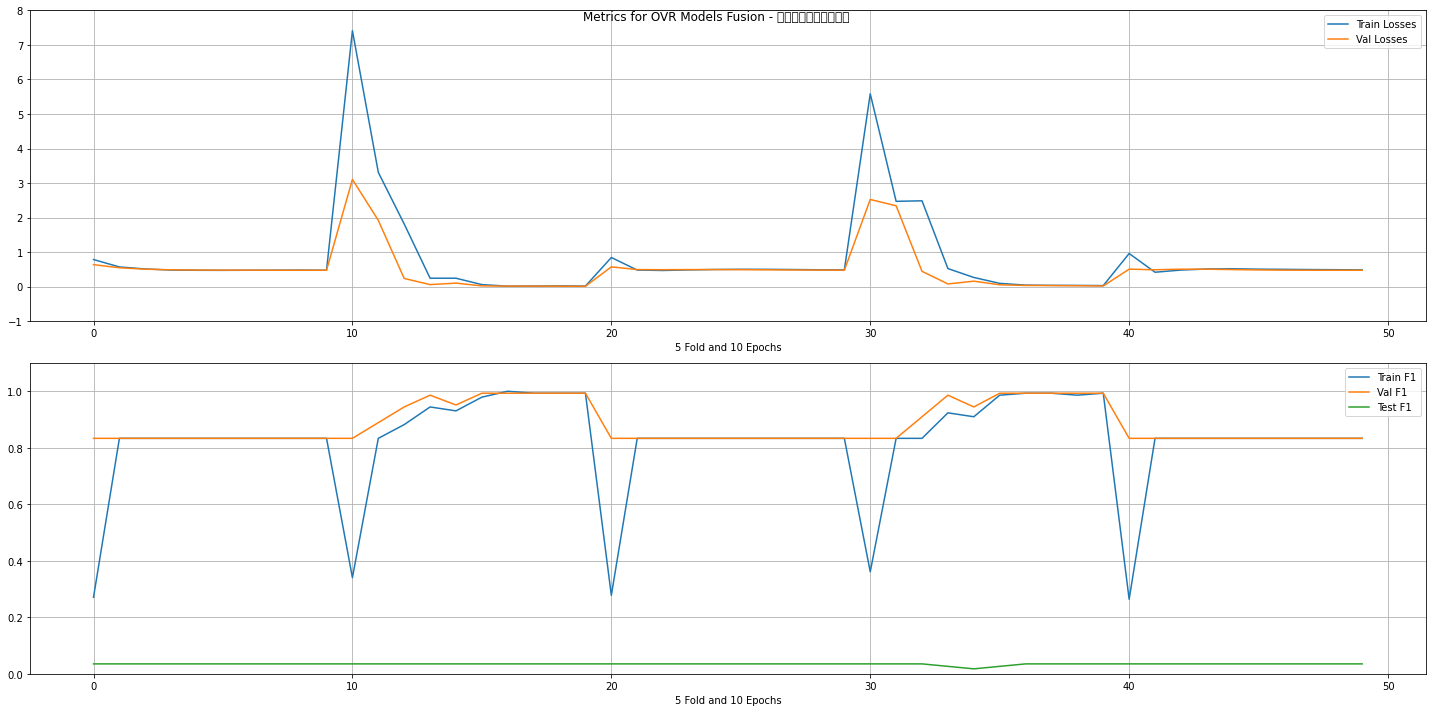

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
6,1.000000,0.993056,0.035088,1.000000,0.993056,0.035088,1.000000,0.993056,0.035088
7,0.993056,0.993056,0.035088,0.993056,0.993056,0.035088,0.993056,0.993056,0.035088
8,0.993056,0.993056,0.035088,0.993056,0.993056,0.035088,0.993056,0.993056,0.035088
9,0.993056,0.993056,0.035088,0.993056,0.993056,0.035088,0.993056,0.993056,0.035088
6,0.993056,0.993056,0.035088,0.993056,0.993056,0.035088,0.993056,0.993056,0.035088
7,0.993056,0.993056,0.035088,0.993056,0.993056,0.035088,0.993056,0.993056,0.035088
9,0.993056,0.993056,0.035088,0.993056,0.993056,0.035088,0.993056,0.993056,0.035088
5,0.986111,0.993056,0.026316,0.986111,0.993056,0.026316,0.986111,0.993056,0.026316
8,0.986111,0.993056,0.035088,0.986111,0.993056,0.035088,0.986111,0.993056,0.035088
5,0.979167,0.993056,0.035088,0.979167,0.993056,0.035088,0.979167,0.993056,0.035088


Training for దేసాక్షి with 25 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 120/30


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.806 / Validation Loss : 0.679 [Time : 12.573604 seconds]
Epoch 2/10 : Training Loss: 0.615 / Validation Loss : 0.594 [Time : 12.593966 seconds]
Epoch 3/10 : Training Loss: 0.562 / Validation Loss : 0.559 [Time : 13.315965 seconds]
Epoch 4/10 : Training Loss: 0.540 / Validation Loss : 0.541 [Time : 12.608742 seconds]
Epoch 5/10 : Training Loss: 0.528 / Validation Loss : 0.533 [Time : 12.657363 seconds]
Epoch 6/10 : Training Loss: 0.524 / Validation Loss : 0.530 [Time : 12.630123 seconds]
Epoch 7/10 : Training Loss: 0.526 / Validation Loss : 0.529 [Time : 12.73664 seconds]
Epoch 8/10 : Training Loss: 0.529 / Validation Loss : 0.530 [Time : 11.746383 seconds]
Epoch 9/10 : Training Loss: 0.530 / Validation Loss : 0.529 [Time : 12.633545 seconds]
Epoch 10/10 : Training Loss: 0.531 / Validation Loss : 0.529 [Time : 12.639368 seconds]
*** Confusion Matrix - Training ***
[[100   0]
 [ 20   0]]
*** Confusion Matrix - Validation ***
[[100  

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 7.243 / Validation Loss : 3.187 [Time : 11.729845 seconds]
Epoch 2/10 : Training Loss: 3.224 / Validation Loss : 2.341 [Time : 11.708699 seconds]
Epoch 3/10 : Training Loss: 2.346 / Validation Loss : 0.208 [Time : 12.742644 seconds]
Epoch 4/10 : Training Loss: 0.226 / Validation Loss : 0.057 [Time : 12.574 seconds]
Epoch 5/10 : Training Loss: 0.110 / Validation Loss : 0.096 [Time : 11.758499 seconds]
Epoch 6/10 : Training Loss: 0.137 / Validation Loss : 0.079 [Time : 11.713572 seconds]
Epoch 7/10 : Training Loss: 0.055 / Validation Loss : 0.029 [Time : 12.575059 seconds]
Epoch 8/10 : Training Loss: 0.025 / Validation Loss : 0.015 [Time : 12.619169 seconds]
Epoch 9/10 : Training Loss: 0.011 / Validation Loss : 0.011 [Time : 12.737058 seconds]
Epoch 10/10 : Training Loss: 0.009 / Validation Loss : 0.010 [Time : 12.567522 seconds]
*** Confusion Matrix - Training ***
[[100   0]
 [  0  20]]
*** Confusion Matrix - Validation ***
[[100   0]
 [  0  20]]
Fold 2 : 123

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.894 / Validation Loss : 0.643 [Time : 11.721487 seconds]
Epoch 2/10 : Training Loss: 0.543 / Validation Loss : 0.546 [Time : 11.725688 seconds]
Epoch 3/10 : Training Loss: 0.513 / Validation Loss : 0.539 [Time : 11.683633 seconds]
Epoch 4/10 : Training Loss: 0.527 / Validation Loss : 0.543 [Time : 11.71103 seconds]
Epoch 5/10 : Training Loss: 0.543 / Validation Loss : 0.544 [Time : 11.730812 seconds]
Epoch 6/10 : Training Loss: 0.549 / Validation Loss : 0.542 [Time : 11.720355 seconds]
Epoch 7/10 : Training Loss: 0.549 / Validation Loss : 0.538 [Time : 11.686457 seconds]
Epoch 8/10 : Training Loss: 0.543 / Validation Loss : 0.534 [Time : 11.684893 seconds]
Epoch 9/10 : Training Loss: 0.543 / Validation Loss : 0.530 [Time : 11.724886 seconds]
Epoch 10/10 : Training Loss: 0.541 / Validation Loss : 0.527 [Time : 11.681644 seconds]
*** Confusion Matrix - Training ***
[[100   0]
 [ 20   0]]
*** Confusion Matrix - Validation ***
[[100   0]
 [ 20   0]]
Fold 3 : 1

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 6.151 / Validation Loss : 1.531 [Time : 11.702652 seconds]
Epoch 2/10 : Training Loss: 1.577 / Validation Loss : 1.607 [Time : 11.687143 seconds]
Epoch 3/10 : Training Loss: 1.657 / Validation Loss : 0.131 [Time : 11.732216 seconds]
Epoch 4/10 : Training Loss: 0.160 / Validation Loss : 0.063 [Time : 11.735904 seconds]
Epoch 5/10 : Training Loss: 0.114 / Validation Loss : 0.160 [Time : 11.674202 seconds]
Epoch 6/10 : Training Loss: 0.163 / Validation Loss : 0.077 [Time : 11.765555 seconds]
Epoch 7/10 : Training Loss: 0.041 / Validation Loss : 0.022 [Time : 11.708561 seconds]
Epoch 8/10 : Training Loss: 0.015 / Validation Loss : 0.013 [Time : 11.725078 seconds]
Epoch 9/10 : Training Loss: 0.014 / Validation Loss : 0.013 [Time : 11.714506 seconds]
Epoch 10/10 : Training Loss: 0.014 / Validation Loss : 0.013 [Time : 11.703904 seconds]
*** Confusion Matrix - Training ***
[[100   0]
 [  0  20]]
*** Confusion Matrix - Validation ***
[[100   0]
 [  0  20]]
Fold 4 : 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 1.035 / Validation Loss : 0.587 [Time : 11.761693 seconds]
Epoch 2/10 : Training Loss: 0.458 / Validation Loss : 0.536 [Time : 11.716809 seconds]
Epoch 3/10 : Training Loss: 0.517 / Validation Loss : 0.560 [Time : 11.755332 seconds]
Epoch 4/10 : Training Loss: 0.562 / Validation Loss : 0.563 [Time : 11.669656 seconds]
Epoch 5/10 : Training Loss: 0.568 / Validation Loss : 0.552 [Time : 11.727741 seconds]
Epoch 6/10 : Training Loss: 0.567 / Validation Loss : 0.539 [Time : 11.702452 seconds]
Epoch 7/10 : Training Loss: 0.557 / Validation Loss : 0.529 [Time : 11.801933 seconds]
Epoch 8/10 : Training Loss: 0.550 / Validation Loss : 0.525 [Time : 11.714745 seconds]
Epoch 9/10 : Training Loss: 0.538 / Validation Loss : 0.524 [Time : 12.089754 seconds]
Epoch 10/10 : Training Loss: 0.535 / Validation Loss : 0.523 [Time : 11.725158 seconds]
*** Confusion Matrix - Training ***
[[100   0]
 [ 20   0]]
*** Confusion Matrix - Validation ***
[[100   0]
 [ 20   0]]
Fold 5 : 

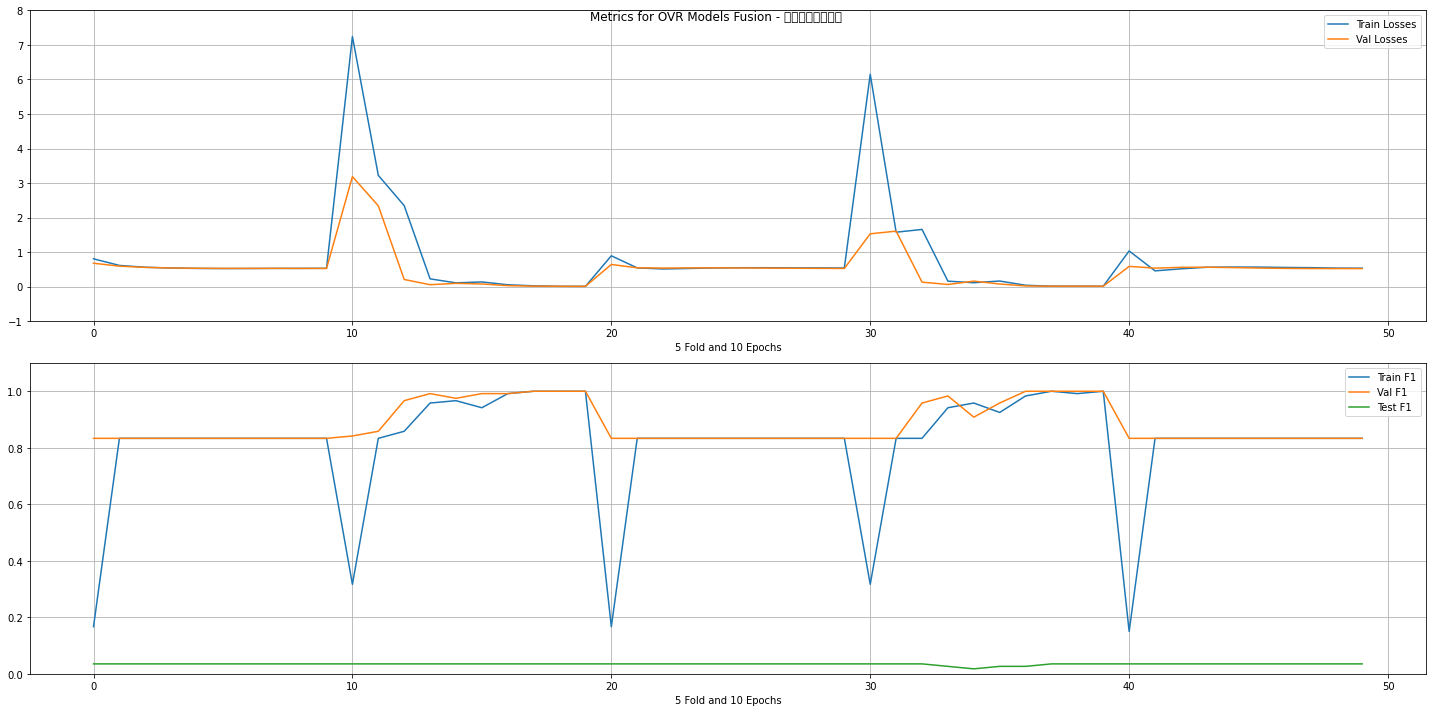

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
7,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
8,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
9,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
7,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
9,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
8,0.991667,1.000000,0.035088,0.991667,1.000000,0.035088,0.991667,1.000000,0.035088
6,0.983333,1.000000,0.026316,0.983333,1.000000,0.026316,0.983333,1.000000,0.026316
6,0.991667,0.991667,0.035088,0.991667,0.991667,0.035088,0.991667,0.991667,0.035088
3,0.958333,0.991667,0.035088,0.958333,0.991667,0.035088,0.958333,0.991667,0.035088
5,0.941667,0.991667,0.035088,0.941667,0.991667,0.035088,0.941667,0.991667,0.035088


Training for దేసాళం with 36 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 172/44


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.761 / Validation Loss : 0.599 [Time : 13.520856 seconds]
Epoch 2/10 : Training Loss: 0.529 / Validation Loss : 0.503 [Time : 13.502078 seconds]
Epoch 3/10 : Training Loss: 0.463 / Validation Loss : 0.460 [Time : 13.530001 seconds]
Epoch 4/10 : Training Loss: 0.437 / Validation Loss : 0.443 [Time : 13.390848 seconds]
Epoch 5/10 : Training Loss: 0.430 / Validation Loss : 0.438 [Time : 13.413604 seconds]
Epoch 6/10 : Training Loss: 0.433 / Validation Loss : 0.437 [Time : 13.435242 seconds]
Epoch 7/10 : Training Loss: 0.438 / Validation Loss : 0.436 [Time : 13.493746 seconds]
Epoch 8/10 : Training Loss: 0.439 / Validation Loss : 0.434 [Time : 13.499566 seconds]
Epoch 9/10 : Training Loss: 0.440 / Validation Loss : 0.433 [Time : 13.461445 seconds]
Epoch 10/10 : Training Loss: 0.434 / Validation Loss : 0.432 [Time : 13.408105 seconds]
*** Confusion Matrix - Training ***
[[144   0]
 [ 28   0]]
*** Confusion Matrix - Validation ***
[[144 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 5.604 / Validation Loss : 6.242 [Time : 12.544258 seconds]
Epoch 2/10 : Training Loss: 6.269 / Validation Loss : 5.195 [Time : 12.544384 seconds]
Epoch 3/10 : Training Loss: 5.136 / Validation Loss : 1.232 [Time : 12.694549 seconds]
Epoch 4/10 : Training Loss: 1.522 / Validation Loss : 0.177 [Time : 13.732709 seconds]
Epoch 5/10 : Training Loss: 0.362 / Validation Loss : 0.070 [Time : 13.661379 seconds]
Epoch 6/10 : Training Loss: 0.024 / Validation Loss : 0.042 [Time : 13.534066 seconds]
Epoch 7/10 : Training Loss: 0.043 / Validation Loss : 0.065 [Time : 12.616603 seconds]
Epoch 8/10 : Training Loss: 0.063 / Validation Loss : 0.048 [Time : 12.596435 seconds]
Epoch 9/10 : Training Loss: 0.066 / Validation Loss : 0.018 [Time : 13.413915 seconds]
Epoch 10/10 : Training Loss: 0.026 / Validation Loss : 0.008 [Time : 13.512902 seconds]
*** Confusion Matrix - Training ***
[[144   0]
 [  4  25]]
*** Confusion Matrix - Validation ***
[[144   0]
 [  0  29]]
Fold 2 : 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.803 / Validation Loss : 0.516 [Time : 12.614626 seconds]
Epoch 2/10 : Training Loss: 0.434 / Validation Loss : 0.450 [Time : 12.572846 seconds]
Epoch 3/10 : Training Loss: 0.427 / Validation Loss : 0.449 [Time : 12.623783 seconds]
Epoch 4/10 : Training Loss: 0.444 / Validation Loss : 0.452 [Time : 12.537374 seconds]
Epoch 5/10 : Training Loss: 0.454 / Validation Loss : 0.451 [Time : 12.554325 seconds]
Epoch 6/10 : Training Loss: 0.460 / Validation Loss : 0.447 [Time : 12.643242 seconds]
Epoch 7/10 : Training Loss: 0.458 / Validation Loss : 0.443 [Time : 12.637009 seconds]
Epoch 8/10 : Training Loss: 0.454 / Validation Loss : 0.439 [Time : 12.612044 seconds]
Epoch 9/10 : Training Loss: 0.449 / Validation Loss : 0.436 [Time : 12.686057 seconds]
Epoch 10/10 : Training Loss: 0.447 / Validation Loss : 0.433 [Time : 12.790158 seconds]
*** Confusion Matrix - Training ***
[[144   0]
 [ 29   0]]
*** Confusion Matrix - Validation ***
[[144   0]
 [ 29   0]]
Fold 3 : 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 4.687 / Validation Loss : 3.560 [Time : 12.602635 seconds]
Epoch 2/10 : Training Loss: 3.649 / Validation Loss : 3.726 [Time : 12.642543 seconds]
Epoch 3/10 : Training Loss: 3.722 / Validation Loss : 1.601 [Time : 12.629617 seconds]
Epoch 4/10 : Training Loss: 1.638 / Validation Loss : 0.124 [Time : 12.636586 seconds]
Epoch 5/10 : Training Loss: 0.513 / Validation Loss : 0.224 [Time : 12.801617 seconds]
Epoch 6/10 : Training Loss: 0.078 / Validation Loss : 0.060 [Time : 12.596169 seconds]
Epoch 7/10 : Training Loss: 0.062 / Validation Loss : 0.070 [Time : 12.573537 seconds]
Epoch 8/10 : Training Loss: 0.076 / Validation Loss : 0.039 [Time : 12.650045 seconds]
Epoch 9/10 : Training Loss: 0.052 / Validation Loss : 0.023 [Time : 12.60658 seconds]
Epoch 10/10 : Training Loss: 0.031 / Validation Loss : 0.021 [Time : 12.573076 seconds]
*** Confusion Matrix - Training ***
[[144   0]
 [  2  27]]
*** Confusion Matrix - Validation ***
[[144   0]
 [  0  29]]
Fold 4 : 1

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.871 / Validation Loss : 0.453 [Time : 12.554042 seconds]
Epoch 2/10 : Training Loss: 0.387 / Validation Loss : 0.457 [Time : 12.538498 seconds]
Epoch 3/10 : Training Loss: 0.452 / Validation Loss : 0.470 [Time : 12.701956 seconds]
Epoch 4/10 : Training Loss: 0.475 / Validation Loss : 0.464 [Time : 12.558925 seconds]
Epoch 5/10 : Training Loss: 0.476 / Validation Loss : 0.452 [Time : 12.542047 seconds]
Epoch 6/10 : Training Loss: 0.470 / Validation Loss : 0.443 [Time : 12.576121 seconds]
Epoch 7/10 : Training Loss: 0.462 / Validation Loss : 0.439 [Time : 12.654385 seconds]
Epoch 8/10 : Training Loss: 0.452 / Validation Loss : 0.438 [Time : 12.757067 seconds]
Epoch 9/10 : Training Loss: 0.446 / Validation Loss : 0.437 [Time : 12.825453 seconds]
Epoch 10/10 : Training Loss: 0.441 / Validation Loss : 0.435 [Time : 12.543343 seconds]
*** Confusion Matrix - Training ***
[[144   0]
 [ 29   0]]
*** Confusion Matrix - Validation ***
[[144   0]
 [ 29   0]]
Fold 5 : 

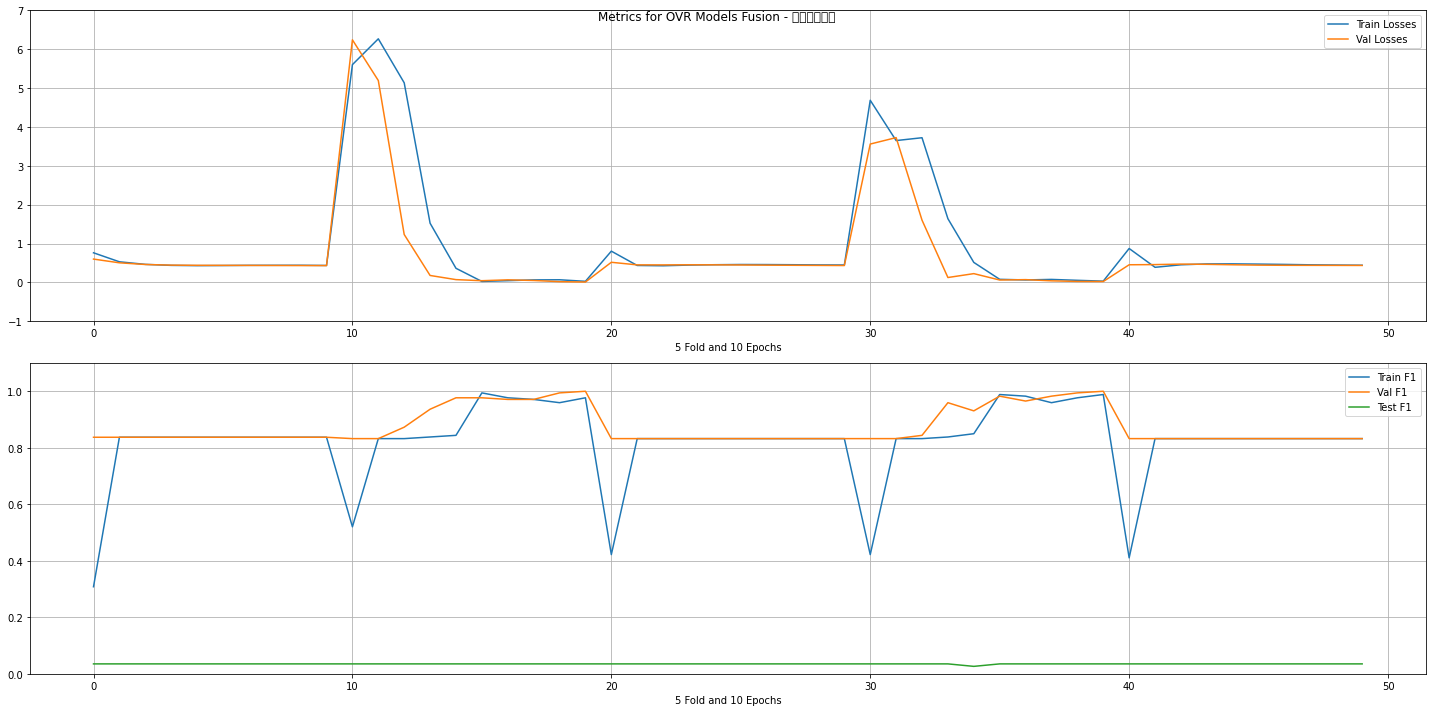

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
9,0.988439,1.000000,0.035088,0.988439,1.000000,0.035088,0.988439,1.000000,0.035088
9,0.976879,1.000000,0.035088,0.976879,1.000000,0.035088,0.976879,1.000000,0.035088
8,0.976879,0.994220,0.035088,0.976879,0.994220,0.035088,0.976879,0.994220,0.035088
8,0.959538,0.994220,0.035088,0.959538,0.994220,0.035088,0.959538,0.994220,0.035088
5,0.988439,0.982659,0.035088,0.988439,0.982659,0.035088,0.988439,0.982659,0.035088
7,0.959538,0.982659,0.035088,0.959538,0.982659,0.035088,0.959538,0.982659,0.035088
5,0.994220,0.976879,0.035088,0.994220,0.976879,0.035088,0.994220,0.976879,0.035088
4,0.843931,0.976879,0.035088,0.843931,0.976879,0.035088,0.843931,0.976879,0.035088
6,0.976879,0.971098,0.035088,0.976879,0.971098,0.035088,0.976879,0.971098,0.035088
7,0.971098,0.971098,0.035088,0.971098,0.971098,0.035088,0.971098,0.971098,0.035088


Training for ధన్నాసి with 19 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 91/23


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.814 / Validation Loss : 0.713 [Time : 12.152658 seconds]
Epoch 2/10 : Training Loss: 0.665 / Validation Loss : 0.642 [Time : 12.098339 seconds]
Epoch 3/10 : Training Loss: 0.613 / Validation Loss : 0.610 [Time : 12.13103 seconds]
Epoch 4/10 : Training Loss: 0.592 / Validation Loss : 0.596 [Time : 12.143529 seconds]
Epoch 5/10 : Training Loss: 0.584 / Validation Loss : 0.588 [Time : 12.246551 seconds]
Epoch 6/10 : Training Loss: 0.580 / Validation Loss : 0.584 [Time : 12.182335 seconds]
Epoch 7/10 : Training Loss: 0.579 / Validation Loss : 0.583 [Time : 12.121245 seconds]
Epoch 8/10 : Training Loss: 0.582 / Validation Loss : 0.582 [Time : 12.092364 seconds]
Epoch 9/10 : Training Loss: 0.578 / Validation Loss : 0.582 [Time : 12.176272 seconds]
Epoch 10/10 : Training Loss: 0.584 / Validation Loss : 0.583 [Time : 11.235816 seconds]
*** Confusion Matrix - Training ***
[[76  0]
 [15  0]]
*** Confusion Matrix - Validation ***
[[76  0]
 [

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 4.793 / Validation Loss : 0.655 [Time : 11.223205 seconds]
Epoch 2/10 : Training Loss: 0.830 / Validation Loss : 0.922 [Time : 11.270137 seconds]
Epoch 3/10 : Training Loss: 0.972 / Validation Loss : 0.144 [Time : 12.235044 seconds]
Epoch 4/10 : Training Loss: 0.120 / Validation Loss : 0.012 [Time : 12.504009 seconds]
Epoch 5/10 : Training Loss: 0.025 / Validation Loss : 0.001 [Time : 12.236696 seconds]
Epoch 6/10 : Training Loss: 0.002 / Validation Loss : 0.002 [Time : 11.285801 seconds]
Epoch 7/10 : Training Loss: 0.002 / Validation Loss : 0.002 [Time : 11.299575 seconds]
Epoch 8/10 : Training Loss: 0.003 / Validation Loss : 0.002 [Time : 11.298241 seconds]
Epoch 9/10 : Training Loss: 0.003 / Validation Loss : 0.003 [Time : 11.24254 seconds]
Epoch 10/10 : Training Loss: 0.003 / Validation Loss : 0.003 [Time : 11.242356 seconds]
*** Confusion Matrix - Training ***
[[76  0]
 [ 1 14]]
*** Confusion Matrix - Validation ***
[[76  0]
 [ 0 15]]
Fold 2 : 116.70033

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.918 / Validation Loss : 0.703 [Time : 11.312279 seconds]
Epoch 2/10 : Training Loss: 0.608 / Validation Loss : 0.595 [Time : 11.30156 seconds]
Epoch 3/10 : Training Loss: 0.558 / Validation Loss : 0.583 [Time : 11.377245 seconds]
Epoch 4/10 : Training Loss: 0.570 / Validation Loss : 0.587 [Time : 11.306151 seconds]
Epoch 5/10 : Training Loss: 0.583 / Validation Loss : 0.591 [Time : 11.26289 seconds]
Epoch 6/10 : Training Loss: 0.590 / Validation Loss : 0.591 [Time : 11.292535 seconds]
Epoch 7/10 : Training Loss: 0.597 / Validation Loss : 0.589 [Time : 11.284767 seconds]
Epoch 8/10 : Training Loss: 0.596 / Validation Loss : 0.585 [Time : 11.272496 seconds]
Epoch 9/10 : Training Loss: 0.591 / Validation Loss : 0.581 [Time : 11.34833 seconds]
Epoch 10/10 : Training Loss: 0.589 / Validation Loss : 0.578 [Time : 11.277206 seconds]
*** Confusion Matrix - Training ***
[[76  0]
 [15  0]]
*** Confusion Matrix - Validation ***
[[76  0]
 [15  0]]
Fold 3 : 113.880955 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.556 / Validation Loss : 1.696 [Time : 11.234621 seconds]
Epoch 2/10 : Training Loss: 1.777 / Validation Loss : 0.927 [Time : 11.294489 seconds]
Epoch 3/10 : Training Loss: 1.073 / Validation Loss : 0.046 [Time : 11.27254 seconds]
Epoch 4/10 : Training Loss: 0.071 / Validation Loss : 0.056 [Time : 11.291516 seconds]
Epoch 5/10 : Training Loss: 0.118 / Validation Loss : 0.088 [Time : 11.272746 seconds]
Epoch 6/10 : Training Loss: 0.104 / Validation Loss : 0.044 [Time : 11.311265 seconds]
Epoch 7/10 : Training Loss: 0.030 / Validation Loss : 0.025 [Time : 11.251591 seconds]
Epoch 8/10 : Training Loss: 0.022 / Validation Loss : 0.022 [Time : 11.277074 seconds]
Epoch 9/10 : Training Loss: 0.020 / Validation Loss : 0.022 [Time : 11.26071 seconds]
Epoch 10/10 : Training Loss: 0.023 / Validation Loss : 0.022 [Time : 11.268337 seconds]
*** Confusion Matrix - Training ***
[[76  0]
 [ 0 15]]
*** Confusion Matrix - Validation ***
[[76  0]
 [ 1 14]]
Fold 4 : 113.55399 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 1.112 / Validation Loss : 0.717 [Time : 11.280218 seconds]
Epoch 2/10 : Training Loss: 0.560 / Validation Loss : 0.590 [Time : 11.26146 seconds]
Epoch 3/10 : Training Loss: 0.557 / Validation Loss : 0.611 [Time : 11.253681 seconds]
Epoch 4/10 : Training Loss: 0.606 / Validation Loss : 0.624 [Time : 11.266776 seconds]
Epoch 5/10 : Training Loss: 0.626 / Validation Loss : 0.623 [Time : 11.303763 seconds]
Epoch 6/10 : Training Loss: 0.628 / Validation Loss : 0.612 [Time : 11.309886 seconds]
Epoch 7/10 : Training Loss: 0.626 / Validation Loss : 0.599 [Time : 11.29311 seconds]
Epoch 8/10 : Training Loss: 0.615 / Validation Loss : 0.589 [Time : 11.310166 seconds]
Epoch 9/10 : Training Loss: 0.607 / Validation Loss : 0.584 [Time : 11.317886 seconds]
Epoch 10/10 : Training Loss: 0.598 / Validation Loss : 0.582 [Time : 11.357996 seconds]
*** Confusion Matrix - Training ***
[[76  0]
 [16  0]]
*** Confusion Matrix - Validation ***
[[76  0]
 [16  0]]
Fold 5 : 113.775196

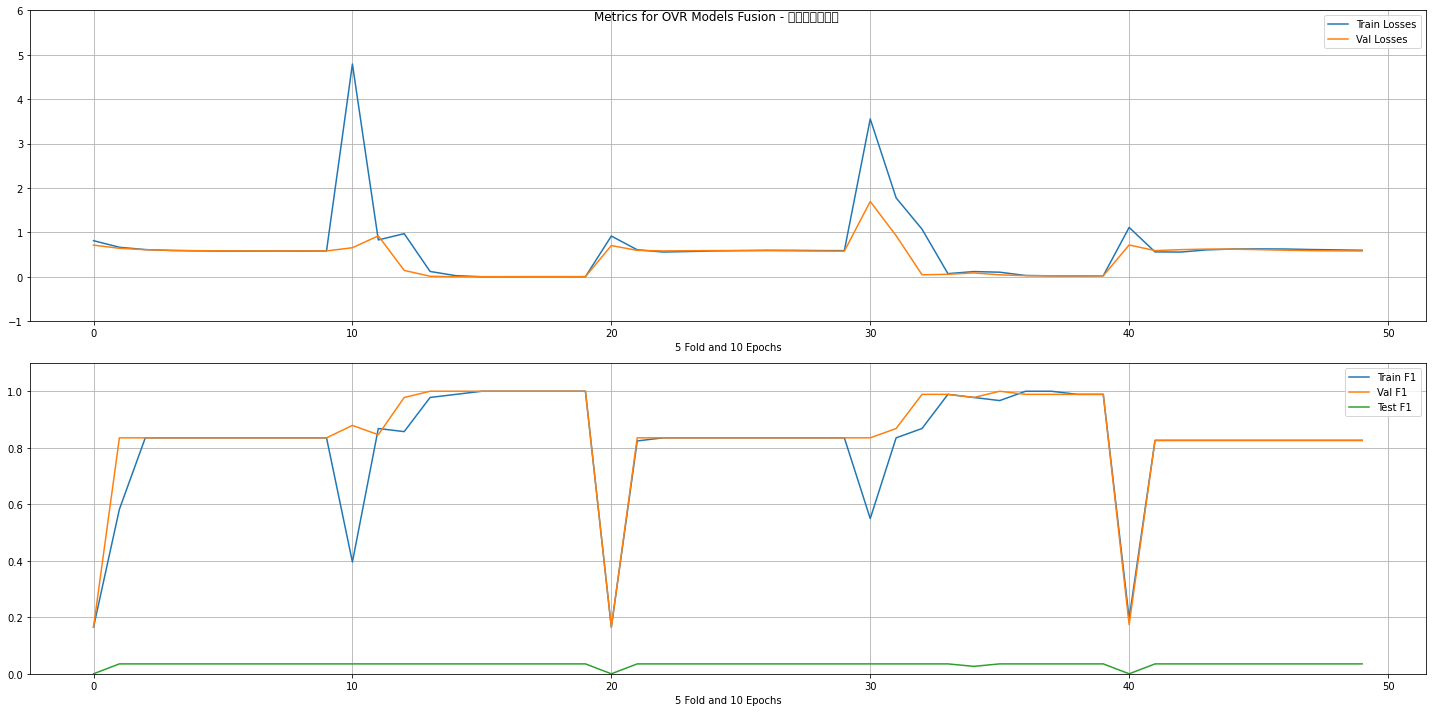

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
5,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
6,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
7,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
8,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
9,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
4,0.989011,1.000000,0.035088,0.989011,1.000000,0.035088,0.989011,1.000000,0.035088
3,0.978022,1.000000,0.035088,0.978022,1.000000,0.035088,0.978022,1.000000,0.035088
5,0.967033,1.000000,0.035088,0.967033,1.000000,0.035088,0.967033,1.000000,0.035088
6,1.000000,0.989011,0.035088,1.000000,0.989011,0.035088,1.000000,0.989011,0.035088
7,1.000000,0.989011,0.035088,1.000000,0.989011,0.035088,1.000000,0.989011,0.035088


Training for నాట with 24 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 115/29


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.804 / Validation Loss : 0.676 [Time : 12.507429 seconds]
Epoch 2/10 : Training Loss: 0.613 / Validation Loss : 0.590 [Time : 12.581727 seconds]
Epoch 3/10 : Training Loss: 0.559 / Validation Loss : 0.555 [Time : 12.51905 seconds]
Epoch 4/10 : Training Loss: 0.535 / Validation Loss : 0.537 [Time : 12.548061 seconds]
Epoch 5/10 : Training Loss: 0.524 / Validation Loss : 0.529 [Time : 12.572145 seconds]
Epoch 6/10 : Training Loss: 0.519 / Validation Loss : 0.527 [Time : 12.487522 seconds]
Epoch 7/10 : Training Loss: 0.519 / Validation Loss : 0.526 [Time : 12.56925 seconds]
Epoch 8/10 : Training Loss: 0.524 / Validation Loss : 0.526 [Time : 11.66901 seconds]
Epoch 9/10 : Training Loss: 0.527 / Validation Loss : 0.527 [Time : 11.61383 seconds]
Epoch 10/10 : Training Loss: 0.528 / Validation Loss : 0.526 [Time : 11.677974 seconds]
*** Confusion Matrix - Training ***
[[96  0]
 [19  0]]
*** Confusion Matrix - Validation ***
[[96  0]
 [19 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 6.687 / Validation Loss : 2.676 [Time : 11.628829 seconds]
Epoch 2/10 : Training Loss: 2.838 / Validation Loss : 3.060 [Time : 11.712157 seconds]
Epoch 3/10 : Training Loss: 3.147 / Validation Loss : 0.623 [Time : 11.620125 seconds]
Epoch 4/10 : Training Loss: 0.632 / Validation Loss : 0.041 [Time : 12.463004 seconds]
Epoch 5/10 : Training Loss: 0.324 / Validation Loss : 0.185 [Time : 11.657603 seconds]
Epoch 6/10 : Training Loss: 0.188 / Validation Loss : 0.087 [Time : 11.577314 seconds]
Epoch 7/10 : Training Loss: 0.057 / Validation Loss : 0.026 [Time : 12.414415 seconds]
Epoch 8/10 : Training Loss: 0.027 / Validation Loss : 0.016 [Time : 12.57116 seconds]
Epoch 9/10 : Training Loss: 0.020 / Validation Loss : 0.013 [Time : 12.519092 seconds]
Epoch 10/10 : Training Loss: 0.012 / Validation Loss : 0.011 [Time : 12.479315 seconds]
*** Confusion Matrix - Training ***
[[96  0]
 [ 0 19]]
*** Confusion Matrix - Validation ***
[[96  0]
 [ 0 19]]
Fold 2 : 121.48947

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.884 / Validation Loss : 0.632 [Time : 11.641948 seconds]
Epoch 2/10 : Training Loss: 0.534 / Validation Loss : 0.537 [Time : 11.620541 seconds]
Epoch 3/10 : Training Loss: 0.509 / Validation Loss : 0.532 [Time : 11.612383 seconds]
Epoch 4/10 : Training Loss: 0.519 / Validation Loss : 0.536 [Time : 11.622137 seconds]
Epoch 5/10 : Training Loss: 0.539 / Validation Loss : 0.537 [Time : 11.776943 seconds]
Epoch 6/10 : Training Loss: 0.539 / Validation Loss : 0.535 [Time : 11.695916 seconds]
Epoch 7/10 : Training Loss: 0.544 / Validation Loss : 0.530 [Time : 11.67459 seconds]
Epoch 8/10 : Training Loss: 0.536 / Validation Loss : 0.526 [Time : 11.736946 seconds]
Epoch 9/10 : Training Loss: 0.535 / Validation Loss : 0.522 [Time : 11.656128 seconds]
Epoch 10/10 : Training Loss: 0.529 / Validation Loss : 0.519 [Time : 11.622108 seconds]
*** Confusion Matrix - Training ***
[[96  0]
 [19  0]]
*** Confusion Matrix - Validation ***
[[96  0]
 [19  0]]
Fold 3 : 117.54382

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 6.067 / Validation Loss : 2.259 [Time : 11.635343 seconds]
Epoch 2/10 : Training Loss: 2.150 / Validation Loss : 2.544 [Time : 11.590064 seconds]
Epoch 3/10 : Training Loss: 2.605 / Validation Loss : 0.426 [Time : 11.598674 seconds]
Epoch 4/10 : Training Loss: 0.470 / Validation Loss : 0.064 [Time : 11.564589 seconds]
Epoch 5/10 : Training Loss: 0.330 / Validation Loss : 0.181 [Time : 11.67319 seconds]
Epoch 6/10 : Training Loss: 0.114 / Validation Loss : 0.050 [Time : 11.587794 seconds]
Epoch 7/10 : Training Loss: 0.037 / Validation Loss : 0.029 [Time : 11.644542 seconds]
Epoch 8/10 : Training Loss: 0.023 / Validation Loss : 0.028 [Time : 11.768314 seconds]
Epoch 9/10 : Training Loss: 0.024 / Validation Loss : 0.027 [Time : 11.875049 seconds]
Epoch 10/10 : Training Loss: 0.025 / Validation Loss : 0.023 [Time : 11.600917 seconds]
*** Confusion Matrix - Training ***
[[96  0]
 [ 1 18]]
*** Confusion Matrix - Validation ***
[[96  0]
 [ 1 18]]
Fold 4 : 117.34872

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 1.038 / Validation Loss : 0.583 [Time : 11.620354 seconds]
Epoch 2/10 : Training Loss: 0.458 / Validation Loss : 0.537 [Time : 11.593043 seconds]
Epoch 3/10 : Training Loss: 0.521 / Validation Loss : 0.559 [Time : 11.729148 seconds]
Epoch 4/10 : Training Loss: 0.559 / Validation Loss : 0.562 [Time : 11.640348 seconds]
Epoch 5/10 : Training Loss: 0.571 / Validation Loss : 0.551 [Time : 11.613588 seconds]
Epoch 6/10 : Training Loss: 0.569 / Validation Loss : 0.538 [Time : 11.66857 seconds]
Epoch 7/10 : Training Loss: 0.558 / Validation Loss : 0.529 [Time : 11.61824 seconds]
Epoch 8/10 : Training Loss: 0.547 / Validation Loss : 0.525 [Time : 11.606309 seconds]
Epoch 9/10 : Training Loss: 0.542 / Validation Loss : 0.524 [Time : 11.710651 seconds]
Epoch 10/10 : Training Loss: 0.532 / Validation Loss : 0.523 [Time : 11.699484 seconds]
*** Confusion Matrix - Training ***
[[96  0]
 [20  0]]
*** Confusion Matrix - Validation ***
[[96  0]
 [20  0]]
Fold 5 : 117.313982

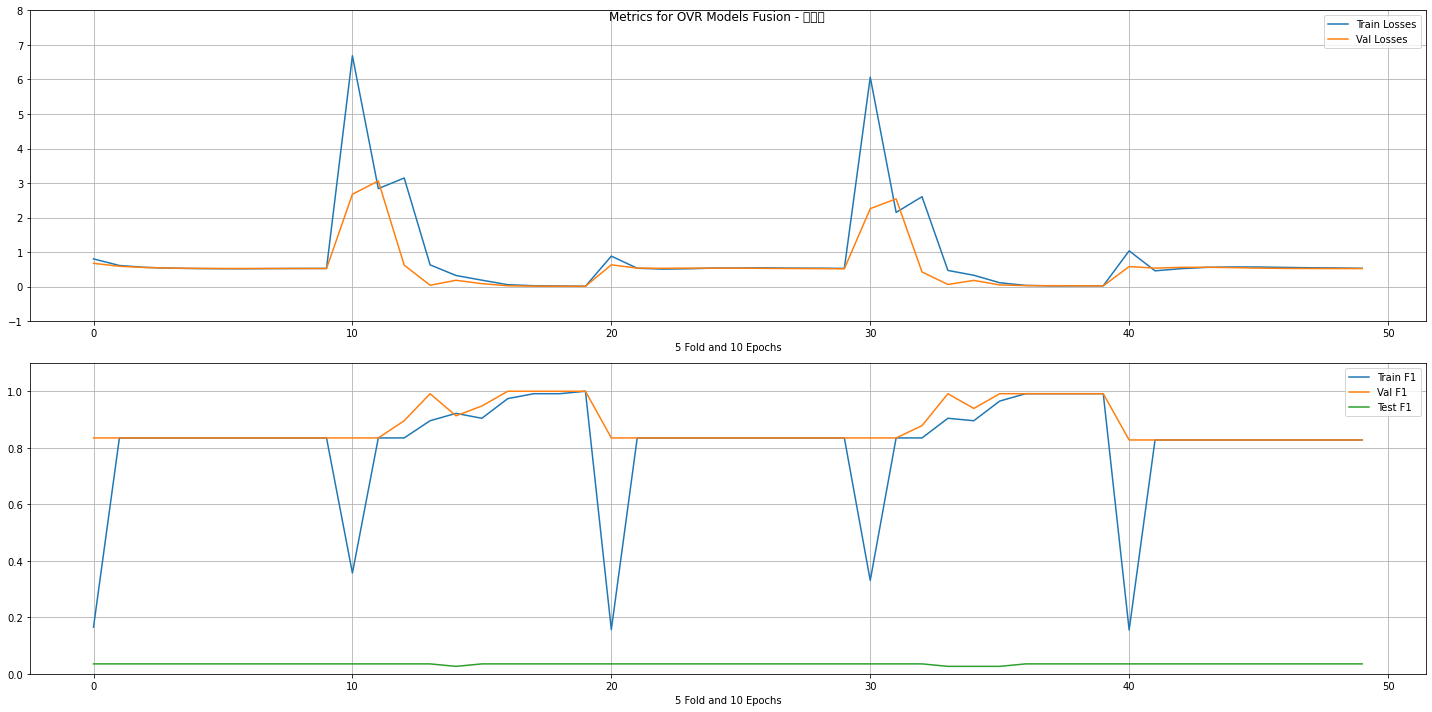

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
9,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
7,0.991304,1.000000,0.035088,0.991304,1.000000,0.035088,0.991304,1.000000,0.035088
8,0.991304,1.000000,0.035088,0.991304,1.000000,0.035088,0.991304,1.000000,0.035088
6,0.973913,1.000000,0.035088,0.973913,1.000000,0.035088,0.973913,1.000000,0.035088
6,0.991304,0.991304,0.035088,0.991304,0.991304,0.035088,0.991304,0.991304,0.035088
7,0.991304,0.991304,0.035088,0.991304,0.991304,0.035088,0.991304,0.991304,0.035088
8,0.991304,0.991304,0.035088,0.991304,0.991304,0.035088,0.991304,0.991304,0.035088
9,0.991304,0.991304,0.035088,0.991304,0.991304,0.035088,0.991304,0.991304,0.035088
5,0.965217,0.991304,0.026316,0.965217,0.991304,0.026316,0.965217,0.991304,0.026316
3,0.904348,0.991304,0.026316,0.904348,0.991304,0.026316,0.904348,0.991304,0.026316


Training for నాదరామక్రియ with 10 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 48/12


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.792 / Validation Loss : 0.725 [Time : 11.411098 seconds]
Epoch 2/10 : Training Loss: 0.692 / Validation Loss : 0.666 [Time : 11.591054 seconds]
Epoch 3/10 : Training Loss: 0.641 / Validation Loss : 0.636 [Time : 11.623206 seconds]
Epoch 4/10 : Training Loss: 0.622 / Validation Loss : 0.625 [Time : 11.503607 seconds]
Epoch 5/10 : Training Loss: 0.615 / Validation Loss : 0.621 [Time : 11.51441 seconds]
Epoch 6/10 : Training Loss: 0.618 / Validation Loss : 0.620 [Time : 11.481952 seconds]
Epoch 7/10 : Training Loss: 0.614 / Validation Loss : 0.620 [Time : 10.638716 seconds]
Epoch 8/10 : Training Loss: 0.621 / Validation Loss : 0.621 [Time : 10.632625 seconds]
Epoch 9/10 : Training Loss: 0.624 / Validation Loss : 0.621 [Time : 10.566525 seconds]
Epoch 10/10 : Training Loss: 0.622 / Validation Loss : 0.621 [Time : 10.569388 seconds]
*** Confusion Matrix - Training ***
[[40  0]
 [ 8  0]]
*** Confusion Matrix - Validation ***
[[40  0]
 [

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 5.706 / Validation Loss : 0.240 [Time : 11.456175 seconds]
Epoch 2/10 : Training Loss: 0.126 / Validation Loss : 0.757 [Time : 10.587298 seconds]
Epoch 3/10 : Training Loss: 0.970 / Validation Loss : 0.591 [Time : 10.569277 seconds]
Epoch 4/10 : Training Loss: 0.620 / Validation Loss : 0.024 [Time : 11.390055 seconds]
Epoch 5/10 : Training Loss: 0.145 / Validation Loss : 0.001 [Time : 11.43092 seconds]
Epoch 6/10 : Training Loss: 0.000 / Validation Loss : 0.000 [Time : 11.488126 seconds]
Epoch 7/10 : Training Loss: 0.000 / Validation Loss : 0.000 [Time : 11.426132 seconds]
Epoch 8/10 : Training Loss: 0.000 / Validation Loss : 0.000 [Time : 11.426561 seconds]
Epoch 9/10 : Training Loss: 0.000 / Validation Loss : 0.000 [Time : 10.536249 seconds]
Epoch 10/10 : Training Loss: 0.000 / Validation Loss : 0.000 [Time : 10.549681 seconds]
*** Confusion Matrix - Training ***
[[40  0]
 [ 0  8]]
*** Confusion Matrix - Validation ***
[[40  0]
 [ 0  8]]
Fold 2 : 111.69580

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.877 / Validation Loss : 0.739 [Time : 10.572276 seconds]
Epoch 2/10 : Training Loss: 0.676 / Validation Loss : 0.637 [Time : 10.525587 seconds]
Epoch 3/10 : Training Loss: 0.602 / Validation Loss : 0.619 [Time : 10.513336 seconds]
Epoch 4/10 : Training Loss: 0.603 / Validation Loss : 0.625 [Time : 10.527761 seconds]
Epoch 5/10 : Training Loss: 0.625 / Validation Loss : 0.630 [Time : 10.538954 seconds]
Epoch 6/10 : Training Loss: 0.633 / Validation Loss : 0.630 [Time : 10.614584 seconds]
Epoch 7/10 : Training Loss: 0.640 / Validation Loss : 0.626 [Time : 10.589132 seconds]
Epoch 8/10 : Training Loss: 0.629 / Validation Loss : 0.620 [Time : 10.784597 seconds]
Epoch 9/10 : Training Loss: 0.633 / Validation Loss : 0.612 [Time : 10.521076 seconds]
Epoch 10/10 : Training Loss: 0.623 / Validation Loss : 0.606 [Time : 10.524873 seconds]
*** Confusion Matrix - Training ***
[[40  0]
 [ 8  0]]
*** Confusion Matrix - Validation ***
[[40  0]
 [ 8  0]]
Fold 3 : 106.5316

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 2.039 / Validation Loss : 0.225 [Time : 10.515446 seconds]
Epoch 2/10 : Training Loss: 0.172 / Validation Loss : 0.386 [Time : 10.60308 seconds]
Epoch 3/10 : Training Loss: 0.412 / Validation Loss : 0.016 [Time : 10.545437 seconds]
Epoch 4/10 : Training Loss: 0.023 / Validation Loss : 0.002 [Time : 10.525275 seconds]
Epoch 5/10 : Training Loss: 0.002 / Validation Loss : 0.001 [Time : 10.563179 seconds]
Epoch 6/10 : Training Loss: 0.001 / Validation Loss : 0.001 [Time : 10.585512 seconds]
Epoch 7/10 : Training Loss: 0.001 / Validation Loss : 0.001 [Time : 10.531495 seconds]
Epoch 8/10 : Training Loss: 0.001 / Validation Loss : 0.001 [Time : 10.57495 seconds]
Epoch 9/10 : Training Loss: 0.001 / Validation Loss : 0.001 [Time : 10.592687 seconds]
Epoch 10/10 : Training Loss: 0.001 / Validation Loss : 0.001 [Time : 10.539467 seconds]
*** Confusion Matrix - Training ***
[[40  0]
 [ 0  8]]
*** Confusion Matrix - Validation ***
[[40  0]
 [ 0  8]]
Fold 4 : 106.405061

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 1.074 / Validation Loss : 0.802 [Time : 10.552143 seconds]
Epoch 2/10 : Training Loss: 0.660 / Validation Loss : 0.621 [Time : 10.625244 seconds]
Epoch 3/10 : Training Loss: 0.576 / Validation Loss : 0.650 [Time : 10.541333 seconds]
Epoch 4/10 : Training Loss: 0.636 / Validation Loss : 0.680 [Time : 10.555588 seconds]
Epoch 5/10 : Training Loss: 0.686 / Validation Loss : 0.682 [Time : 10.544968 seconds]
Epoch 6/10 : Training Loss: 0.698 / Validation Loss : 0.666 [Time : 10.506739 seconds]
Epoch 7/10 : Training Loss: 0.685 / Validation Loss : 0.645 [Time : 10.552548 seconds]
Epoch 8/10 : Training Loss: 0.663 / Validation Loss : 0.628 [Time : 10.508169 seconds]
Epoch 9/10 : Training Loss: 0.654 / Validation Loss : 0.619 [Time : 10.550726 seconds]
Epoch 10/10 : Training Loss: 0.637 / Validation Loss : 0.619 [Time : 10.573407 seconds]
*** Confusion Matrix - Training ***
[[40  0]
 [ 8  0]]
*** Confusion Matrix - Validation ***
[[40  0]
 [ 8  0]]
Fold 5 : 106.3241

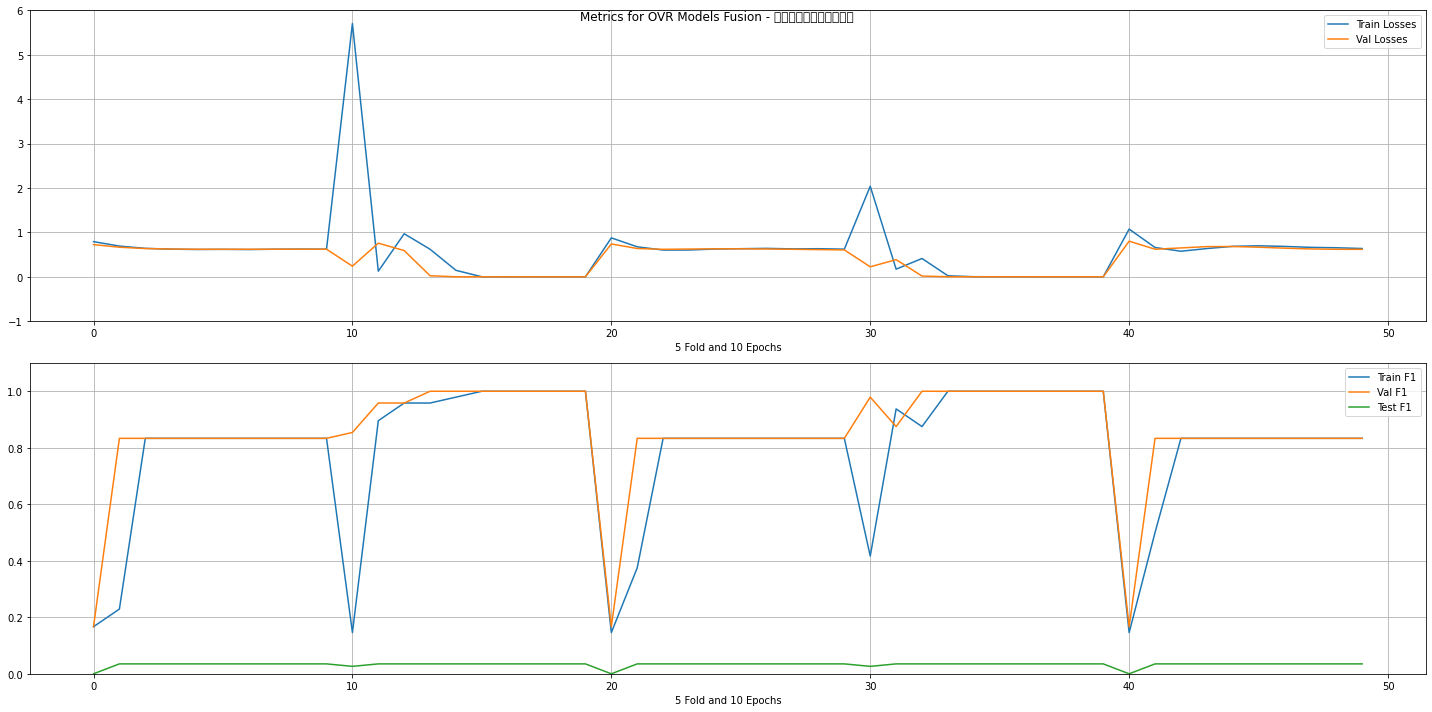

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
5,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
6,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
7,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
8,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
9,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
3,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
4,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
5,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
6,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
7,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088


Training for పాడి with 45 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 216/54


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.788 / Validation Loss : 0.631 [Time : 14.113621 seconds]
Epoch 2/10 : Training Loss: 0.564 / Validation Loss : 0.548 [Time : 14.115424 seconds]
Epoch 3/10 : Training Loss: 0.510 / Validation Loss : 0.514 [Time : 14.076886 seconds]
Epoch 4/10 : Training Loss: 0.494 / Validation Loss : 0.503 [Time : 14.000509 seconds]
Epoch 5/10 : Training Loss: 0.493 / Validation Loss : 0.501 [Time : 13.998552 seconds]
Epoch 6/10 : Training Loss: 0.497 / Validation Loss : 0.501 [Time : 14.039806 seconds]
Epoch 7/10 : Training Loss: 0.501 / Validation Loss : 0.500 [Time : 14.046863 seconds]
Epoch 8/10 : Training Loss: 0.504 / Validation Loss : 0.499 [Time : 14.013588 seconds]
Epoch 9/10 : Training Loss: 0.502 / Validation Loss : 0.497 [Time : 13.989525 seconds]
Epoch 10/10 : Training Loss: 0.499 / Validation Loss : 0.494 [Time : 14.383778 seconds]
*** Confusion Matrix - Training ***
[[180   0]
 [ 36   0]]
*** Confusion Matrix - Validation ***
[[180 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 6.151 / Validation Loss : 5.942 [Time : 13.190015 seconds]
Epoch 2/10 : Training Loss: 5.981 / Validation Loss : 4.722 [Time : 13.205591 seconds]
Epoch 3/10 : Training Loss: 4.800 / Validation Loss : 0.882 [Time : 13.221077 seconds]
Epoch 4/10 : Training Loss: 1.000 / Validation Loss : 0.318 [Time : 14.034929 seconds]
Epoch 5/10 : Training Loss: 0.401 / Validation Loss : 0.060 [Time : 14.39219 seconds]
Epoch 6/10 : Training Loss: 0.044 / Validation Loss : 0.098 [Time : 13.233083 seconds]
Epoch 7/10 : Training Loss: 0.092 / Validation Loss : 0.121 [Time : 13.260365 seconds]
Epoch 8/10 : Training Loss: 0.130 / Validation Loss : 0.049 [Time : 14.19565 seconds]
Epoch 9/10 : Training Loss: 0.055 / Validation Loss : 0.023 [Time : 14.16821 seconds]
Epoch 10/10 : Training Loss: 0.024 / Validation Loss : 0.013 [Time : 14.129631 seconds]
*** Confusion Matrix - Training ***
[[180   0]
 [  2  34]]
*** Confusion Matrix - Validation ***
[[180   0]
 [  1  35]]
Fold 2 : 137

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.827 / Validation Loss : 0.550 [Time : 13.431895 seconds]
Epoch 2/10 : Training Loss: 0.472 / Validation Loss : 0.503 [Time : 13.23843 seconds]
Epoch 3/10 : Training Loss: 0.487 / Validation Loss : 0.508 [Time : 13.238624 seconds]
Epoch 4/10 : Training Loss: 0.508 / Validation Loss : 0.510 [Time : 13.214157 seconds]
Epoch 5/10 : Training Loss: 0.520 / Validation Loss : 0.506 [Time : 13.193989 seconds]
Epoch 6/10 : Training Loss: 0.519 / Validation Loss : 0.501 [Time : 13.248431 seconds]
Epoch 7/10 : Training Loss: 0.513 / Validation Loss : 0.498 [Time : 13.223026 seconds]
Epoch 8/10 : Training Loss: 0.507 / Validation Loss : 0.496 [Time : 13.374938 seconds]
Epoch 9/10 : Training Loss: 0.505 / Validation Loss : 0.494 [Time : 13.190894 seconds]
Epoch 10/10 : Training Loss: 0.500 / Validation Loss : 0.492 [Time : 13.33364 seconds]
*** Confusion Matrix - Training ***
[[180   0]
 [ 36   0]]
*** Confusion Matrix - Validation ***
[[180   0]
 [ 36   0]]
Fold 3 : 13

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 5.052 / Validation Loss : 4.165 [Time : 13.217029 seconds]
Epoch 2/10 : Training Loss: 4.137 / Validation Loss : 3.250 [Time : 13.18738 seconds]
Epoch 3/10 : Training Loss: 3.146 / Validation Loss : 0.583 [Time : 13.258118 seconds]
Epoch 4/10 : Training Loss: 0.840 / Validation Loss : 0.383 [Time : 13.202792 seconds]
Epoch 5/10 : Training Loss: 0.189 / Validation Loss : 0.055 [Time : 13.25516 seconds]
Epoch 6/10 : Training Loss: 0.042 / Validation Loss : 0.081 [Time : 13.196932 seconds]
Epoch 7/10 : Training Loss: 0.093 / Validation Loss : 0.042 [Time : 13.299285 seconds]
Epoch 8/10 : Training Loss: 0.042 / Validation Loss : 0.022 [Time : 13.219237 seconds]
Epoch 9/10 : Training Loss: 0.027 / Validation Loss : 0.018 [Time : 13.292245 seconds]
Epoch 10/10 : Training Loss: 0.021 / Validation Loss : 0.017 [Time : 13.237412 seconds]
*** Confusion Matrix - Training ***
[[180   0]
 [  0  36]]
*** Confusion Matrix - Validation ***
[[180   0]
 [  0  36]]
Fold 4 : 13

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.854 / Validation Loss : 0.503 [Time : 13.175474 seconds]
Epoch 2/10 : Training Loss: 0.456 / Validation Loss : 0.540 [Time : 13.177581 seconds]
Epoch 3/10 : Training Loss: 0.543 / Validation Loss : 0.538 [Time : 13.207122 seconds]
Epoch 4/10 : Training Loss: 0.552 / Validation Loss : 0.518 [Time : 13.215915 seconds]
Epoch 5/10 : Training Loss: 0.540 / Validation Loss : 0.505 [Time : 13.220715 seconds]
Epoch 6/10 : Training Loss: 0.527 / Validation Loss : 0.502 [Time : 13.215214 seconds]
Epoch 7/10 : Training Loss: 0.519 / Validation Loss : 0.502 [Time : 13.214105 seconds]
Epoch 8/10 : Training Loss: 0.511 / Validation Loss : 0.500 [Time : 13.207487 seconds]
Epoch 9/10 : Training Loss: 0.512 / Validation Loss : 0.500 [Time : 13.212022 seconds]
Epoch 10/10 : Training Loss: 0.507 / Validation Loss : 0.499 [Time : 13.171781 seconds]
*** Confusion Matrix - Training ***
[[180   0]
 [ 36   0]]
*** Confusion Matrix - Validation ***
[[180   0]
 [ 36   0]]
Fold 5 : 

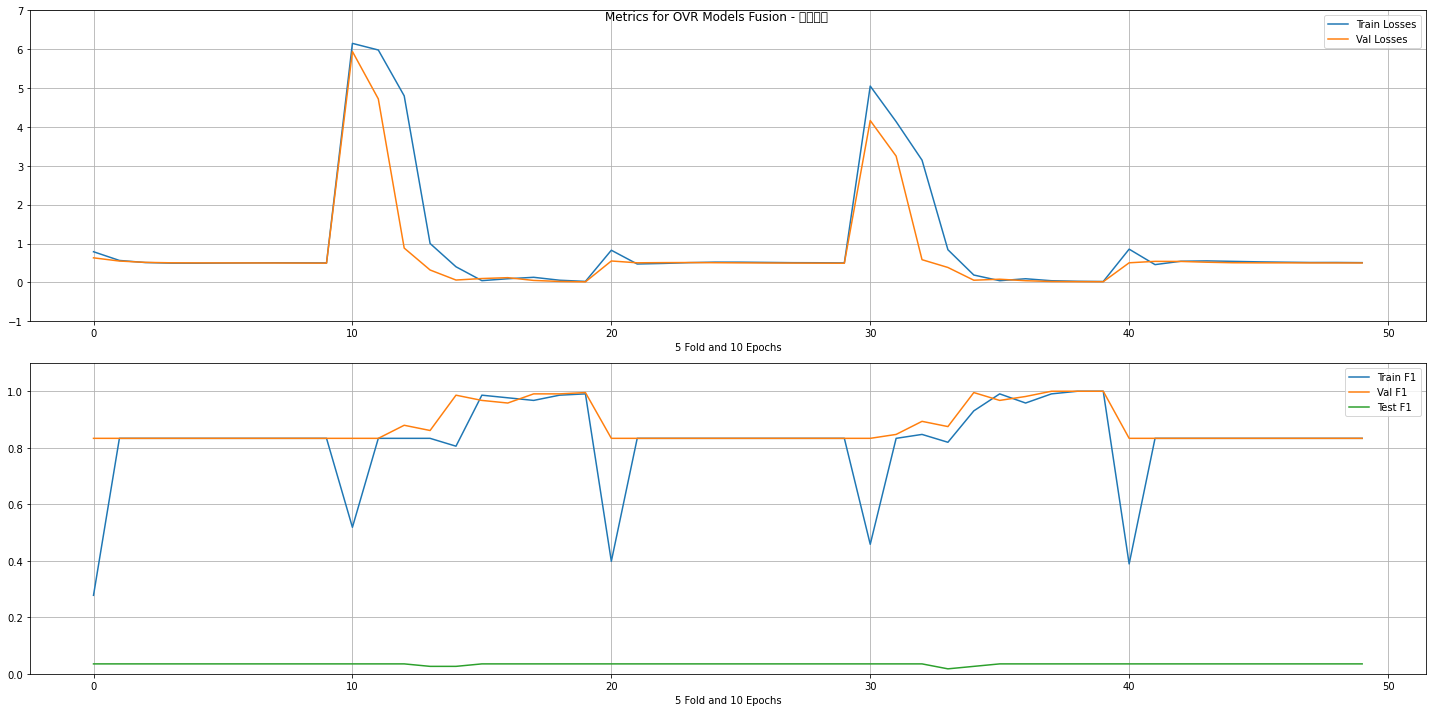

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
8,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
9,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
7,0.990741,1.000000,0.035088,0.990741,1.000000,0.035088,0.990741,1.000000,0.035088
9,0.990741,0.995370,0.035088,0.990741,0.995370,0.035088,0.990741,0.995370,0.035088
4,0.930556,0.995370,0.026316,0.930556,0.995370,0.026316,0.930556,0.995370,0.026316
8,0.986111,0.990741,0.035088,0.986111,0.990741,0.035088,0.986111,0.990741,0.035088
7,0.967593,0.990741,0.035088,0.967593,0.990741,0.035088,0.967593,0.990741,0.035088
4,0.805556,0.986111,0.026316,0.805556,0.986111,0.026316,0.805556,0.986111,0.026316
6,0.958333,0.981481,0.035088,0.958333,0.981481,0.035088,0.958333,0.981481,0.035088
5,0.990741,0.967593,0.035088,0.990741,0.967593,0.035088,0.990741,0.967593,0.035088


Training for బౌళి with 65 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 312/78


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.833 / Validation Loss : 0.645 [Time : 15.599592 seconds]
Epoch 2/10 : Training Loss: 0.592 / Validation Loss : 0.570 [Time : 15.657185 seconds]
Epoch 3/10 : Training Loss: 0.534 / Validation Loss : 0.526 [Time : 15.588756 seconds]
Epoch 4/10 : Training Loss: 0.506 / Validation Loss : 0.503 [Time : 15.624607 seconds]
Epoch 5/10 : Training Loss: 0.492 / Validation Loss : 0.493 [Time : 15.603406 seconds]
Epoch 6/10 : Training Loss: 0.483 / Validation Loss : 0.488 [Time : 15.554226 seconds]
Epoch 7/10 : Training Loss: 0.485 / Validation Loss : 0.486 [Time : 15.649311 seconds]
Epoch 8/10 : Training Loss: 0.487 / Validation Loss : 0.485 [Time : 15.657107 seconds]
Epoch 9/10 : Training Loss: 0.488 / Validation Loss : 0.485 [Time : 15.609063 seconds]
Epoch 10/10 : Training Loss: 0.491 / Validation Loss : 0.485 [Time : 14.897826 seconds]
*** Confusion Matrix - Training ***
[[260   0]
 [ 52   0]]
*** Confusion Matrix - Validation ***
[[260 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 7.808 / Validation Loss : 10.824 [Time : 14.752758 seconds]
Epoch 2/10 : Training Loss: 10.794 / Validation Loss : 4.852 [Time : 14.763931 seconds]
Epoch 3/10 : Training Loss: 4.472 / Validation Loss : 0.208 [Time : 15.590397 seconds]
Epoch 4/10 : Training Loss: 0.762 / Validation Loss : 0.104 [Time : 15.617432 seconds]
Epoch 5/10 : Training Loss: 0.125 / Validation Loss : 0.334 [Time : 14.759382 seconds]
Epoch 6/10 : Training Loss: 0.333 / Validation Loss : 0.037 [Time : 15.618443 seconds]
Epoch 7/10 : Training Loss: 0.060 / Validation Loss : 0.032 [Time : 15.745051 seconds]
Epoch 8/10 : Training Loss: 0.037 / Validation Loss : 0.028 [Time : 15.658705 seconds]
Epoch 9/10 : Training Loss: 0.024 / Validation Loss : 0.021 [Time : 15.661477 seconds]
Epoch 10/10 : Training Loss: 0.023 / Validation Loss : 0.017 [Time : 15.59963 seconds]
*** Confusion Matrix - Training ***
[[260   0]
 [  0  52]]
*** Confusion Matrix - Validation ***
[[260   0]
 [  0  52]]
Fold 2 :

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.903 / Validation Loss : 0.544 [Time : 14.750575 seconds]
Epoch 2/10 : Training Loss: 0.478 / Validation Loss : 0.492 [Time : 14.756334 seconds]
Epoch 3/10 : Training Loss: 0.474 / Validation Loss : 0.490 [Time : 14.738579 seconds]
Epoch 4/10 : Training Loss: 0.493 / Validation Loss : 0.491 [Time : 14.765436 seconds]
Epoch 5/10 : Training Loss: 0.499 / Validation Loss : 0.490 [Time : 14.875636 seconds]
Epoch 6/10 : Training Loss: 0.502 / Validation Loss : 0.488 [Time : 14.767794 seconds]
Epoch 7/10 : Training Loss: 0.499 / Validation Loss : 0.487 [Time : 14.743009 seconds]
Epoch 8/10 : Training Loss: 0.498 / Validation Loss : 0.485 [Time : 14.762025 seconds]
Epoch 9/10 : Training Loss: 0.496 / Validation Loss : 0.484 [Time : 14.768732 seconds]
Epoch 10/10 : Training Loss: 0.491 / Validation Loss : 0.482 [Time : 14.763458 seconds]
*** Confusion Matrix - Training ***
[[260   0]
 [ 52   0]]
*** Confusion Matrix - Validation ***
[[260   0]
 [ 52   0]]
Fold 3 : 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 5.001 / Validation Loss : 7.622 [Time : 14.880432 seconds]
Epoch 2/10 : Training Loss: 7.606 / Validation Loss : 3.851 [Time : 14.788531 seconds]
Epoch 3/10 : Training Loss: 3.669 / Validation Loss : 0.203 [Time : 14.741874 seconds]
Epoch 4/10 : Training Loss: 0.526 / Validation Loss : 0.148 [Time : 14.79641 seconds]
Epoch 5/10 : Training Loss: 0.130 / Validation Loss : 0.277 [Time : 14.745492 seconds]
Epoch 6/10 : Training Loss: 0.278 / Validation Loss : 0.081 [Time : 14.822744 seconds]
Epoch 7/10 : Training Loss: 0.117 / Validation Loss : 0.076 [Time : 14.715703 seconds]
Epoch 8/10 : Training Loss: 0.062 / Validation Loss : 0.058 [Time : 14.801143 seconds]
Epoch 9/10 : Training Loss: 0.063 / Validation Loss : 0.051 [Time : 14.87384 seconds]
Epoch 10/10 : Training Loss: 0.056 / Validation Loss : 0.043 [Time : 14.835745 seconds]
*** Confusion Matrix - Training ***
[[260   0]
 [  7  45]]
*** Confusion Matrix - Validation ***
[[260   0]
 [  2  50]]
Fold 4 : 14

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.990 / Validation Loss : 0.488 [Time : 14.951343 seconds]
Epoch 2/10 : Training Loss: 0.442 / Validation Loss : 0.496 [Time : 14.780589 seconds]
Epoch 3/10 : Training Loss: 0.499 / Validation Loss : 0.503 [Time : 14.806837 seconds]
Epoch 4/10 : Training Loss: 0.523 / Validation Loss : 0.493 [Time : 14.896968 seconds]
Epoch 5/10 : Training Loss: 0.516 / Validation Loss : 0.487 [Time : 14.898017 seconds]
Epoch 6/10 : Training Loss: 0.504 / Validation Loss : 0.485 [Time : 14.792105 seconds]
Epoch 7/10 : Training Loss: 0.500 / Validation Loss : 0.484 [Time : 14.806379 seconds]
Epoch 8/10 : Training Loss: 0.498 / Validation Loss : 0.484 [Time : 14.798458 seconds]
Epoch 9/10 : Training Loss: 0.498 / Validation Loss : 0.484 [Time : 14.734622 seconds]
Epoch 10/10 : Training Loss: 0.496 / Validation Loss : 0.484 [Time : 14.738778 seconds]
*** Confusion Matrix - Training ***
[[260   0]
 [ 52   0]]
*** Confusion Matrix - Validation ***
[[260   0]
 [ 52   0]]
Fold 5 : 

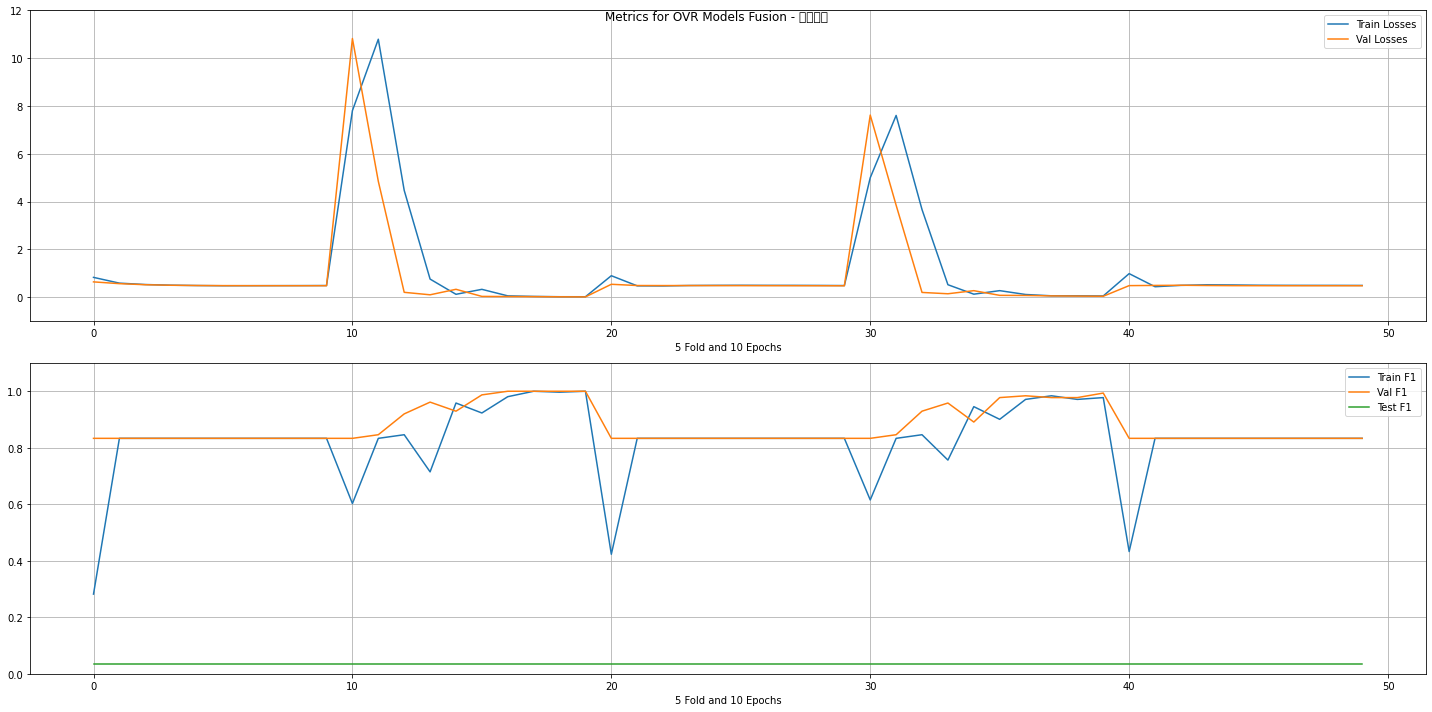

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
7,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
9,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
8,0.996795,1.000000,0.035088,0.996795,1.000000,0.035088,0.996795,1.000000,0.035088
6,0.980769,1.000000,0.035088,0.980769,1.000000,0.035088,0.980769,1.000000,0.035088
9,0.977564,0.993590,0.035088,0.977564,0.993590,0.035088,0.977564,0.993590,0.035088
5,0.923077,0.987179,0.035088,0.923077,0.987179,0.035088,0.923077,0.987179,0.035088
6,0.971154,0.983974,0.035088,0.971154,0.983974,0.035088,0.971154,0.983974,0.035088
7,0.983974,0.977564,0.035088,0.983974,0.977564,0.035088,0.983974,0.977564,0.035088
8,0.971154,0.977564,0.035088,0.971154,0.977564,0.035088,0.971154,0.977564,0.035088
5,0.900641,0.977564,0.035088,0.900641,0.977564,0.035088,0.900641,0.977564,0.035088


Training for బౌళిరామక్రియ with 12 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 57/15


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.795 / Validation Loss : 0.731 [Time : 11.557398 seconds]
Epoch 2/10 : Training Loss: 0.703 / Validation Loss : 0.680 [Time : 11.643734 seconds]
Epoch 3/10 : Training Loss: 0.659 / Validation Loss : 0.652 [Time : 11.753626 seconds]
Epoch 4/10 : Training Loss: 0.638 / Validation Loss : 0.640 [Time : 11.733334 seconds]
Epoch 5/10 : Training Loss: 0.629 / Validation Loss : 0.634 [Time : 11.577135 seconds]
Epoch 6/10 : Training Loss: 0.626 / Validation Loss : 0.632 [Time : 11.662154 seconds]
Epoch 7/10 : Training Loss: 0.631 / Validation Loss : 0.631 [Time : 11.564773 seconds]
Epoch 8/10 : Training Loss: 0.629 / Validation Loss : 0.631 [Time : 10.790355 seconds]
Epoch 9/10 : Training Loss: 0.630 / Validation Loss : 0.632 [Time : 10.722019 seconds]
Epoch 10/10 : Training Loss: 0.630 / Validation Loss : 0.632 [Time : 10.734484 seconds]
*** Confusion Matrix - Training ***
[[48  0]
 [ 9  0]]
*** Confusion Matrix - Validation ***
[[48  0]
 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 8.620 / Validation Loss : 0.704 [Time : 10.715776 seconds]
Epoch 2/10 : Training Loss: 0.108 / Validation Loss : 1.089 [Time : 10.721388 seconds]
Epoch 3/10 : Training Loss: 1.418 / Validation Loss : 0.282 [Time : 11.632481 seconds]
Epoch 4/10 : Training Loss: 0.358 / Validation Loss : 0.010 [Time : 11.637799 seconds]
Epoch 5/10 : Training Loss: 0.028 / Validation Loss : 0.003 [Time : 11.694808 seconds]
Epoch 6/10 : Training Loss: 0.003 / Validation Loss : 0.004 [Time : 10.784005 seconds]
Epoch 7/10 : Training Loss: 0.004 / Validation Loss : 0.006 [Time : 10.754303 seconds]
Epoch 8/10 : Training Loss: 0.005 / Validation Loss : 0.007 [Time : 10.732311 seconds]
Epoch 9/10 : Training Loss: 0.009 / Validation Loss : 0.008 [Time : 10.735857 seconds]
Epoch 10/10 : Training Loss: 0.010 / Validation Loss : 0.008 [Time : 10.771179 seconds]
*** Confusion Matrix - Training ***
[[48  0]
 [ 0  9]]
*** Confusion Matrix - Validation ***
[[48  0]
 [ 0  9]]
Fold 2 : 111.0208

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.899 / Validation Loss : 0.753 [Time : 10.789888 seconds]
Epoch 2/10 : Training Loss: 0.700 / Validation Loss : 0.661 [Time : 10.794323 seconds]
Epoch 3/10 : Training Loss: 0.626 / Validation Loss : 0.641 [Time : 10.767522 seconds]
Epoch 4/10 : Training Loss: 0.624 / Validation Loss : 0.647 [Time : 10.781023 seconds]
Epoch 5/10 : Training Loss: 0.640 / Validation Loss : 0.652 [Time : 10.76859 seconds]
Epoch 6/10 : Training Loss: 0.652 / Validation Loss : 0.653 [Time : 10.842506 seconds]
Epoch 7/10 : Training Loss: 0.658 / Validation Loss : 0.649 [Time : 10.746077 seconds]
Epoch 8/10 : Training Loss: 0.649 / Validation Loss : 0.643 [Time : 10.778551 seconds]
Epoch 9/10 : Training Loss: 0.654 / Validation Loss : 0.637 [Time : 10.739434 seconds]
Epoch 10/10 : Training Loss: 0.649 / Validation Loss : 0.631 [Time : 10.812237 seconds]
*** Confusion Matrix - Training ***
[[48  0]
 [10  0]]
*** Confusion Matrix - Validation ***
[[48  0]
 [10  0]]
Fold 3 : 108.69569

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 1.726 / Validation Loss : 0.613 [Time : 10.775612 seconds]
Epoch 2/10 : Training Loss: 0.683 / Validation Loss : 0.862 [Time : 10.793878 seconds]
Epoch 3/10 : Training Loss: 1.010 / Validation Loss : 0.203 [Time : 10.785943 seconds]
Epoch 4/10 : Training Loss: 0.179 / Validation Loss : 0.006 [Time : 10.835882 seconds]
Epoch 5/10 : Training Loss: 0.010 / Validation Loss : 0.005 [Time : 10.720807 seconds]
Epoch 6/10 : Training Loss: 0.012 / Validation Loss : 0.010 [Time : 10.923393 seconds]
Epoch 7/10 : Training Loss: 0.014 / Validation Loss : 0.015 [Time : 10.710805 seconds]
Epoch 8/10 : Training Loss: 0.016 / Validation Loss : 0.018 [Time : 10.712225 seconds]
Epoch 9/10 : Training Loss: 0.027 / Validation Loss : 0.015 [Time : 10.748502 seconds]
Epoch 10/10 : Training Loss: 0.015 / Validation Loss : 0.010 [Time : 10.72511 seconds]
*** Confusion Matrix - Training ***
[[48  0]
 [ 0 10]]
*** Confusion Matrix - Validation ***
[[48  0]
 [ 0 10]]
Fold 4 : 108.55922

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 1.081 / Validation Loss : 0.825 [Time : 10.834188 seconds]
Epoch 2/10 : Training Loss: 0.707 / Validation Loss : 0.651 [Time : 10.713852 seconds]
Epoch 3/10 : Training Loss: 0.609 / Validation Loss : 0.660 [Time : 10.772055 seconds]
Epoch 4/10 : Training Loss: 0.643 / Validation Loss : 0.685 [Time : 10.722895 seconds]
Epoch 5/10 : Training Loss: 0.694 / Validation Loss : 0.692 [Time : 10.731839 seconds]
Epoch 6/10 : Training Loss: 0.706 / Validation Loss : 0.682 [Time : 10.717195 seconds]
Epoch 7/10 : Training Loss: 0.697 / Validation Loss : 0.666 [Time : 10.794103 seconds]
Epoch 8/10 : Training Loss: 0.677 / Validation Loss : 0.651 [Time : 10.744878 seconds]
Epoch 9/10 : Training Loss: 0.671 / Validation Loss : 0.643 [Time : 10.748334 seconds]
Epoch 10/10 : Training Loss: 0.665 / Validation Loss : 0.640 [Time : 10.770731 seconds]
*** Confusion Matrix - Training ***
[[48  0]
 [10  0]]
*** Confusion Matrix - Validation ***
[[48  0]
 [10  0]]
Fold 5 : 108.3673

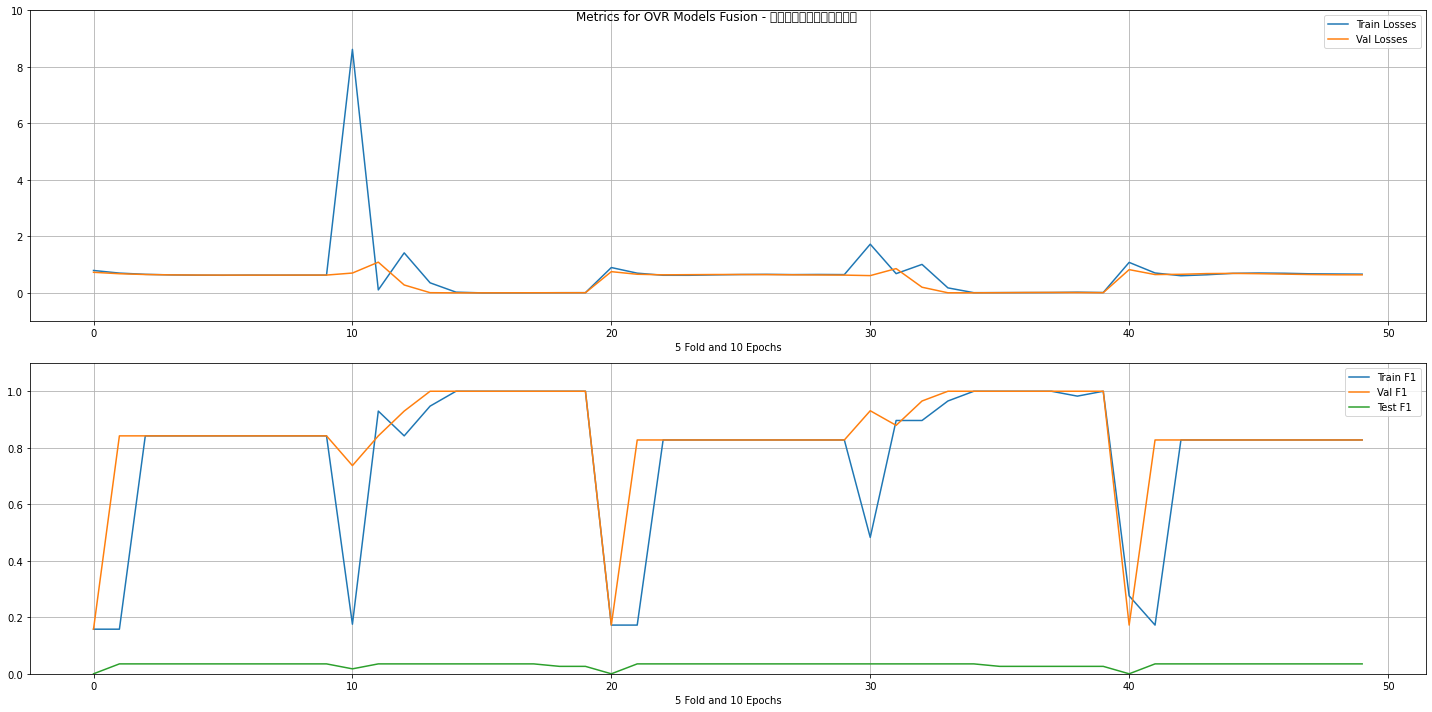

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
4,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
5,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
6,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
7,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
8,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
9,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
4,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
5,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
6,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
7,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316


Training for భూపాలం with 30 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 144/36


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.786 / Validation Loss : 0.637 [Time : 13.010718 seconds]
Epoch 2/10 : Training Loss: 0.571 / Validation Loss : 0.547 [Time : 13.062026 seconds]
Epoch 3/10 : Training Loss: 0.512 / Validation Loss : 0.507 [Time : 13.0295 seconds]
Epoch 4/10 : Training Loss: 0.481 / Validation Loss : 0.488 [Time : 13.120201 seconds]
Epoch 5/10 : Training Loss: 0.474 / Validation Loss : 0.481 [Time : 13.077673 seconds]
Epoch 6/10 : Training Loss: 0.473 / Validation Loss : 0.478 [Time : 12.960635 seconds]
Epoch 7/10 : Training Loss: 0.476 / Validation Loss : 0.477 [Time : 12.974535 seconds]
Epoch 8/10 : Training Loss: 0.477 / Validation Loss : 0.476 [Time : 12.977102 seconds]
Epoch 9/10 : Training Loss: 0.480 / Validation Loss : 0.475 [Time : 12.95403 seconds]
Epoch 10/10 : Training Loss: 0.476 / Validation Loss : 0.475 [Time : 12.132135 seconds]
*** Confusion Matrix - Training ***
[[120   0]
 [ 24   0]]
*** Confusion Matrix - Validation ***
[[120   0

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 7.257 / Validation Loss : 4.413 [Time : 12.077277 seconds]
Epoch 2/10 : Training Loss: 4.475 / Validation Loss : 4.006 [Time : 12.153165 seconds]
Epoch 3/10 : Training Loss: 3.888 / Validation Loss : 1.072 [Time : 12.156075 seconds]
Epoch 4/10 : Training Loss: 1.161 / Validation Loss : 0.097 [Time : 12.970032 seconds]
Epoch 5/10 : Training Loss: 0.194 / Validation Loss : 0.161 [Time : 12.098501 seconds]
Epoch 6/10 : Training Loss: 0.241 / Validation Loss : 0.079 [Time : 13.011991 seconds]
Epoch 7/10 : Training Loss: 0.044 / Validation Loss : 0.022 [Time : 12.998827 seconds]
Epoch 8/10 : Training Loss: 0.015 / Validation Loss : 0.018 [Time : 13.1982 seconds]
Epoch 9/10 : Training Loss: 0.021 / Validation Loss : 0.017 [Time : 13.083247 seconds]
Epoch 10/10 : Training Loss: 0.018 / Validation Loss : 0.015 [Time : 13.106145 seconds]
*** Confusion Matrix - Training ***
[[120   0]
 [  1  23]]
*** Confusion Matrix - Validation ***
[[120   0]
 [  1  23]]
Fold 2 : 12

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.841 / Validation Loss : 0.569 [Time : 12.247993 seconds]
Epoch 2/10 : Training Loss: 0.477 / Validation Loss : 0.486 [Time : 12.091097 seconds]
Epoch 3/10 : Training Loss: 0.460 / Validation Loss : 0.481 [Time : 12.082981 seconds]
Epoch 4/10 : Training Loss: 0.474 / Validation Loss : 0.484 [Time : 12.114925 seconds]
Epoch 5/10 : Training Loss: 0.485 / Validation Loss : 0.485 [Time : 12.200321 seconds]
Epoch 6/10 : Training Loss: 0.493 / Validation Loss : 0.482 [Time : 12.123729 seconds]
Epoch 7/10 : Training Loss: 0.492 / Validation Loss : 0.478 [Time : 12.107707 seconds]
Epoch 8/10 : Training Loss: 0.486 / Validation Loss : 0.474 [Time : 12.065427 seconds]
Epoch 9/10 : Training Loss: 0.480 / Validation Loss : 0.471 [Time : 12.150618 seconds]
Epoch 10/10 : Training Loss: 0.476 / Validation Loss : 0.467 [Time : 12.056108 seconds]
*** Confusion Matrix - Training ***
[[120   0]
 [ 24   0]]
*** Confusion Matrix - Validation ***
[[120   0]
 [ 24   0]]
Fold 3 : 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 5.963 / Validation Loss : 3.321 [Time : 12.065958 seconds]
Epoch 2/10 : Training Loss: 3.322 / Validation Loss : 3.122 [Time : 12.109138 seconds]
Epoch 3/10 : Training Loss: 3.155 / Validation Loss : 0.909 [Time : 12.079537 seconds]
Epoch 4/10 : Training Loss: 0.974 / Validation Loss : 0.131 [Time : 12.1024 seconds]
Epoch 5/10 : Training Loss: 0.296 / Validation Loss : 0.207 [Time : 12.080236 seconds]
Epoch 6/10 : Training Loss: 0.175 / Validation Loss : 0.089 [Time : 12.157689 seconds]
Epoch 7/10 : Training Loss: 0.063 / Validation Loss : 0.051 [Time : 12.092956 seconds]
Epoch 8/10 : Training Loss: 0.050 / Validation Loss : 0.047 [Time : 12.172023 seconds]
Epoch 9/10 : Training Loss: 0.044 / Validation Loss : 0.042 [Time : 12.684991 seconds]
Epoch 10/10 : Training Loss: 0.050 / Validation Loss : 0.030 [Time : 12.306593 seconds]
*** Confusion Matrix - Training ***
[[120   0]
 [  4  20]]
*** Confusion Matrix - Validation ***
[[120   0]
 [  1  23]]
Fold 4 : 12

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.962 / Validation Loss : 0.508 [Time : 12.077989 seconds]
Epoch 2/10 : Training Loss: 0.418 / Validation Loss : 0.491 [Time : 12.133085 seconds]
Epoch 3/10 : Training Loss: 0.483 / Validation Loss : 0.508 [Time : 12.084881 seconds]
Epoch 4/10 : Training Loss: 0.513 / Validation Loss : 0.509 [Time : 12.116039 seconds]
Epoch 5/10 : Training Loss: 0.520 / Validation Loss : 0.497 [Time : 12.109731 seconds]
Epoch 6/10 : Training Loss: 0.510 / Validation Loss : 0.486 [Time : 12.11664 seconds]
Epoch 7/10 : Training Loss: 0.505 / Validation Loss : 0.481 [Time : 12.159907 seconds]
Epoch 8/10 : Training Loss: 0.496 / Validation Loss : 0.479 [Time : 12.328652 seconds]
Epoch 9/10 : Training Loss: 0.494 / Validation Loss : 0.478 [Time : 12.100138 seconds]
Epoch 10/10 : Training Loss: 0.490 / Validation Loss : 0.478 [Time : 12.101575 seconds]
*** Confusion Matrix - Training ***
[[120   0]
 [ 24   0]]
*** Confusion Matrix - Validation ***
[[120   0]
 [ 24   0]]
Fold 5 : 1

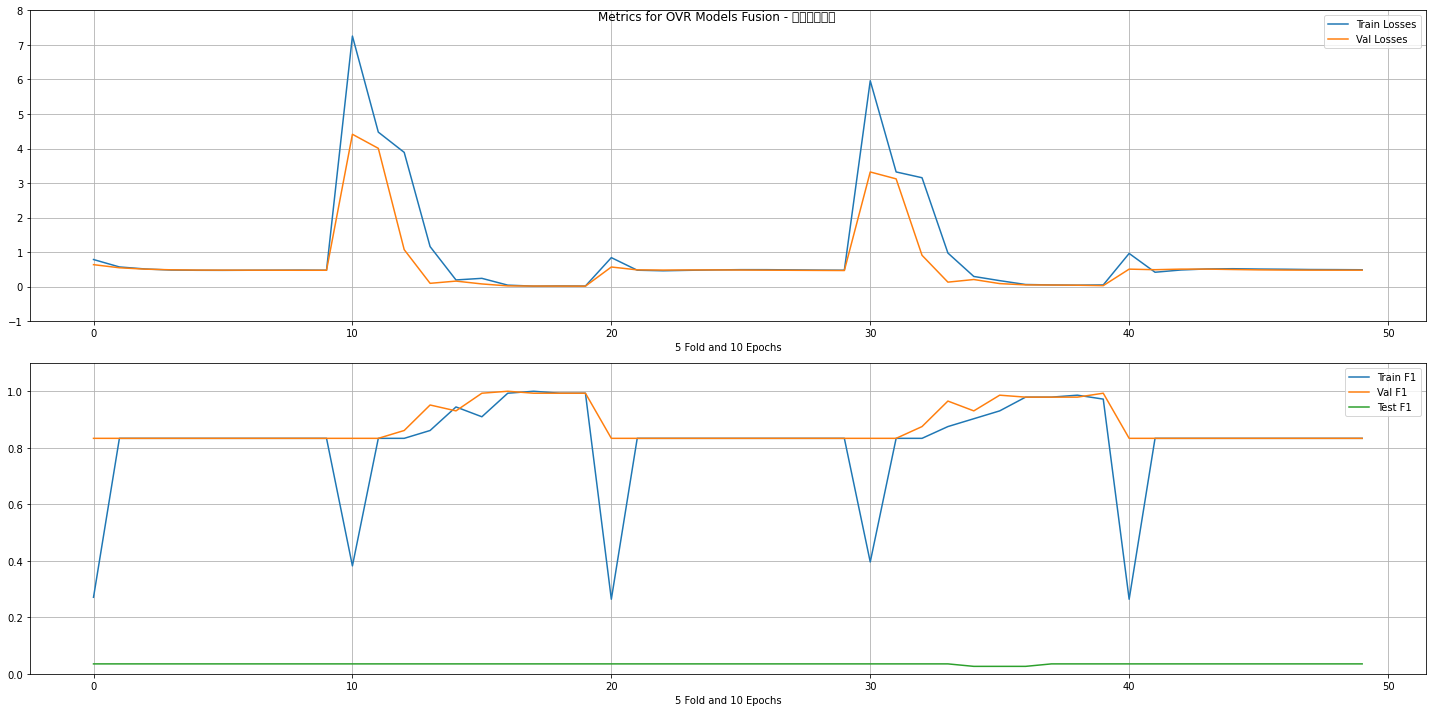

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
6,0.993056,1.000000,0.035088,0.993056,1.000000,0.035088,0.993056,1.000000,0.035088
7,1.000000,0.993056,0.035088,1.000000,0.993056,0.035088,1.000000,0.993056,0.035088
8,0.993056,0.993056,0.035088,0.993056,0.993056,0.035088,0.993056,0.993056,0.035088
9,0.993056,0.993056,0.035088,0.993056,0.993056,0.035088,0.993056,0.993056,0.035088
9,0.972222,0.993056,0.035088,0.972222,0.993056,0.035088,0.972222,0.993056,0.035088
5,0.909722,0.993056,0.035088,0.909722,0.993056,0.035088,0.909722,0.993056,0.035088
5,0.930556,0.986111,0.026316,0.930556,0.986111,0.026316,0.930556,0.986111,0.026316
8,0.986111,0.979167,0.035088,0.986111,0.979167,0.035088,0.986111,0.979167,0.035088
6,0.979167,0.979167,0.026316,0.979167,0.979167,0.026316,0.979167,0.979167,0.026316
7,0.979167,0.979167,0.035088,0.979167,0.979167,0.035088,0.979167,0.979167,0.035088


Training for భైరవి with 26 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 124/32


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.806 / Validation Loss : 0.678 [Time : 12.638081 seconds]
Epoch 2/10 : Training Loss: 0.615 / Validation Loss : 0.594 [Time : 12.764939 seconds]
Epoch 3/10 : Training Loss: 0.562 / Validation Loss : 0.559 [Time : 12.653166 seconds]
Epoch 4/10 : Training Loss: 0.538 / Validation Loss : 0.541 [Time : 12.724162 seconds]
Epoch 5/10 : Training Loss: 0.526 / Validation Loss : 0.532 [Time : 12.65903 seconds]
Epoch 6/10 : Training Loss: 0.522 / Validation Loss : 0.530 [Time : 12.713164 seconds]
Epoch 7/10 : Training Loss: 0.523 / Validation Loss : 0.528 [Time : 12.677041 seconds]
Epoch 8/10 : Training Loss: 0.528 / Validation Loss : 0.529 [Time : 11.804995 seconds]
Epoch 9/10 : Training Loss: 0.529 / Validation Loss : 0.528 [Time : 11.7327 seconds]
Epoch 10/10 : Training Loss: 0.528 / Validation Loss : 0.527 [Time : 12.708246 seconds]
*** Confusion Matrix - Training ***
[[104   0]
 [ 20   0]]
*** Confusion Matrix - Validation ***
[[104   0

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 7.919 / Validation Loss : 1.162 [Time : 11.805427 seconds]
Epoch 2/10 : Training Loss: 1.111 / Validation Loss : 2.277 [Time : 11.805743 seconds]
Epoch 3/10 : Training Loss: 2.433 / Validation Loss : 0.252 [Time : 12.671567 seconds]
Epoch 4/10 : Training Loss: 0.238 / Validation Loss : 0.015 [Time : 12.664135 seconds]
Epoch 5/10 : Training Loss: 0.167 / Validation Loss : 0.094 [Time : 11.781307 seconds]
Epoch 6/10 : Training Loss: 0.101 / Validation Loss : 0.029 [Time : 11.79977 seconds]
Epoch 7/10 : Training Loss: 0.028 / Validation Loss : 0.012 [Time : 13.011884 seconds]
Epoch 8/10 : Training Loss: 0.011 / Validation Loss : 0.007 [Time : 12.661959 seconds]
Epoch 9/10 : Training Loss: 0.007 / Validation Loss : 0.006 [Time : 12.758914 seconds]
Epoch 10/10 : Training Loss: 0.005 / Validation Loss : 0.005 [Time : 12.593115 seconds]
*** Confusion Matrix - Training ***
[[104   0]
 [  0  21]]
*** Confusion Matrix - Validation ***
[[104   0]
 [  0  21]]
Fold 2 : 1

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.897 / Validation Loss : 0.646 [Time : 11.769735 seconds]
Epoch 2/10 : Training Loss: 0.542 / Validation Loss : 0.545 [Time : 11.788349 seconds]
Epoch 3/10 : Training Loss: 0.516 / Validation Loss : 0.536 [Time : 11.825973 seconds]
Epoch 4/10 : Training Loss: 0.524 / Validation Loss : 0.539 [Time : 11.807615 seconds]
Epoch 5/10 : Training Loss: 0.539 / Validation Loss : 0.540 [Time : 11.76048 seconds]
Epoch 6/10 : Training Loss: 0.547 / Validation Loss : 0.538 [Time : 11.754637 seconds]
Epoch 7/10 : Training Loss: 0.544 / Validation Loss : 0.534 [Time : 11.778741 seconds]
Epoch 8/10 : Training Loss: 0.543 / Validation Loss : 0.530 [Time : 11.750435 seconds]
Epoch 9/10 : Training Loss: 0.541 / Validation Loss : 0.526 [Time : 11.752074 seconds]
Epoch 10/10 : Training Loss: 0.536 / Validation Loss : 0.522 [Time : 11.776247 seconds]
*** Confusion Matrix - Training ***
[[104   0]
 [ 21   0]]
*** Confusion Matrix - Validation ***
[[104   0]
 [ 21   0]]
Fold 3 : 1

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 5.511 / Validation Loss : 1.810 [Time : 11.781809 seconds]
Epoch 2/10 : Training Loss: 1.901 / Validation Loss : 1.653 [Time : 11.762759 seconds]
Epoch 3/10 : Training Loss: 1.684 / Validation Loss : 0.272 [Time : 11.851347 seconds]
Epoch 4/10 : Training Loss: 0.321 / Validation Loss : 0.037 [Time : 11.886916 seconds]
Epoch 5/10 : Training Loss: 0.083 / Validation Loss : 0.119 [Time : 11.760467 seconds]
Epoch 6/10 : Training Loss: 0.130 / Validation Loss : 0.081 [Time : 11.782186 seconds]
Epoch 7/10 : Training Loss: 0.037 / Validation Loss : 0.019 [Time : 11.851567 seconds]
Epoch 8/10 : Training Loss: 0.015 / Validation Loss : 0.007 [Time : 11.823098 seconds]
Epoch 9/10 : Training Loss: 0.007 / Validation Loss : 0.005 [Time : 11.750828 seconds]
Epoch 10/10 : Training Loss: 0.006 / Validation Loss : 0.005 [Time : 11.761435 seconds]
*** Confusion Matrix - Training ***
[[104   0]
 [  0  21]]
*** Confusion Matrix - Validation ***
[[104   0]
 [  0  21]]
Fold 4 : 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 1.047 / Validation Loss : 0.596 [Time : 11.768335 seconds]
Epoch 2/10 : Training Loss: 0.464 / Validation Loss : 0.539 [Time : 11.804203 seconds]
Epoch 3/10 : Training Loss: 0.523 / Validation Loss : 0.561 [Time : 11.867059 seconds]
Epoch 4/10 : Training Loss: 0.561 / Validation Loss : 0.566 [Time : 11.894617 seconds]
Epoch 5/10 : Training Loss: 0.578 / Validation Loss : 0.557 [Time : 11.776112 seconds]
Epoch 6/10 : Training Loss: 0.572 / Validation Loss : 0.545 [Time : 11.771061 seconds]
Epoch 7/10 : Training Loss: 0.557 / Validation Loss : 0.536 [Time : 11.805811 seconds]
Epoch 8/10 : Training Loss: 0.555 / Validation Loss : 0.531 [Time : 11.766932 seconds]
Epoch 9/10 : Training Loss: 0.548 / Validation Loss : 0.530 [Time : 11.810033 seconds]
Epoch 10/10 : Training Loss: 0.541 / Validation Loss : 0.530 [Time : 11.794407 seconds]
*** Confusion Matrix - Training ***
[[104   0]
 [ 21   0]]
*** Confusion Matrix - Validation ***
[[104   0]
 [ 21   0]]
Fold 5 : 

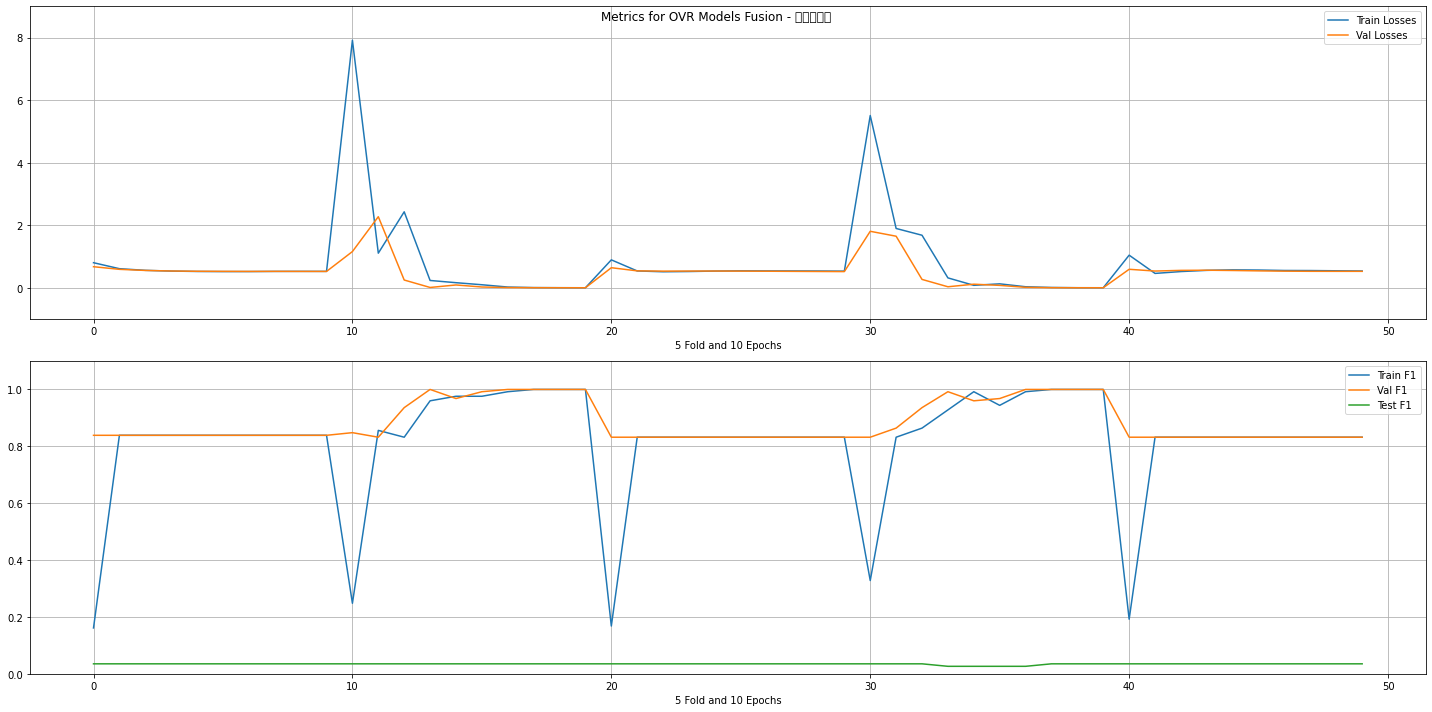

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
7,1.00000,1.00000,0.035088,1.00000,1.00000,0.035088,1.00000,1.00000,0.035088
8,1.00000,1.00000,0.035088,1.00000,1.00000,0.035088,1.00000,1.00000,0.035088
9,1.00000,1.00000,0.035088,1.00000,1.00000,0.035088,1.00000,1.00000,0.035088
7,1.00000,1.00000,0.035088,1.00000,1.00000,0.035088,1.00000,1.00000,0.035088
8,1.00000,1.00000,0.035088,1.00000,1.00000,0.035088,1.00000,1.00000,0.035088
9,1.00000,1.00000,0.035088,1.00000,1.00000,0.035088,1.00000,1.00000,0.035088
6,0.99200,1.00000,0.035088,0.99200,1.00000,0.035088,0.99200,1.00000,0.035088
6,0.99200,1.00000,0.026316,0.99200,1.00000,0.026316,0.99200,1.00000,0.026316
3,0.96000,1.00000,0.035088,0.96000,1.00000,0.035088,0.96000,1.00000,0.035088
5,0.97600,0.99200,0.035088,0.97600,0.99200,0.035088,0.97600,0.99200,0.035088


Training for మలహరి with 17 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 81/21


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.811 / Validation Loss : 0.708 [Time : 11.951878 seconds]
Epoch 2/10 : Training Loss: 0.657 / Validation Loss : 0.631 [Time : 12.142819 seconds]
Epoch 3/10 : Training Loss: 0.601 / Validation Loss : 0.597 [Time : 12.007561 seconds]
Epoch 4/10 : Training Loss: 0.579 / Validation Loss : 0.581 [Time : 11.937394 seconds]
Epoch 5/10 : Training Loss: 0.568 / Validation Loss : 0.574 [Time : 11.940877 seconds]
Epoch 6/10 : Training Loss: 0.565 / Validation Loss : 0.571 [Time : 11.957447 seconds]
Epoch 7/10 : Training Loss: 0.566 / Validation Loss : 0.570 [Time : 11.97073 seconds]
Epoch 8/10 : Training Loss: 0.568 / Validation Loss : 0.570 [Time : 11.091542 seconds]
Epoch 9/10 : Training Loss: 0.571 / Validation Loss : 0.571 [Time : 11.130625 seconds]
Epoch 10/10 : Training Loss: 0.573 / Validation Loss : 0.570 [Time : 11.048901 seconds]
*** Confusion Matrix - Training ***
[[68  0]
 [13  0]]
*** Confusion Matrix - Validation ***
[[68  0]
 [

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 6.530 / Validation Loss : 0.353 [Time : 11.882595 seconds]
Epoch 2/10 : Training Loss: 0.398 / Validation Loss : 2.634 [Time : 11.238505 seconds]
Epoch 3/10 : Training Loss: 2.842 / Validation Loss : 1.397 [Time : 11.090328 seconds]
Epoch 4/10 : Training Loss: 1.427 / Validation Loss : 0.466 [Time : 11.05742 seconds]
Epoch 5/10 : Training Loss: 0.462 / Validation Loss : 0.110 [Time : 11.902542 seconds]
Epoch 6/10 : Training Loss: 0.117 / Validation Loss : 0.063 [Time : 11.963171 seconds]
Epoch 7/10 : Training Loss: 0.058 / Validation Loss : 0.042 [Time : 12.297083 seconds]
Epoch 8/10 : Training Loss: 0.041 / Validation Loss : 0.032 [Time : 11.967066 seconds]
Epoch 9/10 : Training Loss: 0.031 / Validation Loss : 0.026 [Time : 11.948062 seconds]
Epoch 10/10 : Training Loss: 0.026 / Validation Loss : 0.022 [Time : 12.045794 seconds]
*** Confusion Matrix - Training ***
[[68  0]
 [ 1 12]]
*** Confusion Matrix - Validation ***
[[68  0]
 [ 1 12]]
Fold 2 : 118.22941

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.912 / Validation Loss : 0.690 [Time : 11.107488 seconds]
Epoch 2/10 : Training Loss: 0.594 / Validation Loss : 0.578 [Time : 11.117999 seconds]
Epoch 3/10 : Training Loss: 0.540 / Validation Loss : 0.565 [Time : 11.097376 seconds]
Epoch 4/10 : Training Loss: 0.556 / Validation Loss : 0.570 [Time : 11.424661 seconds]
Epoch 5/10 : Training Loss: 0.569 / Validation Loss : 0.573 [Time : 11.160825 seconds]
Epoch 6/10 : Training Loss: 0.571 / Validation Loss : 0.573 [Time : 11.132296 seconds]
Epoch 7/10 : Training Loss: 0.579 / Validation Loss : 0.569 [Time : 11.104201 seconds]
Epoch 8/10 : Training Loss: 0.577 / Validation Loss : 0.564 [Time : 11.108127 seconds]
Epoch 9/10 : Training Loss: 0.570 / Validation Loss : 0.559 [Time : 11.085992 seconds]
Epoch 10/10 : Training Loss: 0.569 / Validation Loss : 0.555 [Time : 11.110955 seconds]
*** Confusion Matrix - Training ***
[[68  0]
 [14  0]]
*** Confusion Matrix - Validation ***
[[68  0]
 [14  0]]
Fold 3 : 112.3284

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 4.044 / Validation Loss : 0.736 [Time : 11.055497 seconds]
Epoch 2/10 : Training Loss: 0.663 / Validation Loss : 1.301 [Time : 11.089091 seconds]
Epoch 3/10 : Training Loss: 1.359 / Validation Loss : 0.336 [Time : 11.061664 seconds]
Epoch 4/10 : Training Loss: 0.388 / Validation Loss : 0.045 [Time : 11.068054 seconds]
Epoch 5/10 : Training Loss: 0.054 / Validation Loss : 0.018 [Time : 11.947847 seconds]
Epoch 6/10 : Training Loss: 0.028 / Validation Loss : 0.020 [Time : 11.091207 seconds]
Epoch 7/10 : Training Loss: 0.026 / Validation Loss : 0.039 [Time : 11.092304 seconds]
Epoch 8/10 : Training Loss: 0.043 / Validation Loss : 0.039 [Time : 11.071464 seconds]
Epoch 9/10 : Training Loss: 0.038 / Validation Loss : 0.020 [Time : 11.075277 seconds]
Epoch 10/10 : Training Loss: 0.023 / Validation Loss : 0.011 [Time : 12.106298 seconds]
*** Confusion Matrix - Training ***
[[67  1]
 [ 0 14]]
*** Confusion Matrix - Validation ***
[[68  0]
 [ 0 14]]
Fold 4 : 113.4820

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 1.087 / Validation Loss : 0.691 [Time : 11.07828 seconds]
Epoch 2/10 : Training Loss: 0.538 / Validation Loss : 0.582 [Time : 11.129912 seconds]
Epoch 3/10 : Training Loss: 0.552 / Validation Loss : 0.610 [Time : 11.085954 seconds]
Epoch 4/10 : Training Loss: 0.603 / Validation Loss : 0.622 [Time : 11.112695 seconds]
Epoch 5/10 : Training Loss: 0.626 / Validation Loss : 0.615 [Time : 11.101428 seconds]
Epoch 6/10 : Training Loss: 0.631 / Validation Loss : 0.601 [Time : 11.079589 seconds]
Epoch 7/10 : Training Loss: 0.618 / Validation Loss : 0.586 [Time : 11.089116 seconds]
Epoch 8/10 : Training Loss: 0.612 / Validation Loss : 0.576 [Time : 11.119162 seconds]
Epoch 9/10 : Training Loss: 0.593 / Validation Loss : 0.573 [Time : 11.104804 seconds]
Epoch 10/10 : Training Loss: 0.591 / Validation Loss : 0.573 [Time : 11.070056 seconds]
*** Confusion Matrix - Training ***
[[68  0]
 [14  0]]
*** Confusion Matrix - Validation ***
[[68  0]
 [14  0]]
Fold 5 : 111.82987

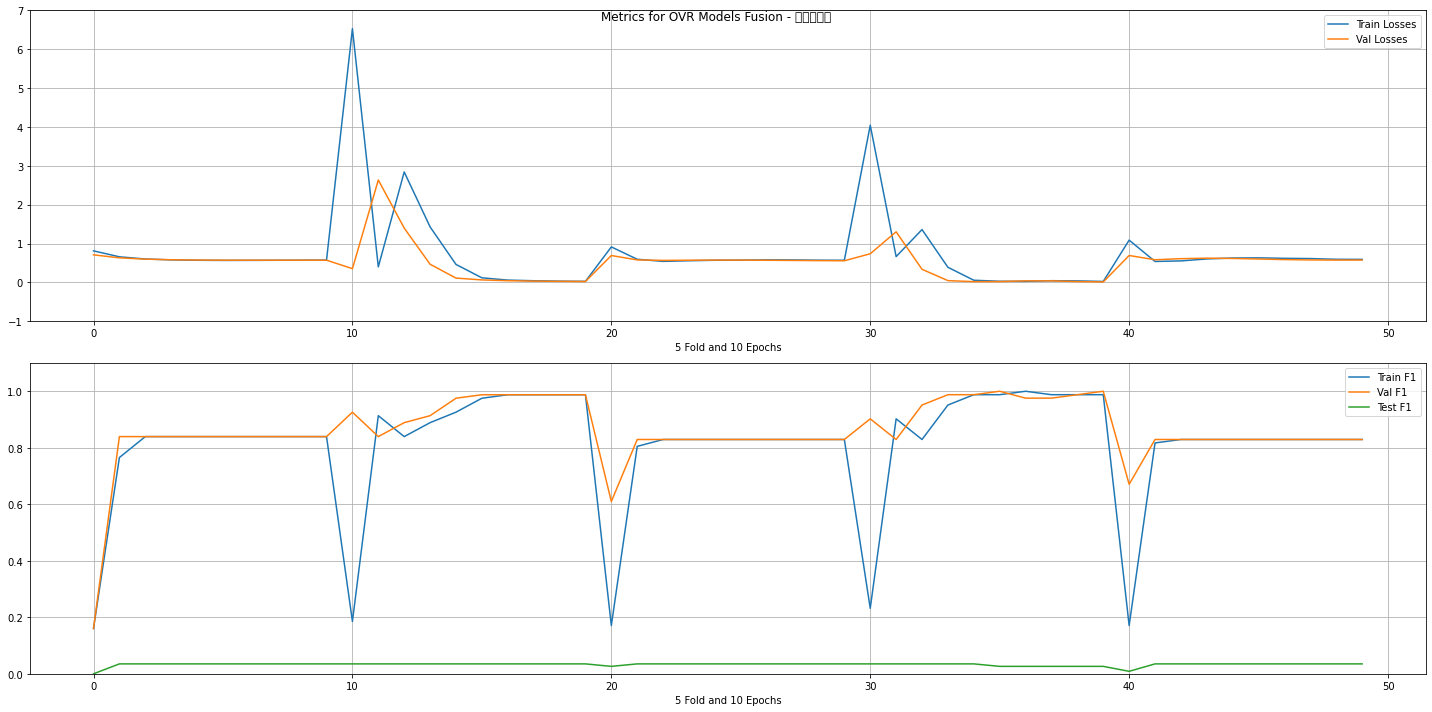

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
5,0.987805,1.000000,0.026316,0.987805,1.000000,0.026316,0.987805,1.000000,0.026316
9,0.987805,1.000000,0.026316,0.987805,1.000000,0.026316,0.987805,1.000000,0.026316
4,0.987805,0.987805,0.035088,0.987805,0.987805,0.035088,0.987805,0.987805,0.035088
8,0.987805,0.987805,0.026316,0.987805,0.987805,0.026316,0.987805,0.987805,0.026316
3,0.951220,0.987805,0.035088,0.951220,0.987805,0.035088,0.951220,0.987805,0.035088
6,0.987654,0.987654,0.035088,0.987654,0.987654,0.035088,0.987654,0.987654,0.035088
7,0.987654,0.987654,0.035088,0.987654,0.987654,0.035088,0.987654,0.987654,0.035088
8,0.987654,0.987654,0.035088,0.987654,0.987654,0.035088,0.987654,0.987654,0.035088
9,0.987654,0.987654,0.035088,0.987654,0.987654,0.035088,0.987654,0.987654,0.035088
5,0.975309,0.987654,0.035088,0.975309,0.987654,0.035088,0.975309,0.987654,0.035088


Training for మాళవి with 14 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 67/17


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.811 / Validation Loss : 0.699 [Time : 11.786832 seconds]
Epoch 2/10 : Training Loss: 0.642 / Validation Loss : 0.615 [Time : 11.832897 seconds]
Epoch 3/10 : Training Loss: 0.585 / Validation Loss : 0.580 [Time : 11.779599 seconds]
Epoch 4/10 : Training Loss: 0.560 / Validation Loss : 0.562 [Time : 11.862159 seconds]
Epoch 5/10 : Training Loss: 0.549 / Validation Loss : 0.553 [Time : 11.91406 seconds]
Epoch 6/10 : Training Loss: 0.541 / Validation Loss : 0.549 [Time : 11.782532 seconds]
Epoch 7/10 : Training Loss: 0.540 / Validation Loss : 0.547 [Time : 11.892785 seconds]
Epoch 8/10 : Training Loss: 0.543 / Validation Loss : 0.548 [Time : 10.958968 seconds]
Epoch 9/10 : Training Loss: 0.544 / Validation Loss : 0.548 [Time : 10.874394 seconds]
Epoch 10/10 : Training Loss: 0.545 / Validation Loss : 0.548 [Time : 10.904871 seconds]
*** Confusion Matrix - Training ***
[[56  0]
 [11  0]]
*** Confusion Matrix - Validation ***
[[56  0]
 [

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 2.654 / Validation Loss : 4.927 [Time : 10.8787 seconds]
Epoch 2/10 : Training Loss: 4.985 / Validation Loss : 1.363 [Time : 10.911538 seconds]
Epoch 3/10 : Training Loss: 1.206 / Validation Loss : 0.004 [Time : 12.312368 seconds]
Epoch 4/10 : Training Loss: 0.146 / Validation Loss : 0.023 [Time : 10.938521 seconds]
Epoch 5/10 : Training Loss: 0.031 / Validation Loss : 0.030 [Time : 10.969224 seconds]
Epoch 6/10 : Training Loss: 0.034 / Validation Loss : 0.023 [Time : 10.921589 seconds]
Epoch 7/10 : Training Loss: 0.016 / Validation Loss : 0.015 [Time : 10.88889 seconds]
Epoch 8/10 : Training Loss: 0.534 / Validation Loss : 0.004 [Time : 11.765357 seconds]
Epoch 9/10 : Training Loss: 0.003 / Validation Loss : 0.000 [Time : 11.908587 seconds]
Epoch 10/10 : Training Loss: 0.000 / Validation Loss : 0.001 [Time : 10.896356 seconds]
*** Confusion Matrix - Training ***
[[56  0]
 [ 0 11]]
*** Confusion Matrix - Validation ***
[[56  0]
 [ 0 11]]
Fold 2 : 113.216351 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.900 / Validation Loss : 0.676 [Time : 10.941359 seconds]
Epoch 2/10 : Training Loss: 0.572 / Validation Loss : 0.563 [Time : 10.96658 seconds]
Epoch 3/10 : Training Loss: 0.532 / Validation Loss : 0.557 [Time : 11.035506 seconds]
Epoch 4/10 : Training Loss: 0.550 / Validation Loss : 0.564 [Time : 11.046723 seconds]
Epoch 5/10 : Training Loss: 0.565 / Validation Loss : 0.567 [Time : 10.901479 seconds]
Epoch 6/10 : Training Loss: 0.570 / Validation Loss : 0.564 [Time : 10.910086 seconds]
Epoch 7/10 : Training Loss: 0.570 / Validation Loss : 0.558 [Time : 11.096644 seconds]
Epoch 8/10 : Training Loss: 0.566 / Validation Loss : 0.552 [Time : 10.923784 seconds]
Epoch 9/10 : Training Loss: 0.564 / Validation Loss : 0.546 [Time : 10.931206 seconds]
Epoch 10/10 : Training Loss: 0.559 / Validation Loss : 0.542 [Time : 10.917585 seconds]
*** Confusion Matrix - Training ***
[[56  0]
 [11  0]]
*** Confusion Matrix - Validation ***
[[56  0]
 [11  0]]
Fold 3 : 110.50986

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 11.074 / Validation Loss : 0.416 [Time : 10.928111 seconds]
Epoch 2/10 : Training Loss: 0.053 / Validation Loss : 2.156 [Time : 10.910367 seconds]
Epoch 3/10 : Training Loss: 2.334 / Validation Loss : 2.097 [Time : 10.991463 seconds]
Epoch 4/10 : Training Loss: 2.140 / Validation Loss : 1.261 [Time : 10.908394 seconds]
Epoch 5/10 : Training Loss: 1.276 / Validation Loss : 0.479 [Time : 10.925879 seconds]
Epoch 6/10 : Training Loss: 0.514 / Validation Loss : 0.010 [Time : 11.015455 seconds]
Epoch 7/10 : Training Loss: 0.013 / Validation Loss : 0.023 [Time : 10.953305 seconds]
Epoch 8/10 : Training Loss: 0.035 / Validation Loss : 0.052 [Time : 10.91296 seconds]
Epoch 9/10 : Training Loss: 0.073 / Validation Loss : 0.065 [Time : 11.082457 seconds]
Epoch 10/10 : Training Loss: 0.065 / Validation Loss : 0.047 [Time : 10.901597 seconds]
*** Confusion Matrix - Training ***
[[56  0]
 [ 3  8]]
*** Confusion Matrix - Validation ***
[[56  0]
 [ 0 11]]
Fold 4 : 110.3647

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 1.103 / Validation Loss : 0.681 [Time : 11.111306 seconds]
Epoch 2/10 : Training Loss: 0.520 / Validation Loss : 0.561 [Time : 10.970587 seconds]
Epoch 3/10 : Training Loss: 0.537 / Validation Loss : 0.585 [Time : 10.964258 seconds]
Epoch 4/10 : Training Loss: 0.579 / Validation Loss : 0.596 [Time : 10.950611 seconds]
Epoch 5/10 : Training Loss: 0.602 / Validation Loss : 0.592 [Time : 11.015996 seconds]
Epoch 6/10 : Training Loss: 0.600 / Validation Loss : 0.580 [Time : 10.889034 seconds]
Epoch 7/10 : Training Loss: 0.590 / Validation Loss : 0.566 [Time : 10.932788 seconds]
Epoch 8/10 : Training Loss: 0.579 / Validation Loss : 0.557 [Time : 10.96719 seconds]
Epoch 9/10 : Training Loss: 0.567 / Validation Loss : 0.552 [Time : 10.994758 seconds]
Epoch 10/10 : Training Loss: 0.565 / Validation Loss : 0.549 [Time : 10.863235 seconds]
*** Confusion Matrix - Training ***
[[56  0]
 [12  0]]
*** Confusion Matrix - Validation ***
[[56  0]
 [12  0]]
Fold 5 : 110.48807

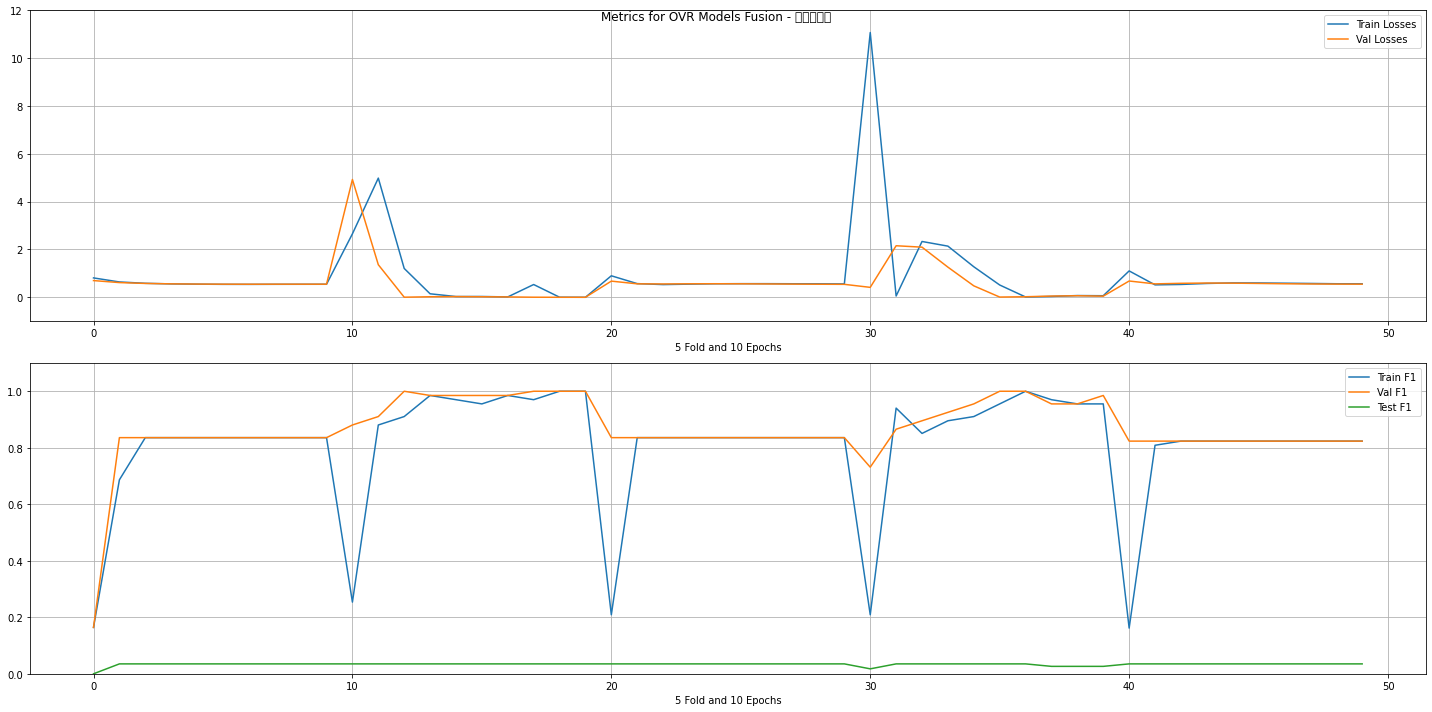

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
8,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
9,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
6,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
7,0.970149,1.000000,0.035088,0.970149,1.000000,0.035088,0.970149,1.000000,0.035088
5,0.955224,1.000000,0.035088,0.955224,1.000000,0.035088,0.955224,1.000000,0.035088
2,0.910448,1.000000,0.035088,0.910448,1.000000,0.035088,0.910448,1.000000,0.035088
3,0.985075,0.985075,0.035088,0.985075,0.985075,0.035088,0.985075,0.985075,0.035088
6,0.985075,0.985075,0.035088,0.985075,0.985075,0.035088,0.985075,0.985075,0.035088
4,0.970149,0.985075,0.035088,0.970149,0.985075,0.035088,0.970149,0.985075,0.035088
5,0.955224,0.985075,0.035088,0.955224,0.985075,0.035088,0.955224,0.985075,0.035088


Training for మాళవిగౌళ with 14 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 67/17


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.811 / Validation Loss : 0.699 [Time : 11.755969 seconds]
Epoch 2/10 : Training Loss: 0.642 / Validation Loss : 0.615 [Time : 11.914957 seconds]
Epoch 3/10 : Training Loss: 0.585 / Validation Loss : 0.580 [Time : 11.75848 seconds]
Epoch 4/10 : Training Loss: 0.560 / Validation Loss : 0.562 [Time : 11.930478 seconds]
Epoch 5/10 : Training Loss: 0.549 / Validation Loss : 0.553 [Time : 11.868665 seconds]
Epoch 6/10 : Training Loss: 0.541 / Validation Loss : 0.549 [Time : 11.706138 seconds]
Epoch 7/10 : Training Loss: 0.540 / Validation Loss : 0.547 [Time : 11.754175 seconds]
Epoch 8/10 : Training Loss: 0.543 / Validation Loss : 0.548 [Time : 10.915396 seconds]
Epoch 9/10 : Training Loss: 0.544 / Validation Loss : 0.548 [Time : 10.902832 seconds]
Epoch 10/10 : Training Loss: 0.545 / Validation Loss : 0.548 [Time : 10.888407 seconds]
*** Confusion Matrix - Training ***
[[56  0]
 [11  0]]
*** Confusion Matrix - Validation ***
[[56  0]
 [

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 1.801 / Validation Loss : 2.595 [Time : 10.914058 seconds]
Epoch 2/10 : Training Loss: 2.281 / Validation Loss : 0.145 [Time : 11.769853 seconds]
Epoch 3/10 : Training Loss: 0.228 / Validation Loss : 0.013 [Time : 11.755553 seconds]
Epoch 4/10 : Training Loss: 0.019 / Validation Loss : 0.019 [Time : 10.968912 seconds]
Epoch 5/10 : Training Loss: 0.020 / Validation Loss : 0.021 [Time : 10.951337 seconds]
Epoch 6/10 : Training Loss: 0.015 / Validation Loss : 0.019 [Time : 10.968457 seconds]
Epoch 7/10 : Training Loss: 0.034 / Validation Loss : 0.015 [Time : 10.914904 seconds]
Epoch 8/10 : Training Loss: 0.012 / Validation Loss : 0.010 [Time : 11.81432 seconds]
Epoch 9/10 : Training Loss: 0.010 / Validation Loss : 0.007 [Time : 11.882472 seconds]
Epoch 10/10 : Training Loss: 0.006 / Validation Loss : 0.004 [Time : 11.77155 seconds]
*** Confusion Matrix - Training ***
[[56  0]
 [ 0 11]]
*** Confusion Matrix - Validation ***
[[56  0]
 [ 0 11]]
Fold 2 : 114.556186

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.898 / Validation Loss : 0.672 [Time : 10.926489 seconds]
Epoch 2/10 : Training Loss: 0.569 / Validation Loss : 0.560 [Time : 11.00529 seconds]
Epoch 3/10 : Training Loss: 0.529 / Validation Loss : 0.554 [Time : 10.890846 seconds]
Epoch 4/10 : Training Loss: 0.547 / Validation Loss : 0.560 [Time : 10.998337 seconds]
Epoch 5/10 : Training Loss: 0.561 / Validation Loss : 0.562 [Time : 10.891812 seconds]
Epoch 6/10 : Training Loss: 0.564 / Validation Loss : 0.559 [Time : 10.859896 seconds]
Epoch 7/10 : Training Loss: 0.564 / Validation Loss : 0.554 [Time : 10.950038 seconds]
Epoch 8/10 : Training Loss: 0.561 / Validation Loss : 0.547 [Time : 10.936562 seconds]
Epoch 9/10 : Training Loss: 0.558 / Validation Loss : 0.541 [Time : 10.948319 seconds]
Epoch 10/10 : Training Loss: 0.552 / Validation Loss : 0.536 [Time : 10.98155 seconds]
*** Confusion Matrix - Training ***
[[56  0]
 [11  0]]
*** Confusion Matrix - Validation ***
[[56  0]
 [11  0]]
Fold 3 : 110.268714

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 4.692 / Validation Loss : 0.298 [Time : 10.867141 seconds]
Epoch 2/10 : Training Loss: 0.351 / Validation Loss : 2.414 [Time : 10.979797 seconds]
Epoch 3/10 : Training Loss: 2.486 / Validation Loss : 0.844 [Time : 10.975681 seconds]
Epoch 4/10 : Training Loss: 0.773 / Validation Loss : 0.200 [Time : 10.907823 seconds]
Epoch 5/10 : Training Loss: 0.193 / Validation Loss : 0.021 [Time : 10.908828 seconds]
Epoch 6/10 : Training Loss: 0.022 / Validation Loss : 0.011 [Time : 10.947014 seconds]
Epoch 7/10 : Training Loss: 0.021 / Validation Loss : 0.026 [Time : 10.893707 seconds]
Epoch 8/10 : Training Loss: 0.023 / Validation Loss : 0.045 [Time : 10.972351 seconds]
Epoch 9/10 : Training Loss: 0.073 / Validation Loss : 0.043 [Time : 10.934135 seconds]
Epoch 10/10 : Training Loss: 0.041 / Validation Loss : 0.030 [Time : 10.975596 seconds]
*** Confusion Matrix - Training ***
[[56  0]
 [ 0 11]]
*** Confusion Matrix - Validation ***
[[56  0]
 [ 0 11]]
Fold 4 : 110.1923

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 1.094 / Validation Loss : 0.670 [Time : 10.956345 seconds]
Epoch 2/10 : Training Loss: 0.511 / Validation Loss : 0.561 [Time : 11.006522 seconds]
Epoch 3/10 : Training Loss: 0.538 / Validation Loss : 0.590 [Time : 11.047125 seconds]
Epoch 4/10 : Training Loss: 0.587 / Validation Loss : 0.601 [Time : 11.013979 seconds]
Epoch 5/10 : Training Loss: 0.610 / Validation Loss : 0.593 [Time : 11.061782 seconds]
Epoch 6/10 : Training Loss: 0.602 / Validation Loss : 0.579 [Time : 11.020122 seconds]
Epoch 7/10 : Training Loss: 0.589 / Validation Loss : 0.565 [Time : 10.947264 seconds]
Epoch 8/10 : Training Loss: 0.576 / Validation Loss : 0.557 [Time : 10.953753 seconds]
Epoch 9/10 : Training Loss: 0.570 / Validation Loss : 0.553 [Time : 10.952725 seconds]
Epoch 10/10 : Training Loss: 0.568 / Validation Loss : 0.552 [Time : 10.950302 seconds]
*** Confusion Matrix - Training ***
[[56  0]
 [12  0]]
*** Confusion Matrix - Validation ***
[[56  0]
 [12  0]]
Fold 5 : 110.7567

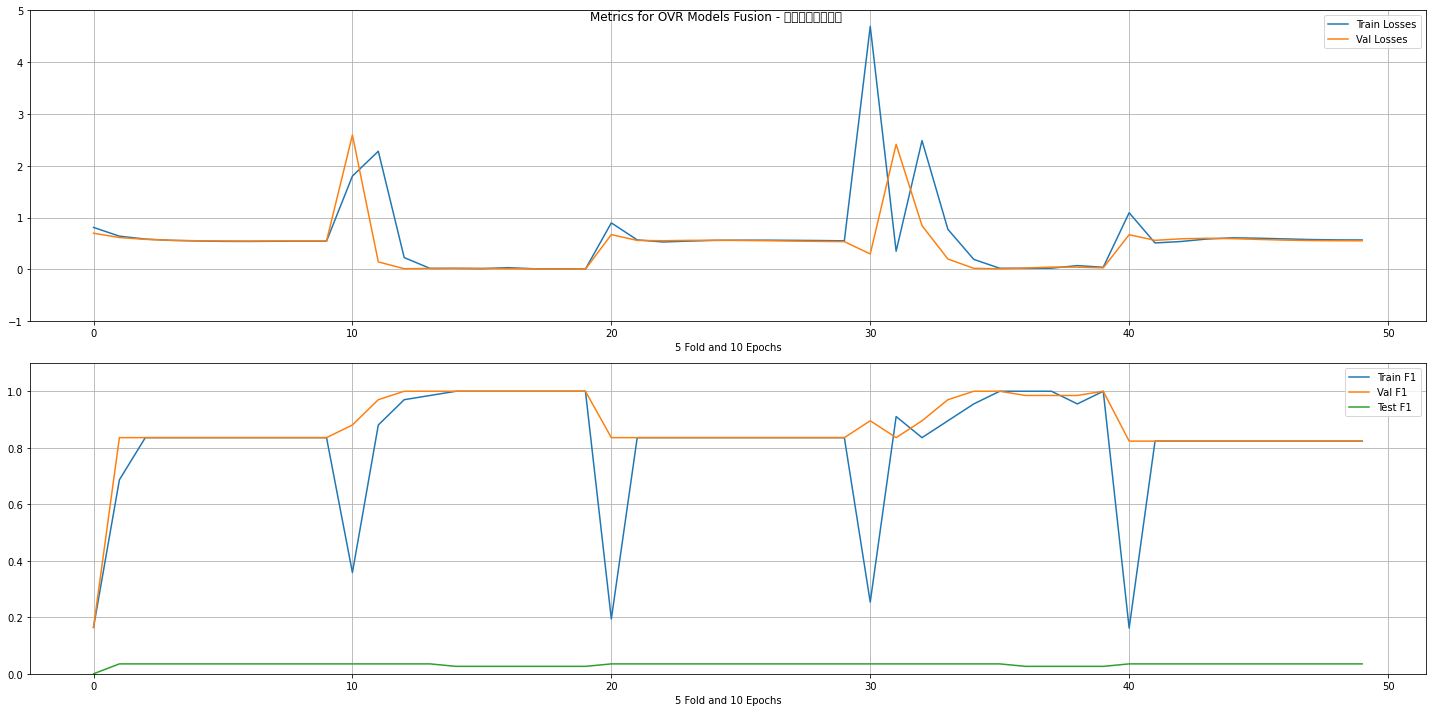

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
4,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
5,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
6,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
7,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
8,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
9,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
5,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
9,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
3,0.985075,1.000000,0.035088,0.985075,1.000000,0.035088,0.985075,1.000000,0.035088
2,0.970149,1.000000,0.035088,0.970149,1.000000,0.035088,0.970149,1.000000,0.035088


Training for ముఖారి with 51 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 244/62


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.821 / Validation Loss : 0.645 [Time : 14.746985 seconds]
Epoch 2/10 : Training Loss: 0.580 / Validation Loss : 0.563 [Time : 14.739478 seconds]
Epoch 3/10 : Training Loss: 0.526 / Validation Loss : 0.524 [Time : 14.737211 seconds]
Epoch 4/10 : Training Loss: 0.505 / Validation Loss : 0.509 [Time : 14.621139 seconds]
Epoch 5/10 : Training Loss: 0.501 / Validation Loss : 0.505 [Time : 14.579525 seconds]
Epoch 6/10 : Training Loss: 0.499 / Validation Loss : 0.504 [Time : 14.589312 seconds]
Epoch 7/10 : Training Loss: 0.506 / Validation Loss : 0.503 [Time : 14.545117 seconds]
Epoch 8/10 : Training Loss: 0.505 / Validation Loss : 0.502 [Time : 14.559597 seconds]
Epoch 9/10 : Training Loss: 0.509 / Validation Loss : 0.501 [Time : 14.540087 seconds]
Epoch 10/10 : Training Loss: 0.503 / Validation Loss : 0.501 [Time : 14.529277 seconds]
*** Confusion Matrix - Training ***
[[204   0]
 [ 40   0]]
*** Confusion Matrix - Validation ***
[[204 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 4.960 / Validation Loss : 12.978 [Time : 13.683931 seconds]
Epoch 2/10 : Training Loss: 12.599 / Validation Loss : 2.289 [Time : 13.689635 seconds]
Epoch 3/10 : Training Loss: 3.205 / Validation Loss : 1.138 [Time : 13.733777 seconds]
Epoch 4/10 : Training Loss: 0.111 / Validation Loss : 0.143 [Time : 14.482632 seconds]
Epoch 5/10 : Training Loss: 0.157 / Validation Loss : 0.133 [Time : 14.526414 seconds]
Epoch 6/10 : Training Loss: 0.160 / Validation Loss : 0.027 [Time : 14.915692 seconds]
Epoch 7/10 : Training Loss: 0.035 / Validation Loss : 0.022 [Time : 14.515917 seconds]
Epoch 8/10 : Training Loss: 0.025 / Validation Loss : 0.021 [Time : 14.555083 seconds]
Epoch 9/10 : Training Loss: 0.024 / Validation Loss : 0.018 [Time : 14.576197 seconds]
Epoch 10/10 : Training Loss: 0.021 / Validation Loss : 0.015 [Time : 14.601596 seconds]
*** Confusion Matrix - Training ***
[[204   0]
 [  1  40]]
*** Confusion Matrix - Validation ***
[[204   0]
 [  0  41]]
Fold 2 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.892 / Validation Loss : 0.570 [Time : 13.67463 seconds]
Epoch 2/10 : Training Loss: 0.494 / Validation Loss : 0.520 [Time : 13.690226 seconds]
Epoch 3/10 : Training Loss: 0.503 / Validation Loss : 0.522 [Time : 13.727637 seconds]
Epoch 4/10 : Training Loss: 0.526 / Validation Loss : 0.523 [Time : 13.684286 seconds]
Epoch 5/10 : Training Loss: 0.534 / Validation Loss : 0.522 [Time : 13.664659 seconds]
Epoch 6/10 : Training Loss: 0.535 / Validation Loss : 0.519 [Time : 13.846309 seconds]
Epoch 7/10 : Training Loss: 0.532 / Validation Loss : 0.518 [Time : 13.657504 seconds]
Epoch 8/10 : Training Loss: 0.531 / Validation Loss : 0.517 [Time : 13.656144 seconds]
Epoch 9/10 : Training Loss: 0.524 / Validation Loss : 0.516 [Time : 13.652816 seconds]
Epoch 10/10 : Training Loss: 0.524 / Validation Loss : 0.515 [Time : 13.700971 seconds]
*** Confusion Matrix - Training ***
[[204   0]
 [ 41   0]]
*** Confusion Matrix - Validation ***
[[204   0]
 [ 41   0]]
Fold 3 : 1

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.535 / Validation Loss : 8.968 [Time : 13.741629 seconds]
Epoch 2/10 : Training Loss: 8.736 / Validation Loss : 2.893 [Time : 13.669154 seconds]
Epoch 3/10 : Training Loss: 3.077 / Validation Loss : 1.222 [Time : 13.756489 seconds]
Epoch 4/10 : Training Loss: 0.361 / Validation Loss : 0.236 [Time : 13.79281 seconds]
Epoch 5/10 : Training Loss: 0.251 / Validation Loss : 0.267 [Time : 13.707415 seconds]
Epoch 6/10 : Training Loss: 0.276 / Validation Loss : 0.048 [Time : 13.695622 seconds]
Epoch 7/10 : Training Loss: 0.068 / Validation Loss : 0.047 [Time : 13.708416 seconds]
Epoch 8/10 : Training Loss: 0.051 / Validation Loss : 0.036 [Time : 13.669086 seconds]
Epoch 9/10 : Training Loss: 0.031 / Validation Loss : 0.024 [Time : 13.710076 seconds]
Epoch 10/10 : Training Loss: 0.027 / Validation Loss : 0.019 [Time : 13.723211 seconds]
*** Confusion Matrix - Training ***
[[204   0]
 [  1  40]]
*** Confusion Matrix - Validation ***
[[204   0]
 [  1  40]]
Fold 4 : 1

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.920 / Validation Loss : 0.510 [Time : 13.700236 seconds]
Epoch 2/10 : Training Loss: 0.466 / Validation Loss : 0.543 [Time : 13.677184 seconds]
Epoch 3/10 : Training Loss: 0.547 / Validation Loss : 0.541 [Time : 13.718864 seconds]
Epoch 4/10 : Training Loss: 0.564 / Validation Loss : 0.521 [Time : 13.683922 seconds]
Epoch 5/10 : Training Loss: 0.546 / Validation Loss : 0.511 [Time : 13.657169 seconds]
Epoch 6/10 : Training Loss: 0.533 / Validation Loss : 0.509 [Time : 13.732617 seconds]
Epoch 7/10 : Training Loss: 0.525 / Validation Loss : 0.509 [Time : 13.684519 seconds]
Epoch 8/10 : Training Loss: 0.518 / Validation Loss : 0.509 [Time : 13.706894 seconds]
Epoch 9/10 : Training Loss: 0.517 / Validation Loss : 0.509 [Time : 13.754647 seconds]
Epoch 10/10 : Training Loss: 0.518 / Validation Loss : 0.509 [Time : 13.677946 seconds]
*** Confusion Matrix - Training ***
[[204   0]
 [ 41   0]]
*** Confusion Matrix - Validation ***
[[204   0]
 [ 41   0]]
Fold 5 : 

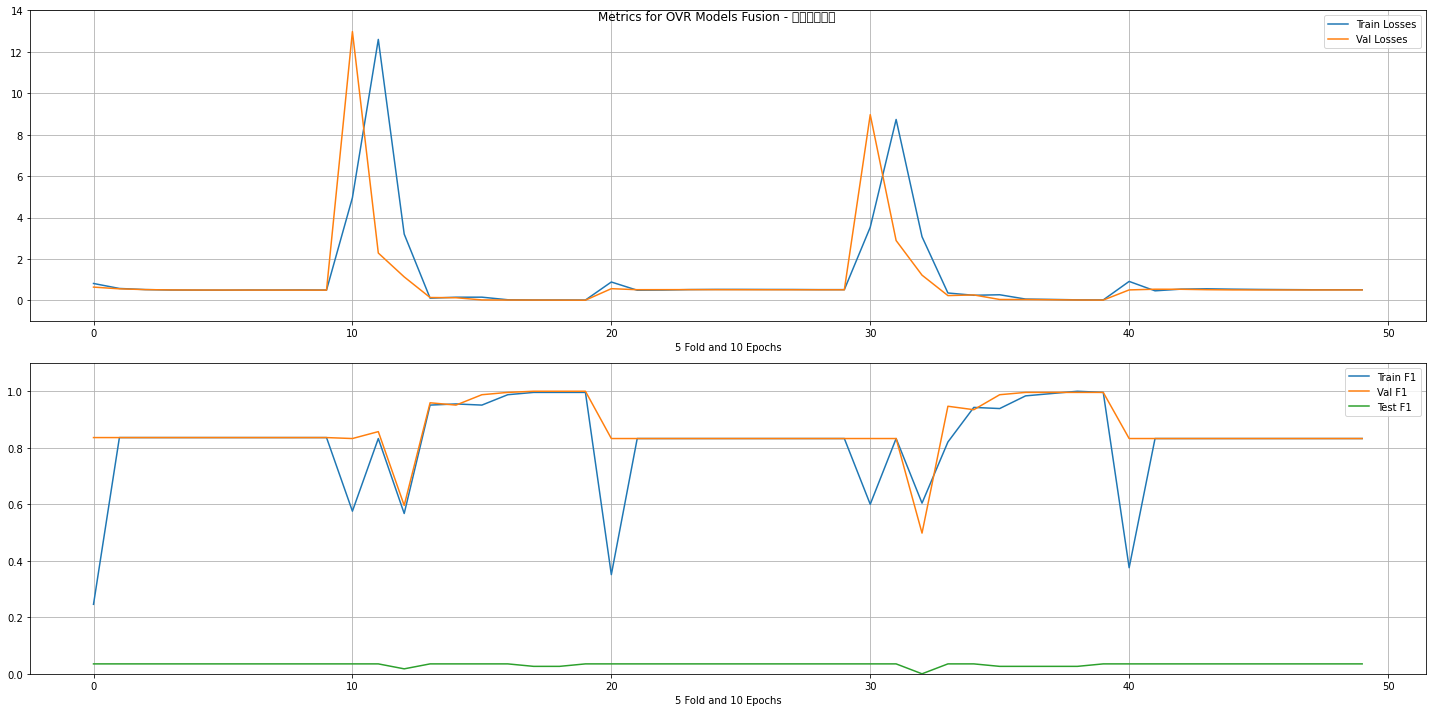

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
7,0.995918,1.000000,0.026316,0.995918,1.000000,0.026316,0.995918,1.000000,0.026316
8,0.995918,1.000000,0.026316,0.995918,1.000000,0.026316,0.995918,1.000000,0.026316
9,0.995918,1.000000,0.035088,0.995918,1.000000,0.035088,0.995918,1.000000,0.035088
8,1.000000,0.995918,0.026316,1.000000,0.995918,0.026316,1.000000,0.995918,0.026316
9,0.995918,0.995918,0.035088,0.995918,0.995918,0.035088,0.995918,0.995918,0.035088
7,0.991837,0.995918,0.026316,0.991837,0.995918,0.026316,0.991837,0.995918,0.026316
6,0.987755,0.995918,0.035088,0.987755,0.995918,0.035088,0.987755,0.995918,0.035088
6,0.983673,0.995918,0.026316,0.983673,0.995918,0.026316,0.983673,0.995918,0.026316
5,0.951020,0.987755,0.035088,0.951020,0.987755,0.035088,0.951020,0.987755,0.035088
5,0.938776,0.987755,0.026316,0.938776,0.987755,0.026316,0.938776,0.987755,0.026316


Training for రామక్రియ with 54 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 259/65


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.822 / Validation Loss : 0.639 [Time : 14.791062 seconds]
Epoch 2/10 : Training Loss: 0.579 / Validation Loss : 0.558 [Time : 14.875707 seconds]
Epoch 3/10 : Training Loss: 0.519 / Validation Loss : 0.514 [Time : 14.88924 seconds]
Epoch 4/10 : Training Loss: 0.492 / Validation Loss : 0.496 [Time : 14.823087 seconds]
Epoch 5/10 : Training Loss: 0.485 / Validation Loss : 0.489 [Time : 14.819846 seconds]
Epoch 6/10 : Training Loss: 0.484 / Validation Loss : 0.488 [Time : 14.773872 seconds]
Epoch 7/10 : Training Loss: 0.483 / Validation Loss : 0.487 [Time : 14.908338 seconds]
Epoch 8/10 : Training Loss: 0.488 / Validation Loss : 0.487 [Time : 14.821487 seconds]
Epoch 9/10 : Training Loss: 0.488 / Validation Loss : 0.486 [Time : 14.797132 seconds]
Epoch 10/10 : Training Loss: 0.493 / Validation Loss : 0.486 [Time : 14.784475 seconds]
*** Confusion Matrix - Training ***
[[216   0]
 [ 43   0]]
*** Confusion Matrix - Validation ***
[[216  

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 5.035 / Validation Loss : 8.955 [Time : 13.972316 seconds]
Epoch 2/10 : Training Loss: 9.002 / Validation Loss : 4.673 [Time : 13.992162 seconds]
Epoch 3/10 : Training Loss: 4.315 / Validation Loss : 0.214 [Time : 14.790117 seconds]
Epoch 4/10 : Training Loss: 0.872 / Validation Loss : 0.118 [Time : 14.814315 seconds]
Epoch 5/10 : Training Loss: 0.085 / Validation Loss : 0.432 [Time : 14.013946 seconds]
Epoch 6/10 : Training Loss: 0.447 / Validation Loss : 0.113 [Time : 14.872826 seconds]
Epoch 7/10 : Training Loss: 0.121 / Validation Loss : 0.033 [Time : 15.087524 seconds]
Epoch 8/10 : Training Loss: 0.043 / Validation Loss : 0.034 [Time : 13.980691 seconds]
Epoch 9/10 : Training Loss: 0.037 / Validation Loss : 0.028 [Time : 14.833671 seconds]
Epoch 10/10 : Training Loss: 0.024 / Validation Loss : 0.021 [Time : 14.820459 seconds]
*** Confusion Matrix - Training ***
[[216   0]
 [  1  42]]
*** Confusion Matrix - Validation ***
[[216   0]
 [  1  42]]
Fold 2 : 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.873 / Validation Loss : 0.538 [Time : 13.960076 seconds]
Epoch 2/10 : Training Loss: 0.468 / Validation Loss : 0.493 [Time : 13.947442 seconds]
Epoch 3/10 : Training Loss: 0.479 / Validation Loss : 0.495 [Time : 13.980397 seconds]
Epoch 4/10 : Training Loss: 0.497 / Validation Loss : 0.496 [Time : 13.992437 seconds]
Epoch 5/10 : Training Loss: 0.506 / Validation Loss : 0.494 [Time : 13.985027 seconds]
Epoch 6/10 : Training Loss: 0.505 / Validation Loss : 0.492 [Time : 13.986356 seconds]
Epoch 7/10 : Training Loss: 0.503 / Validation Loss : 0.490 [Time : 14.042963 seconds]
Epoch 8/10 : Training Loss: 0.500 / Validation Loss : 0.488 [Time : 13.995015 seconds]
Epoch 9/10 : Training Loss: 0.497 / Validation Loss : 0.487 [Time : 13.960756 seconds]
Epoch 10/10 : Training Loss: 0.495 / Validation Loss : 0.487 [Time : 14.051301 seconds]
*** Confusion Matrix - Training ***
[[216   0]
 [ 43   0]]
*** Confusion Matrix - Validation ***
[[216   0]
 [ 43   0]]
Fold 3 : 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 4.064 / Validation Loss : 6.210 [Time : 13.973667 seconds]
Epoch 2/10 : Training Loss: 6.115 / Validation Loss : 2.797 [Time : 14.006865 seconds]
Epoch 3/10 : Training Loss: 2.667 / Validation Loss : 0.452 [Time : 13.956401 seconds]
Epoch 4/10 : Training Loss: 0.548 / Validation Loss : 0.171 [Time : 13.984593 seconds]
Epoch 5/10 : Training Loss: 0.171 / Validation Loss : 0.363 [Time : 14.026633 seconds]
Epoch 6/10 : Training Loss: 0.372 / Validation Loss : 0.104 [Time : 13.945835 seconds]
Epoch 7/10 : Training Loss: 0.124 / Validation Loss : 0.078 [Time : 13.995299 seconds]
Epoch 8/10 : Training Loss: 0.085 / Validation Loss : 0.068 [Time : 14.05297 seconds]
Epoch 9/10 : Training Loss: 0.059 / Validation Loss : 0.052 [Time : 13.948902 seconds]
Epoch 10/10 : Training Loss: 0.047 / Validation Loss : 0.046 [Time : 14.002255 seconds]
*** Confusion Matrix - Training ***
[[216   0]
 [  4  39]]
*** Confusion Matrix - Validation ***
[[216   0]
 [  5  38]]
Fold 4 : 1

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.944 / Validation Loss : 0.492 [Time : 13.992593 seconds]
Epoch 2/10 : Training Loss: 0.449 / Validation Loss : 0.512 [Time : 13.988228 seconds]
Epoch 3/10 : Training Loss: 0.520 / Validation Loss : 0.512 [Time : 13.953095 seconds]
Epoch 4/10 : Training Loss: 0.530 / Validation Loss : 0.499 [Time : 14.004829 seconds]
Epoch 5/10 : Training Loss: 0.518 / Validation Loss : 0.493 [Time : 13.967798 seconds]
Epoch 6/10 : Training Loss: 0.517 / Validation Loss : 0.490 [Time : 13.955641 seconds]
Epoch 7/10 : Training Loss: 0.503 / Validation Loss : 0.490 [Time : 13.954408 seconds]
Epoch 8/10 : Training Loss: 0.502 / Validation Loss : 0.489 [Time : 14.005261 seconds]
Epoch 9/10 : Training Loss: 0.500 / Validation Loss : 0.489 [Time : 13.921711 seconds]
Epoch 10/10 : Training Loss: 0.499 / Validation Loss : 0.488 [Time : 13.911238 seconds]
*** Confusion Matrix - Training ***
[[216   0]
 [ 44   0]]
*** Confusion Matrix - Validation ***
[[216   0]
 [ 44   0]]
Fold 5 : 

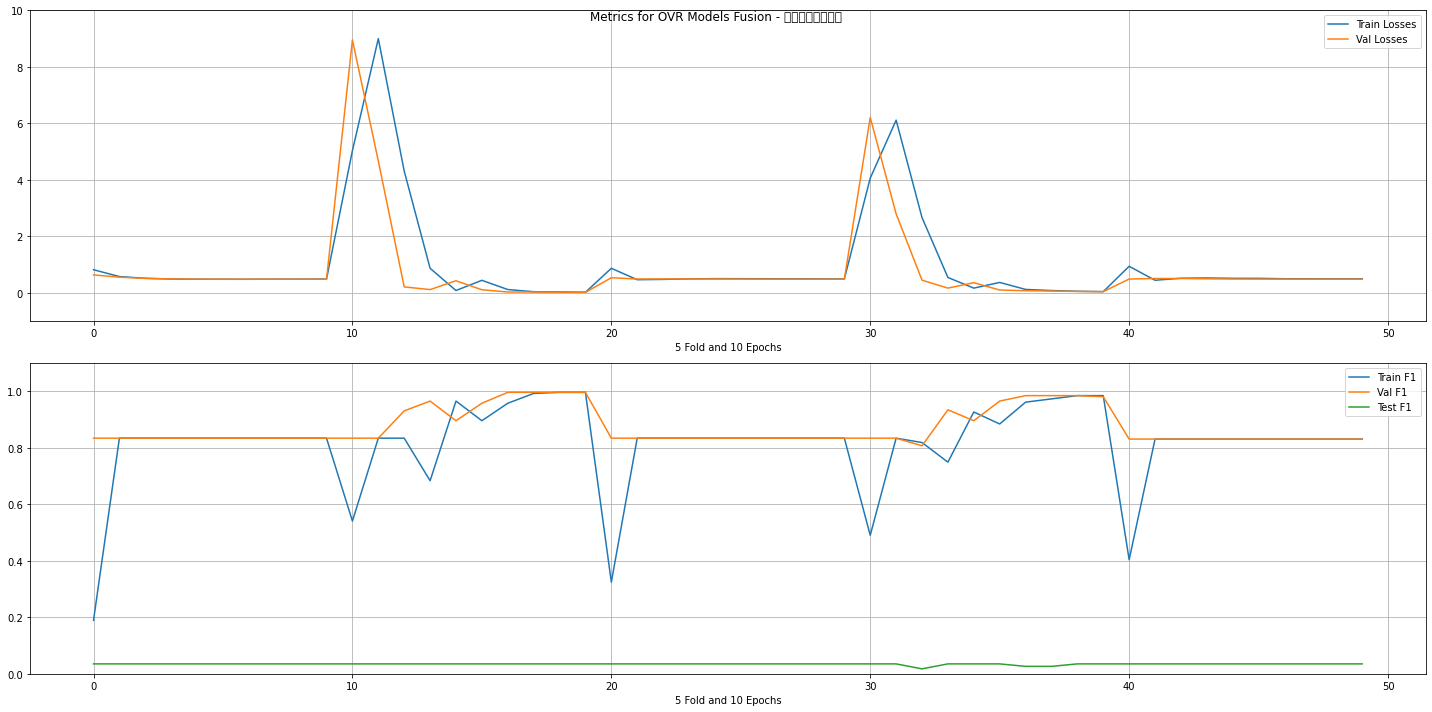

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
8,0.996139,0.996139,0.035088,0.996139,0.996139,0.035088,0.996139,0.996139,0.035088
9,0.996139,0.996139,0.035088,0.996139,0.996139,0.035088,0.996139,0.996139,0.035088
7,0.992278,0.996139,0.035088,0.992278,0.996139,0.035088,0.992278,0.996139,0.035088
6,0.957529,0.996139,0.035088,0.957529,0.996139,0.035088,0.957529,0.996139,0.035088
8,0.984556,0.984556,0.035088,0.984556,0.984556,0.035088,0.984556,0.984556,0.035088
7,0.972973,0.984556,0.026316,0.972973,0.984556,0.026316,0.972973,0.984556,0.026316
6,0.961390,0.984556,0.026316,0.961390,0.984556,0.026316,0.961390,0.984556,0.026316
9,0.984556,0.980695,0.035088,0.984556,0.980695,0.035088,0.984556,0.980695,0.035088
5,0.884170,0.965251,0.035088,0.884170,0.965251,0.035088,0.884170,0.965251,0.035088
3,0.683398,0.965251,0.035088,0.683398,0.965251,0.035088,0.683398,0.965251,0.035088


Training for లలిత with 88 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 422/106


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.836 / Validation Loss : 0.656 [Time : 17.355525 seconds]
Epoch 2/10 : Training Loss: 0.614 / Validation Loss : 0.588 [Time : 17.487132 seconds]
Epoch 3/10 : Training Loss: 0.551 / Validation Loss : 0.538 [Time : 17.60846 seconds]
Epoch 4/10 : Training Loss: 0.511 / Validation Loss : 0.505 [Time : 17.582816 seconds]
Epoch 5/10 : Training Loss: 0.490 / Validation Loss : 0.489 [Time : 17.487872 seconds]
Epoch 6/10 : Training Loss: 0.483 / Validation Loss : 0.480 [Time : 17.515923 seconds]
Epoch 7/10 : Training Loss: 0.475 / Validation Loss : 0.476 [Time : 17.42723 seconds]
Epoch 8/10 : Training Loss: 0.475 / Validation Loss : 0.474 [Time : 17.307956 seconds]
Epoch 9/10 : Training Loss: 0.476 / Validation Loss : 0.472 [Time : 17.414688 seconds]
Epoch 10/10 : Training Loss: 0.474 / Validation Loss : 0.472 [Time : 17.314392 seconds]
*** Confusion Matrix - Training ***
[[352   0]
 [ 70   0]]
*** Confusion Matrix - Validation ***
[[352   

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 5.939 / Validation Loss : 10.928 [Time : 16.52528 seconds]
Epoch 2/10 : Training Loss: 10.666 / Validation Loss : 4.028 [Time : 16.57232 seconds]
Epoch 3/10 : Training Loss: 3.959 / Validation Loss : 0.372 [Time : 17.341505 seconds]
Epoch 4/10 : Training Loss: 0.129 / Validation Loss : 0.263 [Time : 17.533251 seconds]
Epoch 5/10 : Training Loss: 0.310 / Validation Loss : 0.098 [Time : 17.408509 seconds]
Epoch 6/10 : Training Loss: 0.089 / Validation Loss : 0.077 [Time : 17.395726 seconds]
Epoch 7/10 : Training Loss: 0.083 / Validation Loss : 0.059 [Time : 17.440653 seconds]
Epoch 8/10 : Training Loss: 0.070 / Validation Loss : 0.047 [Time : 17.332272 seconds]
Epoch 9/10 : Training Loss: 0.054 / Validation Loss : 0.040 [Time : 17.429279 seconds]
Epoch 10/10 : Training Loss: 0.048 / Validation Loss : 0.034 [Time : 17.354003 seconds]
*** Confusion Matrix - Training ***
[[352   0]
 [  2  68]]
*** Confusion Matrix - Validation ***
[[352   0]
 [  1  69]]
Fold 2 : 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.859 / Validation Loss : 0.524 [Time : 16.688266 seconds]
Epoch 2/10 : Training Loss: 0.465 / Validation Loss : 0.471 [Time : 16.57932 seconds]
Epoch 3/10 : Training Loss: 0.459 / Validation Loss : 0.468 [Time : 16.530696 seconds]
Epoch 4/10 : Training Loss: 0.472 / Validation Loss : 0.468 [Time : 16.635666 seconds]
Epoch 5/10 : Training Loss: 0.477 / Validation Loss : 0.468 [Time : 16.59067 seconds]
Epoch 6/10 : Training Loss: 0.480 / Validation Loss : 0.467 [Time : 16.50754 seconds]
Epoch 7/10 : Training Loss: 0.478 / Validation Loss : 0.467 [Time : 16.529931 seconds]
Epoch 8/10 : Training Loss: 0.483 / Validation Loss : 0.465 [Time : 16.518609 seconds]
Epoch 9/10 : Training Loss: 0.476 / Validation Loss : 0.465 [Time : 16.56597 seconds]
Epoch 10/10 : Training Loss: 0.474 / Validation Loss : 0.464 [Time : 16.502329 seconds]
*** Confusion Matrix - Training ***
[[352   0]
 [ 70   0]]
*** Confusion Matrix - Validation ***
[[352   0]
 [ 70   0]]
Fold 3 : 166.

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.804 / Validation Loss : 8.754 [Time : 16.555993 seconds]
Epoch 2/10 : Training Loss: 8.587 / Validation Loss : 3.442 [Time : 16.526249 seconds]
Epoch 3/10 : Training Loss: 3.249 / Validation Loss : 0.395 [Time : 16.495588 seconds]
Epoch 4/10 : Training Loss: 0.451 / Validation Loss : 0.444 [Time : 16.52699 seconds]
Epoch 5/10 : Training Loss: 0.473 / Validation Loss : 0.173 [Time : 16.55591 seconds]
Epoch 6/10 : Training Loss: 0.203 / Validation Loss : 0.136 [Time : 16.53207 seconds]
Epoch 7/10 : Training Loss: 0.139 / Validation Loss : 0.114 [Time : 16.547118 seconds]
Epoch 8/10 : Training Loss: 0.125 / Validation Loss : 0.095 [Time : 16.544872 seconds]
Epoch 9/10 : Training Loss: 0.110 / Validation Loss : 0.079 [Time : 16.538609 seconds]
Epoch 10/10 : Training Loss: 0.084 / Validation Loss : 0.069 [Time : 16.622149 seconds]
*** Confusion Matrix - Training ***
[[352   0]
 [  7  64]]
*** Confusion Matrix - Validation ***
[[352   0]
 [  3  68]]
Fold 4 : 166

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.901 / Validation Loss : 0.479 [Time : 16.586849 seconds]
Epoch 2/10 : Training Loss: 0.456 / Validation Loss : 0.491 [Time : 16.562232 seconds]
Epoch 3/10 : Training Loss: 0.497 / Validation Loss : 0.495 [Time : 16.569739 seconds]
Epoch 4/10 : Training Loss: 0.518 / Validation Loss : 0.483 [Time : 16.528352 seconds]
Epoch 5/10 : Training Loss: 0.511 / Validation Loss : 0.479 [Time : 16.528397 seconds]
Epoch 6/10 : Training Loss: 0.504 / Validation Loss : 0.478 [Time : 16.550898 seconds]
Epoch 7/10 : Training Loss: 0.493 / Validation Loss : 0.478 [Time : 16.574608 seconds]
Epoch 8/10 : Training Loss: 0.500 / Validation Loss : 0.477 [Time : 16.546495 seconds]
Epoch 9/10 : Training Loss: 0.494 / Validation Loss : 0.477 [Time : 16.582713 seconds]
Epoch 10/10 : Training Loss: 0.493 / Validation Loss : 0.475 [Time : 16.609356 seconds]
*** Confusion Matrix - Training ***
[[352   0]
 [ 71   0]]
*** Confusion Matrix - Validation ***
[[352   0]
 [ 71   0]]
Fold 5 : 

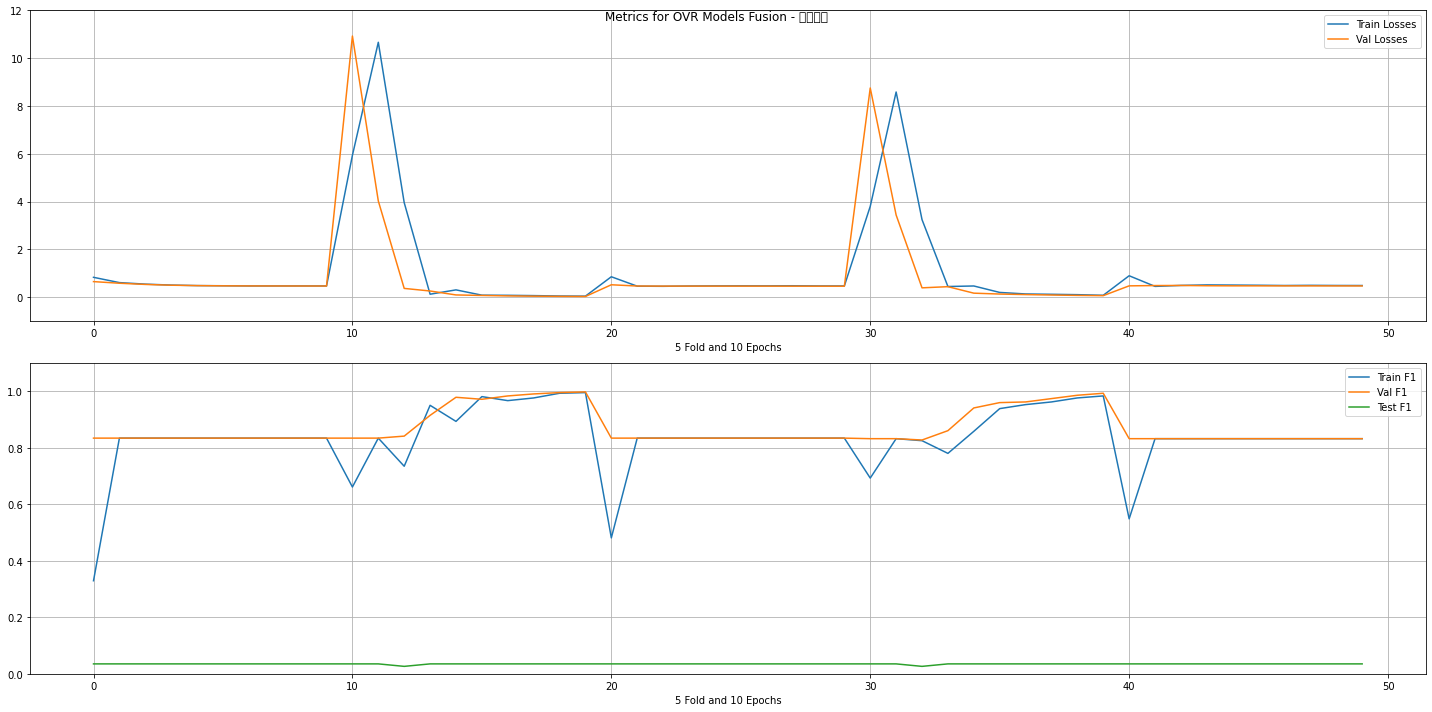

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
9,0.995261,0.997630,0.035088,0.995261,0.997630,0.035088,0.995261,0.997630,0.035088
8,0.992891,0.995261,0.035088,0.992891,0.995261,0.035088,0.992891,0.995261,0.035088
9,0.983452,0.992908,0.035088,0.983452,0.992908,0.035088,0.983452,0.992908,0.035088
7,0.976303,0.990521,0.035088,0.976303,0.990521,0.035088,0.976303,0.990521,0.035088
8,0.976359,0.985816,0.035088,0.976359,0.985816,0.035088,0.976359,0.985816,0.035088
6,0.966825,0.983412,0.035088,0.966825,0.983412,0.035088,0.966825,0.983412,0.035088
4,0.893365,0.978673,0.035088,0.893365,0.978673,0.035088,0.893365,0.978673,0.035088
7,0.962175,0.973995,0.035088,0.962175,0.973995,0.035088,0.962175,0.973995,0.035088
5,0.981043,0.971564,0.035088,0.981043,0.971564,0.035088,0.981043,0.971564,0.035088
6,0.952719,0.962175,0.035088,0.952719,0.962175,0.035088,0.952719,0.962175,0.035088


Training for వరాళి with 20 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 96/24


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.815 / Validation Loss : 0.717 [Time : 12.167952 seconds]
Epoch 2/10 : Training Loss: 0.671 / Validation Loss : 0.649 [Time : 12.262913 seconds]
Epoch 3/10 : Training Loss: 0.620 / Validation Loss : 0.618 [Time : 12.325818 seconds]
Epoch 4/10 : Training Loss: 0.602 / Validation Loss : 0.603 [Time : 12.237582 seconds]
Epoch 5/10 : Training Loss: 0.592 / Validation Loss : 0.596 [Time : 12.253223 seconds]
Epoch 6/10 : Training Loss: 0.584 / Validation Loss : 0.592 [Time : 12.166631 seconds]
Epoch 7/10 : Training Loss: 0.585 / Validation Loss : 0.590 [Time : 12.15854 seconds]
Epoch 8/10 : Training Loss: 0.591 / Validation Loss : 0.590 [Time : 12.29445 seconds]
Epoch 9/10 : Training Loss: 0.588 / Validation Loss : 0.590 [Time : 11.389498 seconds]
Epoch 10/10 : Training Loss: 0.589 / Validation Loss : 0.590 [Time : 11.340715 seconds]
*** Confusion Matrix - Training ***
[[80  0]
 [16  0]]
*** Confusion Matrix - Validation ***
[[80  0]
 [1

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 2.617 / Validation Loss : 1.184 [Time : 11.332494 seconds]
Epoch 2/10 : Training Loss: 1.265 / Validation Loss : 0.521 [Time : 12.182176 seconds]
Epoch 3/10 : Training Loss: 0.510 / Validation Loss : 0.098 [Time : 12.177357 seconds]
Epoch 4/10 : Training Loss: 0.104 / Validation Loss : 0.033 [Time : 12.325443 seconds]
Epoch 5/10 : Training Loss: 0.040 / Validation Loss : 0.026 [Time : 12.294321 seconds]
Epoch 6/10 : Training Loss: 0.026 / Validation Loss : 0.024 [Time : 12.257423 seconds]
Epoch 7/10 : Training Loss: 0.031 / Validation Loss : 0.024 [Time : 12.157471 seconds]
Epoch 8/10 : Training Loss: 0.026 / Validation Loss : 0.020 [Time : 12.806583 seconds]
Epoch 9/10 : Training Loss: 0.022 / Validation Loss : 0.017 [Time : 12.194002 seconds]
Epoch 10/10 : Training Loss: 0.019 / Validation Loss : 0.014 [Time : 12.137559 seconds]
*** Confusion Matrix - Training ***
[[80  0]
 [ 0 16]]
*** Confusion Matrix - Validation ***
[[80  0]
 [ 0 16]]
Fold 2 : 122.7061

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.916 / Validation Loss : 0.704 [Time : 11.306622 seconds]
Epoch 2/10 : Training Loss: 0.614 / Validation Loss : 0.595 [Time : 11.316594 seconds]
Epoch 3/10 : Training Loss: 0.557 / Validation Loss : 0.581 [Time : 11.326417 seconds]
Epoch 4/10 : Training Loss: 0.566 / Validation Loss : 0.585 [Time : 11.28987 seconds]
Epoch 5/10 : Training Loss: 0.581 / Validation Loss : 0.589 [Time : 11.282869 seconds]
Epoch 6/10 : Training Loss: 0.584 / Validation Loss : 0.589 [Time : 11.378404 seconds]
Epoch 7/10 : Training Loss: 0.594 / Validation Loss : 0.587 [Time : 11.321632 seconds]
Epoch 8/10 : Training Loss: 0.592 / Validation Loss : 0.582 [Time : 11.359192 seconds]
Epoch 9/10 : Training Loss: 0.591 / Validation Loss : 0.577 [Time : 11.359818 seconds]
Epoch 10/10 : Training Loss: 0.582 / Validation Loss : 0.573 [Time : 11.359733 seconds]
*** Confusion Matrix - Training ***
[[80  0]
 [16  0]]
*** Confusion Matrix - Validation ***
[[80  0]
 [16  0]]
Fold 3 : 114.22891

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 6.808 / Validation Loss : 0.393 [Time : 11.285076 seconds]
Epoch 2/10 : Training Loss: 0.289 / Validation Loss : 3.216 [Time : 11.309951 seconds]
Epoch 3/10 : Training Loss: 2.988 / Validation Loss : 1.890 [Time : 11.342952 seconds]
Epoch 4/10 : Training Loss: 2.064 / Validation Loss : 0.358 [Time : 11.324394 seconds]
Epoch 5/10 : Training Loss: 0.381 / Validation Loss : 0.086 [Time : 11.400641 seconds]
Epoch 6/10 : Training Loss: 0.132 / Validation Loss : 0.187 [Time : 11.338658 seconds]
Epoch 7/10 : Training Loss: 0.269 / Validation Loss : 0.307 [Time : 11.364319 seconds]
Epoch 8/10 : Training Loss: 0.274 / Validation Loss : 0.171 [Time : 11.339566 seconds]
Epoch 9/10 : Training Loss: 0.105 / Validation Loss : 0.059 [Time : 11.340438 seconds]
Epoch 10/10 : Training Loss: 0.046 / Validation Loss : 0.035 [Time : 11.296333 seconds]
*** Confusion Matrix - Training ***
[[79  1]
 [ 1 15]]
*** Confusion Matrix - Validation ***
[[80  0]
 [ 1 15]]
Fold 4 : 114.1625

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 1.116 / Validation Loss : 0.715 [Time : 11.380137 seconds]
Epoch 2/10 : Training Loss: 0.563 / Validation Loss : 0.591 [Time : 11.318138 seconds]
Epoch 3/10 : Training Loss: 0.558 / Validation Loss : 0.613 [Time : 11.303839 seconds]
Epoch 4/10 : Training Loss: 0.605 / Validation Loss : 0.626 [Time : 11.339135 seconds]
Epoch 5/10 : Training Loss: 0.632 / Validation Loss : 0.624 [Time : 11.334438 seconds]
Epoch 6/10 : Training Loss: 0.635 / Validation Loss : 0.613 [Time : 11.30642 seconds]
Epoch 7/10 : Training Loss: 0.629 / Validation Loss : 0.601 [Time : 11.345105 seconds]
Epoch 8/10 : Training Loss: 0.622 / Validation Loss : 0.592 [Time : 11.57656 seconds]
Epoch 9/10 : Training Loss: 0.608 / Validation Loss : 0.588 [Time : 11.364727 seconds]
Epoch 10/10 : Training Loss: 0.604 / Validation Loss : 0.587 [Time : 11.3468 seconds]
*** Confusion Matrix - Training ***
[[80  0]
 [16  0]]
*** Confusion Matrix - Validation ***
[[80  0]
 [16  0]]
Fold 5 : 114.46044 se

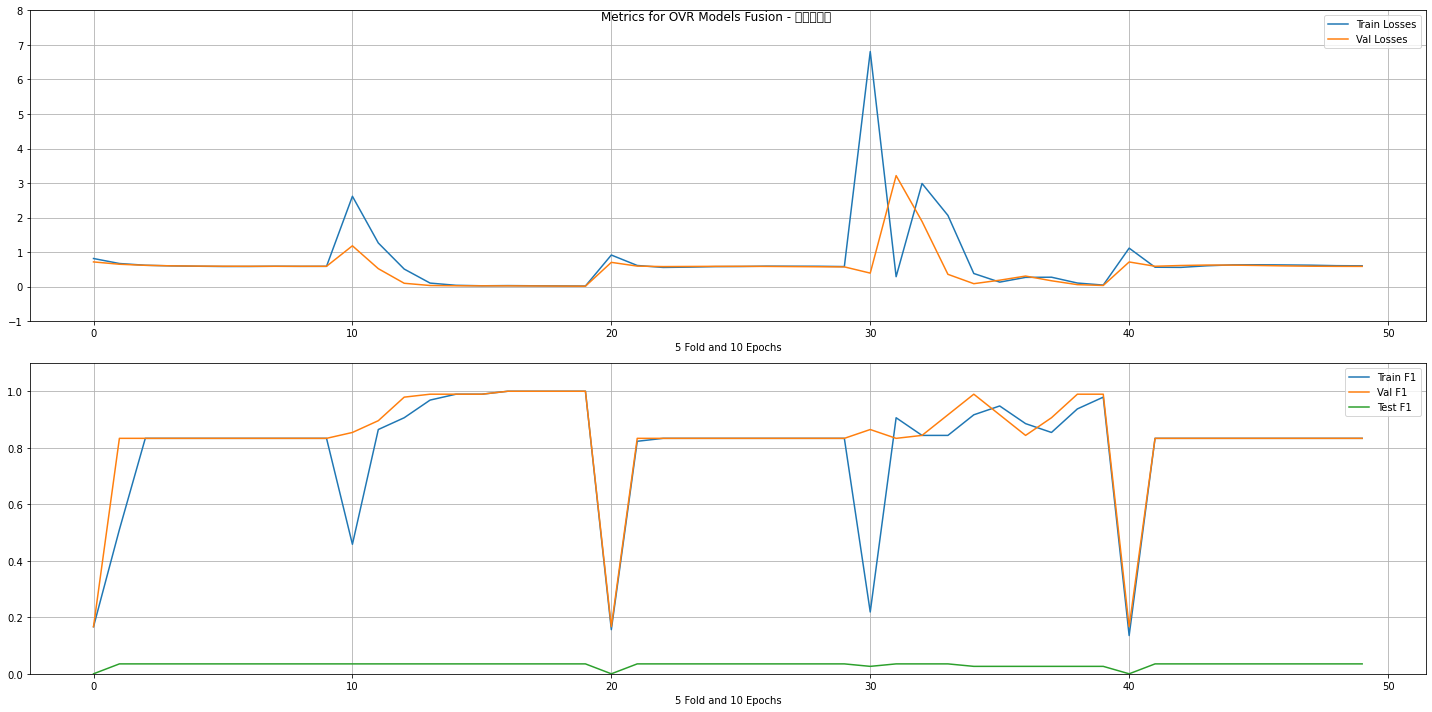

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
6,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
7,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
8,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
9,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
4,0.989583,0.989583,0.035088,0.989583,0.989583,0.035088,0.989583,0.989583,0.035088
5,0.989583,0.989583,0.035088,0.989583,0.989583,0.035088,0.989583,0.989583,0.035088
9,0.979167,0.989583,0.026316,0.979167,0.989583,0.026316,0.979167,0.989583,0.026316
3,0.968750,0.989583,0.035088,0.968750,0.989583,0.035088,0.968750,0.989583,0.035088
8,0.937500,0.989583,0.026316,0.937500,0.989583,0.026316,0.937500,0.989583,0.026316
4,0.916667,0.989583,0.026316,0.916667,0.989583,0.026316,0.916667,0.989583,0.026316


Training for శంకరాభరణం with 61 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 292/74


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.827 / Validation Loss : 0.642 [Time : 15.297151 seconds]
Epoch 2/10 : Training Loss: 0.588 / Validation Loss : 0.564 [Time : 15.411776 seconds]
Epoch 3/10 : Training Loss: 0.524 / Validation Loss : 0.516 [Time : 15.42314 seconds]
Epoch 4/10 : Training Loss: 0.488 / Validation Loss : 0.490 [Time : 15.337082 seconds]
Epoch 5/10 : Training Loss: 0.478 / Validation Loss : 0.480 [Time : 15.41255 seconds]
Epoch 6/10 : Training Loss: 0.475 / Validation Loss : 0.477 [Time : 15.420069 seconds]
Epoch 7/10 : Training Loss: 0.474 / Validation Loss : 0.475 [Time : 15.346957 seconds]
Epoch 8/10 : Training Loss: 0.474 / Validation Loss : 0.475 [Time : 17.210313 seconds]
Epoch 9/10 : Training Loss: 0.478 / Validation Loss : 0.474 [Time : 15.390667 seconds]
Epoch 10/10 : Training Loss: 0.480 / Validation Loss : 0.474 [Time : 15.390552 seconds]
*** Confusion Matrix - Training ***
[[244   0]
 [ 48   0]]
*** Confusion Matrix - Validation ***
[[244   

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 4.008 / Validation Loss : 11.782 [Time : 14.520724 seconds]
Epoch 2/10 : Training Loss: 11.696 / Validation Loss : 6.266 [Time : 14.613725 seconds]
Epoch 3/10 : Training Loss: 5.844 / Validation Loss : 0.192 [Time : 15.620742 seconds]
Epoch 4/10 : Training Loss: 0.740 / Validation Loss : 0.110 [Time : 15.717885 seconds]
Epoch 5/10 : Training Loss: 0.050 / Validation Loss : 0.259 [Time : 14.504355 seconds]
Epoch 6/10 : Training Loss: 0.283 / Validation Loss : 0.038 [Time : 15.423025 seconds]
Epoch 7/10 : Training Loss: 0.055 / Validation Loss : 0.042 [Time : 14.594346 seconds]
Epoch 8/10 : Training Loss: 0.043 / Validation Loss : 0.032 [Time : 15.727191 seconds]
Epoch 9/10 : Training Loss: 0.029 / Validation Loss : 0.025 [Time : 15.337787 seconds]
Epoch 10/10 : Training Loss: 0.023 / Validation Loss : 0.022 [Time : 15.441172 seconds]
*** Confusion Matrix - Training ***
[[244   0]
 [  1  48]]
*** Confusion Matrix - Validation ***
[[244   0]
 [  1  48]]
Fold 2 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.891 / Validation Loss : 0.541 [Time : 14.472279 seconds]
Epoch 2/10 : Training Loss: 0.471 / Validation Loss : 0.483 [Time : 14.520327 seconds]
Epoch 3/10 : Training Loss: 0.462 / Validation Loss : 0.478 [Time : 14.529364 seconds]
Epoch 4/10 : Training Loss: 0.477 / Validation Loss : 0.480 [Time : 14.53861 seconds]
Epoch 5/10 : Training Loss: 0.492 / Validation Loss : 0.478 [Time : 14.580808 seconds]
Epoch 6/10 : Training Loss: 0.487 / Validation Loss : 0.477 [Time : 14.503027 seconds]
Epoch 7/10 : Training Loss: 0.489 / Validation Loss : 0.475 [Time : 14.508114 seconds]
Epoch 8/10 : Training Loss: 0.486 / Validation Loss : 0.473 [Time : 14.479909 seconds]
Epoch 9/10 : Training Loss: 0.483 / Validation Loss : 0.473 [Time : 14.496108 seconds]
Epoch 10/10 : Training Loss: 0.482 / Validation Loss : 0.472 [Time : 15.057566 seconds]
*** Confusion Matrix - Training ***
[[244   0]
 [ 49   0]]
*** Confusion Matrix - Validation ***
[[244   0]
 [ 49   0]]
Fold 3 : 1

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 3.711 / Validation Loss : 6.843 [Time : 14.459164 seconds]
Epoch 2/10 : Training Loss: 6.834 / Validation Loss : 3.569 [Time : 14.499084 seconds]
Epoch 3/10 : Training Loss: 3.340 / Validation Loss : 0.209 [Time : 14.471082 seconds]
Epoch 4/10 : Training Loss: 0.541 / Validation Loss : 0.167 [Time : 14.481067 seconds]
Epoch 5/10 : Training Loss: 0.170 / Validation Loss : 0.234 [Time : 14.556235 seconds]
Epoch 6/10 : Training Loss: 0.247 / Validation Loss : 0.098 [Time : 14.4427 seconds]
Epoch 7/10 : Training Loss: 0.115 / Validation Loss : 0.064 [Time : 14.504151 seconds]
Epoch 8/10 : Training Loss: 0.048 / Validation Loss : 0.055 [Time : 14.489026 seconds]
Epoch 9/10 : Training Loss: 0.059 / Validation Loss : 0.044 [Time : 14.496329 seconds]
Epoch 10/10 : Training Loss: 0.048 / Validation Loss : 0.036 [Time : 14.47271 seconds]
*** Confusion Matrix - Training ***
[[244   0]
 [  3  46]]
*** Confusion Matrix - Validation ***
[[244   0]
 [  2  47]]
Fold 4 : 145

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.972 / Validation Loss : 0.481 [Time : 14.555039 seconds]
Epoch 2/10 : Training Loss: 0.442 / Validation Loss : 0.491 [Time : 14.483585 seconds]
Epoch 3/10 : Training Loss: 0.496 / Validation Loss : 0.494 [Time : 14.521731 seconds]
Epoch 4/10 : Training Loss: 0.509 / Validation Loss : 0.486 [Time : 14.513657 seconds]
Epoch 5/10 : Training Loss: 0.507 / Validation Loss : 0.480 [Time : 14.479844 seconds]
Epoch 6/10 : Training Loss: 0.499 / Validation Loss : 0.478 [Time : 14.511047 seconds]
Epoch 7/10 : Training Loss: 0.495 / Validation Loss : 0.477 [Time : 14.507443 seconds]
Epoch 8/10 : Training Loss: 0.493 / Validation Loss : 0.477 [Time : 14.505347 seconds]
Epoch 9/10 : Training Loss: 0.489 / Validation Loss : 0.477 [Time : 14.604516 seconds]
Epoch 10/10 : Training Loss: 0.489 / Validation Loss : 0.477 [Time : 14.50035 seconds]
*** Confusion Matrix - Training ***
[[244   0]
 [ 49   0]]
*** Confusion Matrix - Validation ***
[[244   0]
 [ 49   0]]
Fold 5 : 1

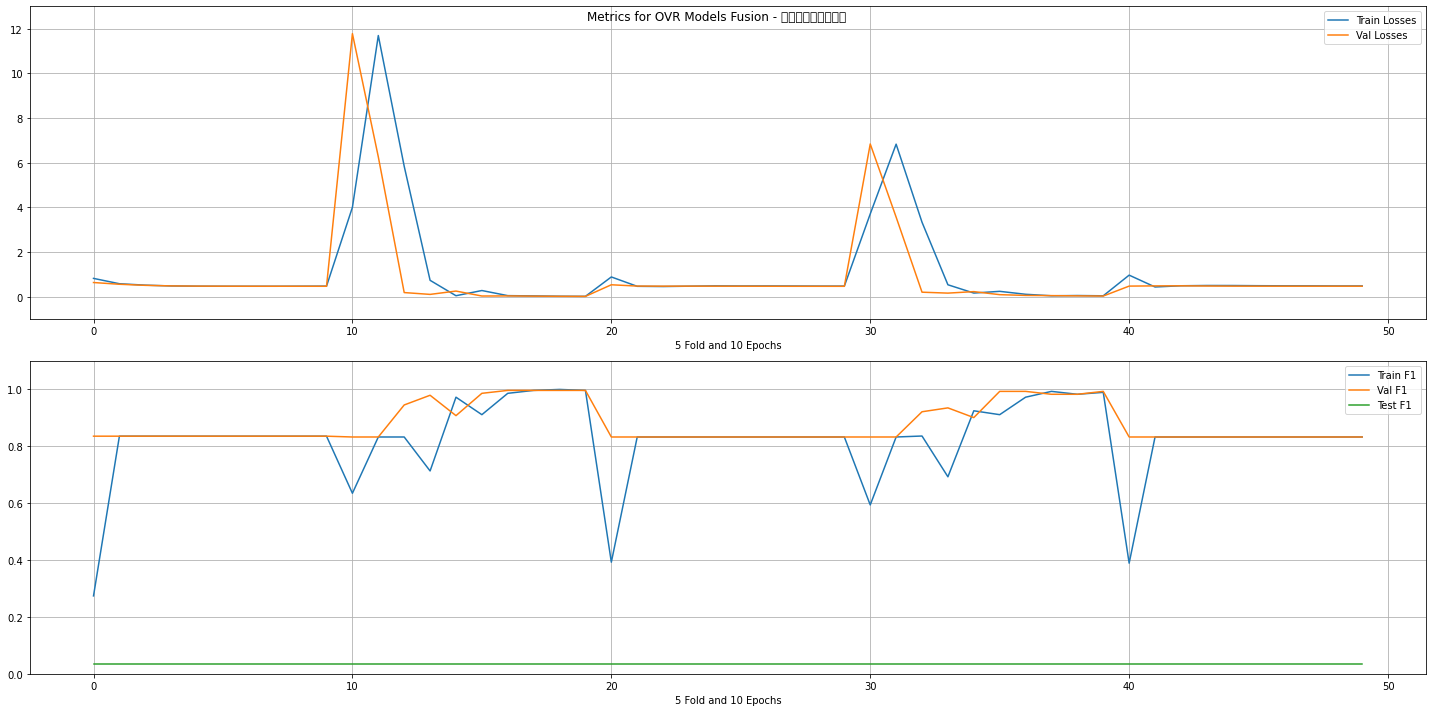

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
8,1.000000,0.996587,0.035088,1.000000,0.996587,0.035088,1.000000,0.996587,0.035088
7,0.996587,0.996587,0.035088,0.996587,0.996587,0.035088,0.996587,0.996587,0.035088
9,0.996587,0.996587,0.035088,0.996587,0.996587,0.035088,0.996587,0.996587,0.035088
6,0.986348,0.996587,0.035088,0.986348,0.996587,0.035088,0.986348,0.996587,0.035088
9,0.989761,0.993174,0.035088,0.989761,0.993174,0.035088,0.989761,0.993174,0.035088
6,0.972696,0.993174,0.035088,0.972696,0.993174,0.035088,0.972696,0.993174,0.035088
5,0.911263,0.993174,0.035088,0.911263,0.993174,0.035088,0.911263,0.993174,0.035088
5,0.911263,0.986348,0.035088,0.911263,0.986348,0.035088,0.911263,0.986348,0.035088
7,0.993174,0.982935,0.035088,0.993174,0.982935,0.035088,0.993174,0.982935,0.035088
8,0.982935,0.982935,0.035088,0.982935,0.982935,0.035088,0.982935,0.982935,0.035088


Training for శుద్ధవసంతం with 28 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 134/34


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.781 / Validation Loss : 0.633 [Time : 12.863596 seconds]
Epoch 2/10 : Training Loss: 0.566 / Validation Loss : 0.542 [Time : 12.895735 seconds]
Epoch 3/10 : Training Loss: 0.505 / Validation Loss : 0.500 [Time : 13.304553 seconds]
Epoch 4/10 : Training Loss: 0.476 / Validation Loss : 0.480 [Time : 12.850449 seconds]
Epoch 5/10 : Training Loss: 0.467 / Validation Loss : 0.472 [Time : 12.854669 seconds]
Epoch 6/10 : Training Loss: 0.463 / Validation Loss : 0.470 [Time : 12.84168 seconds]
Epoch 7/10 : Training Loss: 0.464 / Validation Loss : 0.467 [Time : 12.799143 seconds]
Epoch 8/10 : Training Loss: 0.469 / Validation Loss : 0.466 [Time : 12.825546 seconds]
Epoch 9/10 : Training Loss: 0.469 / Validation Loss : 0.465 [Time : 12.898111 seconds]
Epoch 10/10 : Training Loss: 0.466 / Validation Loss : 0.463 [Time : 13.044837 seconds]
*** Confusion Matrix - Training ***
[[112   0]
 [ 22   0]]
*** Confusion Matrix - Validation ***
[[112  

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 5.749 / Validation Loss : 3.298 [Time : 11.912154 seconds]
Epoch 2/10 : Training Loss: 3.174 / Validation Loss : 4.286 [Time : 11.868701 seconds]
Epoch 3/10 : Training Loss: 4.343 / Validation Loss : 2.971 [Time : 11.990217 seconds]
Epoch 4/10 : Training Loss: 3.062 / Validation Loss : 1.027 [Time : 11.949221 seconds]
Epoch 5/10 : Training Loss: 1.055 / Validation Loss : 0.234 [Time : 12.723788 seconds]
Epoch 6/10 : Training Loss: 0.210 / Validation Loss : 0.060 [Time : 12.853845 seconds]
Epoch 7/10 : Training Loss: 0.081 / Validation Loss : 0.060 [Time : 12.962357 seconds]
Epoch 8/10 : Training Loss: 0.090 / Validation Loss : 0.072 [Time : 11.970975 seconds]
Epoch 9/10 : Training Loss: 0.057 / Validation Loss : 0.030 [Time : 12.850987 seconds]
Epoch 10/10 : Training Loss: 0.024 / Validation Loss : 0.016 [Time : 12.823053 seconds]
*** Confusion Matrix - Training ***
[[112   0]
 [  1  21]]
*** Confusion Matrix - Validation ***
[[112   0]
 [  0  22]]
Fold 2 : 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.827 / Validation Loss : 0.546 [Time : 11.944942 seconds]
Epoch 2/10 : Training Loss: 0.453 / Validation Loss : 0.468 [Time : 11.957534 seconds]
Epoch 3/10 : Training Loss: 0.443 / Validation Loss : 0.467 [Time : 12.000261 seconds]
Epoch 4/10 : Training Loss: 0.458 / Validation Loss : 0.470 [Time : 11.918277 seconds]
Epoch 5/10 : Training Loss: 0.472 / Validation Loss : 0.469 [Time : 11.931561 seconds]
Epoch 6/10 : Training Loss: 0.477 / Validation Loss : 0.465 [Time : 11.94399 seconds]
Epoch 7/10 : Training Loss: 0.475 / Validation Loss : 0.459 [Time : 11.991734 seconds]
Epoch 8/10 : Training Loss: 0.468 / Validation Loss : 0.455 [Time : 11.945306 seconds]
Epoch 9/10 : Training Loss: 0.467 / Validation Loss : 0.451 [Time : 11.978857 seconds]
Epoch 10/10 : Training Loss: 0.459 / Validation Loss : 0.448 [Time : 12.194334 seconds]
*** Confusion Matrix - Training ***
[[112   0]
 [ 22   0]]
*** Confusion Matrix - Validation ***
[[112   0]
 [ 22   0]]
Fold 3 : 1

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 5.087 / Validation Loss : 2.590 [Time : 11.967728 seconds]
Epoch 2/10 : Training Loss: 2.622 / Validation Loss : 3.426 [Time : 11.968822 seconds]
Epoch 3/10 : Training Loss: 3.530 / Validation Loss : 2.020 [Time : 11.99138 seconds]
Epoch 4/10 : Training Loss: 2.049 / Validation Loss : 0.424 [Time : 11.943914 seconds]
Epoch 5/10 : Training Loss: 0.637 / Validation Loss : 0.125 [Time : 11.942197 seconds]
Epoch 6/10 : Training Loss: 0.168 / Validation Loss : 0.117 [Time : 11.946852 seconds]
Epoch 7/10 : Training Loss: 0.094 / Validation Loss : 0.049 [Time : 12.000833 seconds]
Epoch 8/10 : Training Loss: 0.045 / Validation Loss : 0.041 [Time : 11.937715 seconds]
Epoch 9/10 : Training Loss: 0.045 / Validation Loss : 0.041 [Time : 11.962934 seconds]
Epoch 10/10 : Training Loss: 0.054 / Validation Loss : 0.031 [Time : 11.971513 seconds]
*** Confusion Matrix - Training ***
[[112   0]
 [  3  20]]
*** Confusion Matrix - Validation ***
[[112   0]
 [  1  22]]
Fold 4 : 1

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.953 / Validation Loss : 0.505 [Time : 11.977512 seconds]
Epoch 2/10 : Training Loss: 0.416 / Validation Loss : 0.491 [Time : 11.932767 seconds]
Epoch 3/10 : Training Loss: 0.480 / Validation Loss : 0.508 [Time : 11.962927 seconds]
Epoch 4/10 : Training Loss: 0.513 / Validation Loss : 0.507 [Time : 11.990298 seconds]
Epoch 5/10 : Training Loss: 0.521 / Validation Loss : 0.498 [Time : 11.986007 seconds]
Epoch 6/10 : Training Loss: 0.509 / Validation Loss : 0.486 [Time : 12.319497 seconds]
Epoch 7/10 : Training Loss: 0.507 / Validation Loss : 0.479 [Time : 12.053725 seconds]
Epoch 8/10 : Training Loss: 0.497 / Validation Loss : 0.478 [Time : 12.000491 seconds]
Epoch 9/10 : Training Loss: 0.492 / Validation Loss : 0.477 [Time : 12.026714 seconds]
Epoch 10/10 : Training Loss: 0.487 / Validation Loss : 0.476 [Time : 11.953186 seconds]
*** Confusion Matrix - Training ***
[[112   0]
 [ 23   0]]
*** Confusion Matrix - Validation ***
[[112   0]
 [ 23   0]]
Fold 5 : 

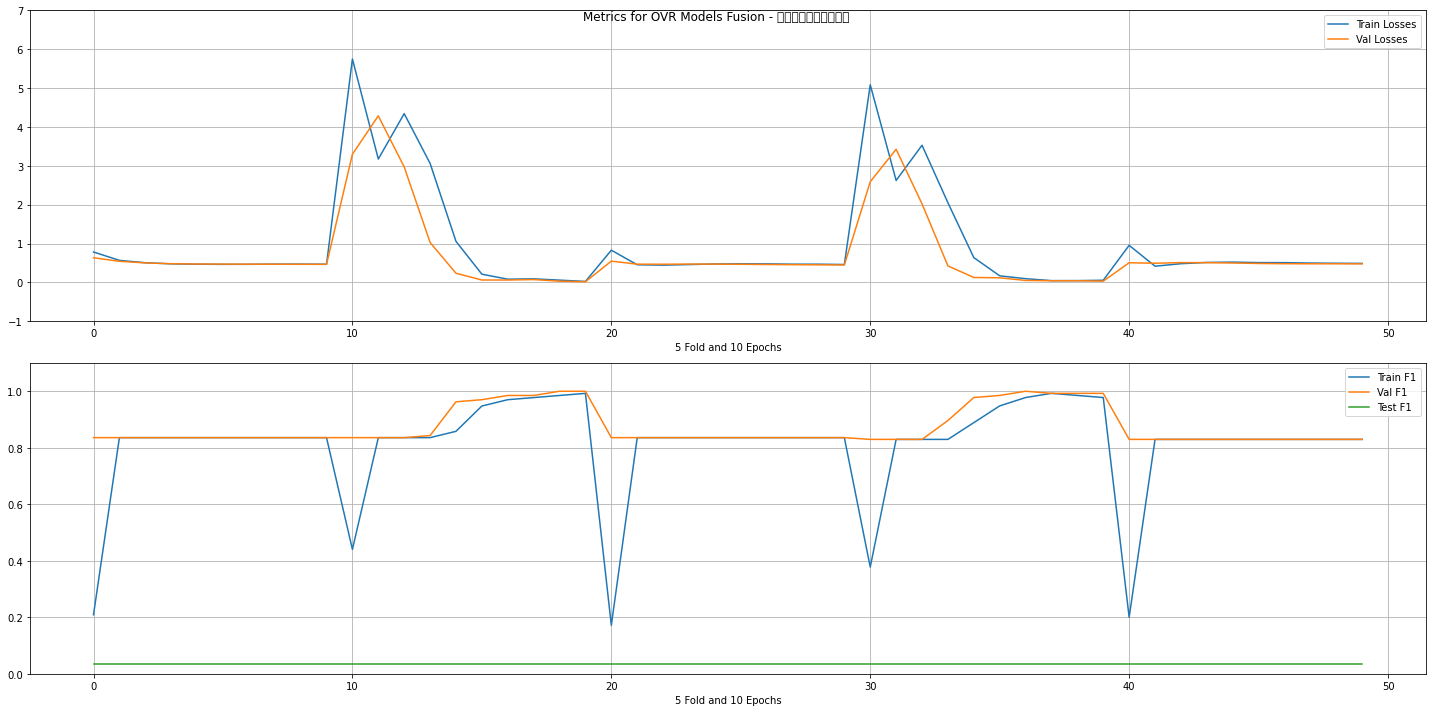

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
9,0.992537,1.000000,0.035088,0.992537,1.000000,0.035088,0.992537,1.000000,0.035088
8,0.985075,1.000000,0.035088,0.985075,1.000000,0.035088,0.985075,1.000000,0.035088
6,0.977778,1.000000,0.035088,0.977778,1.000000,0.035088,0.977778,1.000000,0.035088
7,0.992593,0.992593,0.035088,0.992593,0.992593,0.035088,0.992593,0.992593,0.035088
8,0.985185,0.992593,0.035088,0.985185,0.992593,0.035088,0.985185,0.992593,0.035088
9,0.977778,0.992593,0.035088,0.977778,0.992593,0.035088,0.977778,0.992593,0.035088
5,0.948148,0.985185,0.035088,0.948148,0.985185,0.035088,0.948148,0.985185,0.035088
7,0.977612,0.985075,0.035088,0.977612,0.985075,0.035088,0.977612,0.985075,0.035088
6,0.970149,0.985075,0.035088,0.970149,0.985075,0.035088,0.970149,0.985075,0.035088
4,0.888889,0.977778,0.035088,0.888889,0.977778,0.035088,0.888889,0.977778,0.035088


Training for శ్రీరాగం with 61 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 292/74


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.827 / Validation Loss : 0.642 [Time : 15.355948 seconds]
Epoch 2/10 : Training Loss: 0.588 / Validation Loss : 0.564 [Time : 15.413068 seconds]
Epoch 3/10 : Training Loss: 0.524 / Validation Loss : 0.516 [Time : 15.374598 seconds]
Epoch 4/10 : Training Loss: 0.488 / Validation Loss : 0.490 [Time : 15.441884 seconds]
Epoch 5/10 : Training Loss: 0.478 / Validation Loss : 0.480 [Time : 15.422626 seconds]
Epoch 6/10 : Training Loss: 0.475 / Validation Loss : 0.477 [Time : 15.311443 seconds]
Epoch 7/10 : Training Loss: 0.474 / Validation Loss : 0.475 [Time : 15.373806 seconds]
Epoch 8/10 : Training Loss: 0.474 / Validation Loss : 0.475 [Time : 15.375849 seconds]
Epoch 9/10 : Training Loss: 0.478 / Validation Loss : 0.474 [Time : 15.294656 seconds]
Epoch 10/10 : Training Loss: 0.480 / Validation Loss : 0.474 [Time : 15.369046 seconds]
*** Confusion Matrix - Training ***
[[244   0]
 [ 48   0]]
*** Confusion Matrix - Validation ***
[[244 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 5.653 / Validation Loss : 8.104 [Time : 14.507251 seconds]
Epoch 2/10 : Training Loss: 8.023 / Validation Loss : 4.597 [Time : 14.491533 seconds]
Epoch 3/10 : Training Loss: 4.376 / Validation Loss : 0.217 [Time : 15.291132 seconds]
Epoch 4/10 : Training Loss: 0.869 / Validation Loss : 0.080 [Time : 15.383131 seconds]
Epoch 5/10 : Training Loss: 0.057 / Validation Loss : 0.376 [Time : 14.523752 seconds]
Epoch 6/10 : Training Loss: 0.396 / Validation Loss : 0.060 [Time : 15.378817 seconds]
Epoch 7/10 : Training Loss: 0.068 / Validation Loss : 0.028 [Time : 15.343967 seconds]
Epoch 8/10 : Training Loss: 0.036 / Validation Loss : 0.026 [Time : 15.377725 seconds]
Epoch 9/10 : Training Loss: 0.029 / Validation Loss : 0.021 [Time : 15.356881 seconds]
Epoch 10/10 : Training Loss: 0.024 / Validation Loss : 0.016 [Time : 15.275497 seconds]
*** Confusion Matrix - Training ***
[[244   0]
 [  1  48]]
*** Confusion Matrix - Validation ***
[[244   0]
 [  0  49]]
Fold 2 : 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.884 / Validation Loss : 0.529 [Time : 14.492124 seconds]
Epoch 2/10 : Training Loss: 0.461 / Validation Loss : 0.482 [Time : 14.478171 seconds]
Epoch 3/10 : Training Loss: 0.465 / Validation Loss : 0.482 [Time : 14.514587 seconds]
Epoch 4/10 : Training Loss: 0.485 / Validation Loss : 0.484 [Time : 14.489479 seconds]
Epoch 5/10 : Training Loss: 0.498 / Validation Loss : 0.481 [Time : 14.515826 seconds]
Epoch 6/10 : Training Loss: 0.493 / Validation Loss : 0.479 [Time : 14.621566 seconds]
Epoch 7/10 : Training Loss: 0.495 / Validation Loss : 0.478 [Time : 14.606587 seconds]
Epoch 8/10 : Training Loss: 0.489 / Validation Loss : 0.477 [Time : 14.489889 seconds]
Epoch 9/10 : Training Loss: 0.487 / Validation Loss : 0.476 [Time : 14.554321 seconds]
Epoch 10/10 : Training Loss: 0.485 / Validation Loss : 0.475 [Time : 14.669434 seconds]
*** Confusion Matrix - Training ***
[[244   0]
 [ 49   0]]
*** Confusion Matrix - Validation ***
[[244   0]
 [ 49   0]]
Fold 3 : 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 4.181 / Validation Loss : 6.561 [Time : 14.466019 seconds]
Epoch 2/10 : Training Loss: 6.473 / Validation Loss : 3.356 [Time : 14.483545 seconds]
Epoch 3/10 : Training Loss: 3.275 / Validation Loss : 0.236 [Time : 14.500476 seconds]
Epoch 4/10 : Training Loss: 0.520 / Validation Loss : 0.168 [Time : 14.504398 seconds]
Epoch 5/10 : Training Loss: 0.179 / Validation Loss : 0.373 [Time : 14.531439 seconds]
Epoch 6/10 : Training Loss: 0.382 / Validation Loss : 0.090 [Time : 14.472986 seconds]
Epoch 7/10 : Training Loss: 0.126 / Validation Loss : 0.071 [Time : 14.47398 seconds]
Epoch 8/10 : Training Loss: 0.051 / Validation Loss : 0.058 [Time : 14.465895 seconds]
Epoch 9/10 : Training Loss: 0.059 / Validation Loss : 0.047 [Time : 14.504527 seconds]
Epoch 10/10 : Training Loss: 0.051 / Validation Loss : 0.038 [Time : 14.434912 seconds]
*** Confusion Matrix - Training ***
[[244   0]
 [  3  46]]
*** Confusion Matrix - Validation ***
[[244   0]
 [  3  46]]
Fold 4 : 1

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.975 / Validation Loss : 0.483 [Time : 14.585502 seconds]
Epoch 2/10 : Training Loss: 0.442 / Validation Loss : 0.491 [Time : 14.460868 seconds]
Epoch 3/10 : Training Loss: 0.495 / Validation Loss : 0.495 [Time : 14.496981 seconds]
Epoch 4/10 : Training Loss: 0.509 / Validation Loss : 0.487 [Time : 14.57807 seconds]
Epoch 5/10 : Training Loss: 0.509 / Validation Loss : 0.480 [Time : 14.484812 seconds]
Epoch 6/10 : Training Loss: 0.499 / Validation Loss : 0.478 [Time : 14.486157 seconds]
Epoch 7/10 : Training Loss: 0.491 / Validation Loss : 0.478 [Time : 14.659383 seconds]
Epoch 8/10 : Training Loss: 0.496 / Validation Loss : 0.478 [Time : 14.463109 seconds]
Epoch 9/10 : Training Loss: 0.485 / Validation Loss : 0.479 [Time : 14.527867 seconds]
Epoch 10/10 : Training Loss: 0.494 / Validation Loss : 0.477 [Time : 14.524695 seconds]
*** Confusion Matrix - Training ***
[[244   0]
 [ 49   0]]
*** Confusion Matrix - Validation ***
[[244   0]
 [ 49   0]]
Fold 5 : 1

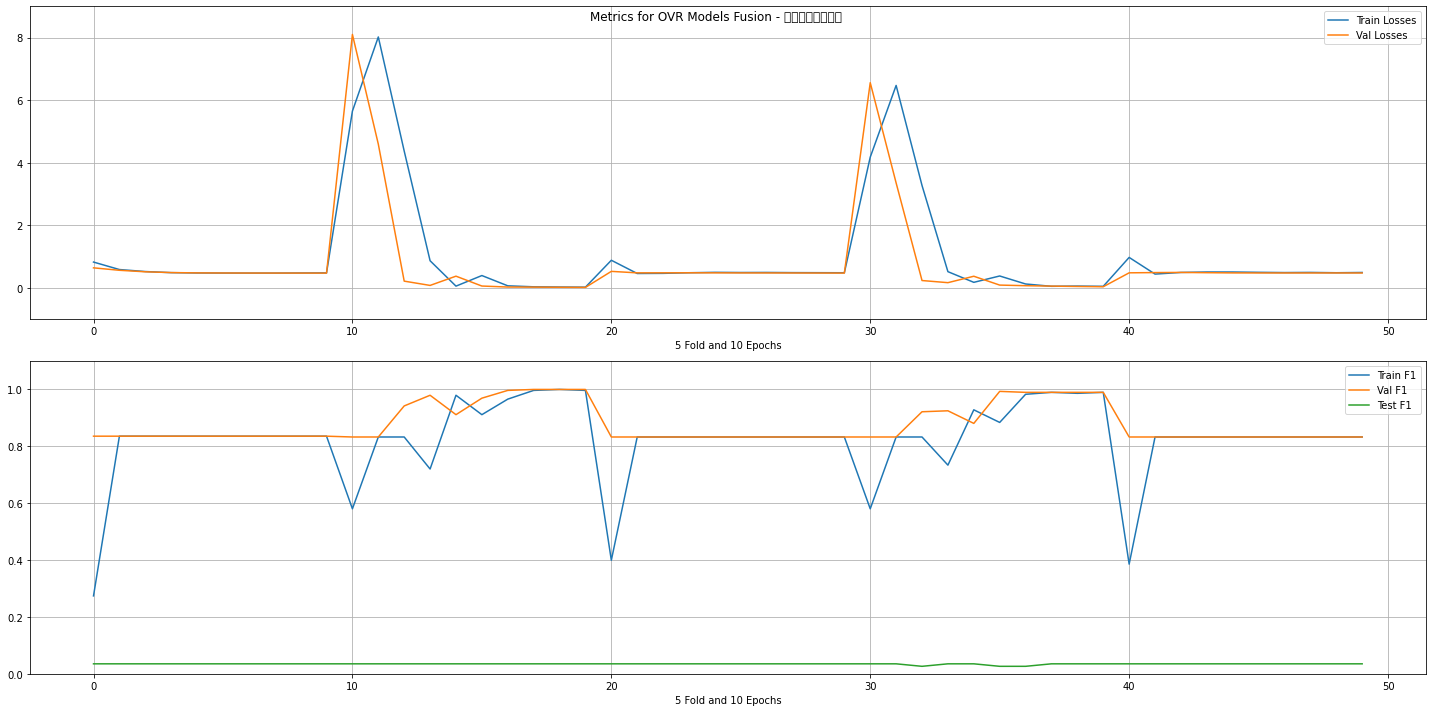

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
8,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
7,0.996587,1.000000,0.035088,0.996587,1.000000,0.035088,0.996587,1.000000,0.035088
9,0.996587,1.000000,0.035088,0.996587,1.000000,0.035088,0.996587,1.000000,0.035088
6,0.965870,0.996587,0.035088,0.965870,0.996587,0.035088,0.965870,0.996587,0.035088
5,0.883959,0.993174,0.026316,0.883959,0.993174,0.026316,0.883959,0.993174,0.026316
7,0.989761,0.989761,0.035088,0.989761,0.989761,0.035088,0.989761,0.989761,0.035088
9,0.989761,0.989761,0.035088,0.989761,0.989761,0.035088,0.989761,0.989761,0.035088
8,0.986348,0.989761,0.035088,0.986348,0.989761,0.035088,0.986348,0.989761,0.035088
6,0.982935,0.989761,0.026316,0.982935,0.989761,0.026316,0.982935,0.989761,0.026316
3,0.720137,0.979522,0.035088,0.720137,0.979522,0.035088,0.720137,0.979522,0.035088


Training for సామంతం with 76 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 364/92


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.808 / Validation Loss : 0.625 [Time : 16.413799 seconds]
Epoch 2/10 : Training Loss: 0.571 / Validation Loss : 0.542 [Time : 16.440009 seconds]
Epoch 3/10 : Training Loss: 0.501 / Validation Loss : 0.490 [Time : 16.444268 seconds]
Epoch 4/10 : Training Loss: 0.464 / Validation Loss : 0.464 [Time : 16.629552 seconds]
Epoch 5/10 : Training Loss: 0.450 / Validation Loss : 0.452 [Time : 16.540657 seconds]
Epoch 6/10 : Training Loss: 0.446 / Validation Loss : 0.447 [Time : 16.440733 seconds]
Epoch 7/10 : Training Loss: 0.444 / Validation Loss : 0.445 [Time : 16.43911 seconds]
Epoch 8/10 : Training Loss: 0.447 / Validation Loss : 0.444 [Time : 16.55023 seconds]
Epoch 9/10 : Training Loss: 0.448 / Validation Loss : 0.444 [Time : 16.524893 seconds]
Epoch 10/10 : Training Loss: 0.446 / Validation Loss : 0.443 [Time : 16.466007 seconds]
*** Confusion Matrix - Training ***
[[304   0]
 [ 60   0]]
*** Confusion Matrix - Validation ***
[[304   

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 8.896 / Validation Loss : 10.844 [Time : 15.606793 seconds]
Epoch 2/10 : Training Loss: 10.667 / Validation Loss : 4.711 [Time : 15.676652 seconds]
Epoch 3/10 : Training Loss: 4.533 / Validation Loss : 0.666 [Time : 15.693246 seconds]
Epoch 4/10 : Training Loss: 0.716 / Validation Loss : 0.225 [Time : 16.456558 seconds]
Epoch 5/10 : Training Loss: 0.243 / Validation Loss : 0.250 [Time : 15.565018 seconds]
Epoch 6/10 : Training Loss: 0.257 / Validation Loss : 0.054 [Time : 16.472198 seconds]
Epoch 7/10 : Training Loss: 0.079 / Validation Loss : 0.047 [Time : 16.4517 seconds]
Epoch 8/10 : Training Loss: 0.040 / Validation Loss : 0.037 [Time : 16.508251 seconds]
Epoch 9/10 : Training Loss: 0.037 / Validation Loss : 0.031 [Time : 16.471272 seconds]
Epoch 10/10 : Training Loss: 0.036 / Validation Loss : 0.026 [Time : 16.525683 seconds]
*** Confusion Matrix - Training ***
[[304   0]
 [  4  57]]
*** Confusion Matrix - Validation ***
[[304   0]
 [  1  60]]
Fold 2 : 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.857 / Validation Loss : 0.513 [Time : 15.583051 seconds]
Epoch 2/10 : Training Loss: 0.445 / Validation Loss : 0.453 [Time : 15.59608 seconds]
Epoch 3/10 : Training Loss: 0.437 / Validation Loss : 0.449 [Time : 15.575792 seconds]
Epoch 4/10 : Training Loss: 0.452 / Validation Loss : 0.450 [Time : 15.615421 seconds]
Epoch 5/10 : Training Loss: 0.460 / Validation Loss : 0.450 [Time : 15.594771 seconds]
Epoch 6/10 : Training Loss: 0.459 / Validation Loss : 0.449 [Time : 15.606676 seconds]
Epoch 7/10 : Training Loss: 0.460 / Validation Loss : 0.448 [Time : 15.60127 seconds]
Epoch 8/10 : Training Loss: 0.458 / Validation Loss : 0.447 [Time : 15.607981 seconds]
Epoch 9/10 : Training Loss: 0.457 / Validation Loss : 0.446 [Time : 15.630658 seconds]
Epoch 10/10 : Training Loss: 0.456 / Validation Loss : 0.445 [Time : 15.642842 seconds]
*** Confusion Matrix - Training ***
[[304   0]
 [ 61   0]]
*** Confusion Matrix - Validation ***
[[304   0]
 [ 61   0]]
Fold 3 : 15

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 5.394 / Validation Loss : 8.439 [Time : 15.606232 seconds]
Epoch 2/10 : Training Loss: 8.312 / Validation Loss : 3.713 [Time : 15.612909 seconds]
Epoch 3/10 : Training Loss: 3.556 / Validation Loss : 0.430 [Time : 15.659046 seconds]
Epoch 4/10 : Training Loss: 0.483 / Validation Loss : 0.281 [Time : 15.587914 seconds]
Epoch 5/10 : Training Loss: 0.328 / Validation Loss : 0.128 [Time : 15.610932 seconds]
Epoch 6/10 : Training Loss: 0.172 / Validation Loss : 0.092 [Time : 15.634099 seconds]
Epoch 7/10 : Training Loss: 0.081 / Validation Loss : 0.068 [Time : 15.592255 seconds]
Epoch 8/10 : Training Loss: 0.065 / Validation Loss : 0.060 [Time : 15.579004 seconds]
Epoch 9/10 : Training Loss: 0.063 / Validation Loss : 0.050 [Time : 15.59194 seconds]
Epoch 10/10 : Training Loss: 0.055 / Validation Loss : 0.043 [Time : 15.605812 seconds]
*** Confusion Matrix - Training ***
[[304   0]
 [  5  56]]
*** Confusion Matrix - Validation ***
[[304   0]
 [  4  57]]
Fold 4 : 1

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.930 / Validation Loss : 0.453 [Time : 15.5878 seconds]
Epoch 2/10 : Training Loss: 0.414 / Validation Loss : 0.453 [Time : 15.621649 seconds]
Epoch 3/10 : Training Loss: 0.456 / Validation Loss : 0.457 [Time : 15.597407 seconds]
Epoch 4/10 : Training Loss: 0.472 / Validation Loss : 0.452 [Time : 15.604136 seconds]
Epoch 5/10 : Training Loss: 0.474 / Validation Loss : 0.447 [Time : 15.631149 seconds]
Epoch 6/10 : Training Loss: 0.463 / Validation Loss : 0.445 [Time : 15.582147 seconds]
Epoch 7/10 : Training Loss: 0.457 / Validation Loss : 0.444 [Time : 15.660859 seconds]
Epoch 8/10 : Training Loss: 0.455 / Validation Loss : 0.443 [Time : 15.617878 seconds]
Epoch 9/10 : Training Loss: 0.455 / Validation Loss : 0.442 [Time : 15.606948 seconds]
Epoch 10/10 : Training Loss: 0.452 / Validation Loss : 0.440 [Time : 15.590271 seconds]
*** Confusion Matrix - Training ***
[[304   0]
 [ 61   0]]
*** Confusion Matrix - Validation ***
[[304   0]
 [ 61   0]]
Fold 5 : 15

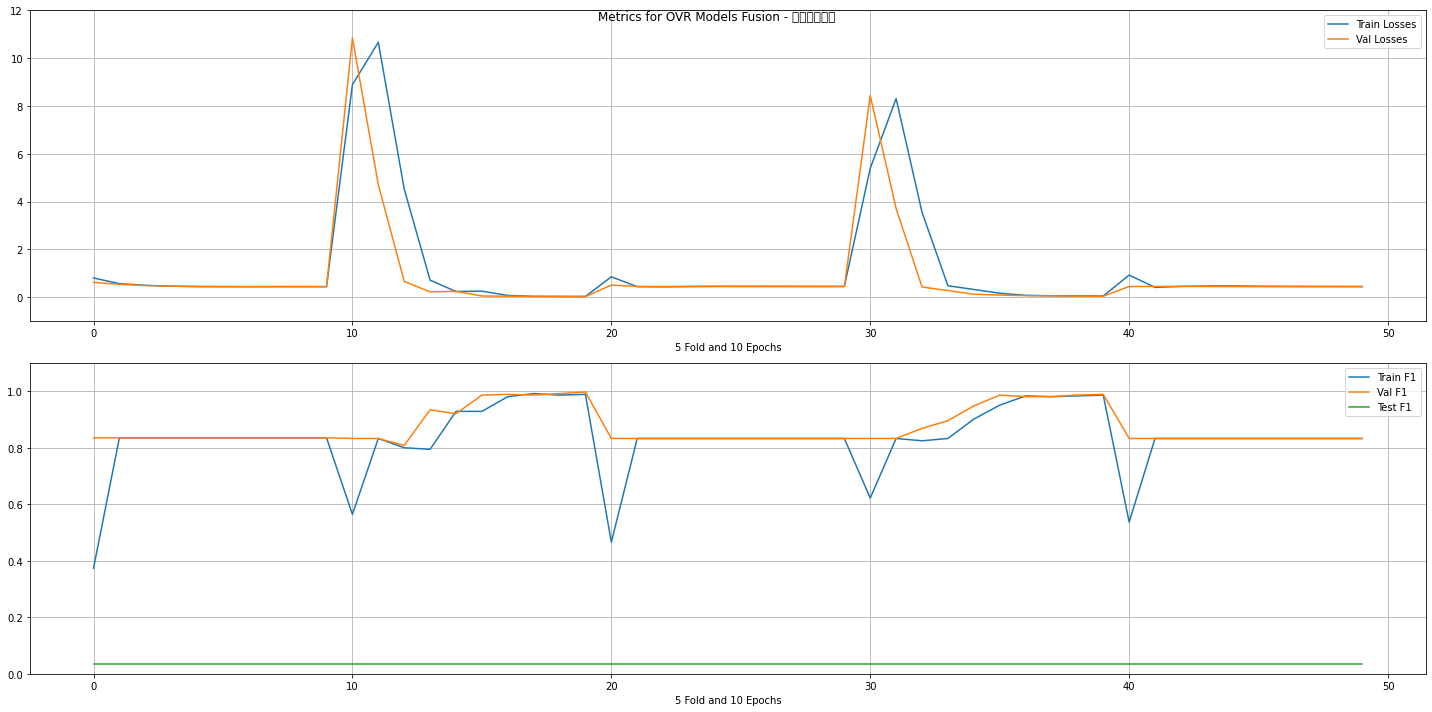

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
9,0.989041,0.997260,0.035088,0.989041,0.997260,0.035088,0.989041,0.997260,0.035088
8,0.986301,0.991781,0.035088,0.986301,0.991781,0.035088,0.986301,0.991781,0.035088
9,0.986301,0.989041,0.035088,0.986301,0.989041,0.035088,0.986301,0.989041,0.035088
6,0.980822,0.989041,0.035088,0.980822,0.989041,0.035088,0.980822,0.989041,0.035088
7,0.991781,0.986301,0.035088,0.991781,0.986301,0.035088,0.991781,0.986301,0.035088
8,0.983562,0.986301,0.035088,0.983562,0.986301,0.035088,0.983562,0.986301,0.035088
5,0.950685,0.986301,0.035088,0.950685,0.986301,0.035088,0.950685,0.986301,0.035088
5,0.928767,0.986301,0.035088,0.928767,0.986301,0.035088,0.928767,0.986301,0.035088
6,0.983562,0.980822,0.035088,0.983562,0.980822,0.035088,0.983562,0.980822,0.035088
7,0.980822,0.980822,0.035088,0.980822,0.980822,0.035088,0.980822,0.980822,0.035088


Training for సాళంగం with 10 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 48/12


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.792 / Validation Loss : 0.725 [Time : 11.482083 seconds]
Epoch 2/10 : Training Loss: 0.692 / Validation Loss : 0.666 [Time : 11.43512 seconds]
Epoch 3/10 : Training Loss: 0.641 / Validation Loss : 0.636 [Time : 11.472055 seconds]
Epoch 4/10 : Training Loss: 0.622 / Validation Loss : 0.625 [Time : 11.459295 seconds]
Epoch 5/10 : Training Loss: 0.615 / Validation Loss : 0.621 [Time : 11.520005 seconds]
Epoch 6/10 : Training Loss: 0.618 / Validation Loss : 0.620 [Time : 11.419989 seconds]
Epoch 7/10 : Training Loss: 0.614 / Validation Loss : 0.620 [Time : 10.579072 seconds]
Epoch 8/10 : Training Loss: 0.621 / Validation Loss : 0.621 [Time : 10.580687 seconds]
Epoch 9/10 : Training Loss: 0.624 / Validation Loss : 0.621 [Time : 10.60763 seconds]
Epoch 10/10 : Training Loss: 0.622 / Validation Loss : 0.621 [Time : 10.564759 seconds]
*** Confusion Matrix - Training ***
[[40  0]
 [ 8  0]]
*** Confusion Matrix - Validation ***
[[40  0]
 [ 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 1.422 / Validation Loss : 0.809 [Time : 10.511998 seconds]
Epoch 2/10 : Training Loss: 0.645 / Validation Loss : 0.046 [Time : 11.550936 seconds]
Epoch 3/10 : Training Loss: 0.121 / Validation Loss : 0.015 [Time : 11.391391 seconds]
Epoch 4/10 : Training Loss: 0.057 / Validation Loss : 0.007 [Time : 11.487071 seconds]
Epoch 5/10 : Training Loss: 0.004 / Validation Loss : 0.004 [Time : 11.541383 seconds]
Epoch 6/10 : Training Loss: 0.004 / Validation Loss : 0.003 [Time : 11.466418 seconds]
Epoch 7/10 : Training Loss: 0.004 / Validation Loss : 0.002 [Time : 11.46675 seconds]
Epoch 8/10 : Training Loss: 0.002 / Validation Loss : 0.001 [Time : 11.422986 seconds]
Epoch 9/10 : Training Loss: 0.002 / Validation Loss : 0.001 [Time : 11.497862 seconds]
Epoch 10/10 : Training Loss: 0.001 / Validation Loss : 0.001 [Time : 11.469354 seconds]
*** Confusion Matrix - Training ***
[[40  0]
 [ 0  8]]
*** Confusion Matrix - Validation ***
[[40  0]
 [ 0  8]]
Fold 2 : 114.66356

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.863 / Validation Loss : 0.728 [Time : 10.542892 seconds]
Epoch 2/10 : Training Loss: 0.663 / Validation Loss : 0.629 [Time : 10.578908 seconds]
Epoch 3/10 : Training Loss: 0.593 / Validation Loss : 0.616 [Time : 10.720556 seconds]
Epoch 4/10 : Training Loss: 0.604 / Validation Loss : 0.624 [Time : 10.747335 seconds]
Epoch 5/10 : Training Loss: 0.625 / Validation Loss : 0.629 [Time : 10.627507 seconds]
Epoch 6/10 : Training Loss: 0.632 / Validation Loss : 0.627 [Time : 10.609972 seconds]
Epoch 7/10 : Training Loss: 0.637 / Validation Loss : 0.620 [Time : 10.552976 seconds]
Epoch 8/10 : Training Loss: 0.627 / Validation Loss : 0.611 [Time : 10.631328 seconds]
Epoch 9/10 : Training Loss: 0.622 / Validation Loss : 0.603 [Time : 10.587984 seconds]
Epoch 10/10 : Training Loss: 0.613 / Validation Loss : 0.598 [Time : 10.590887 seconds]
*** Confusion Matrix - Training ***
[[40  0]
 [ 8  0]]
*** Confusion Matrix - Validation ***
[[40  0]
 [ 8  0]]
Fold 3 : 107.1117

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.611 / Validation Loss : 1.222 [Time : 10.50036 seconds]
Epoch 2/10 : Training Loss: 1.291 / Validation Loss : 0.051 [Time : 10.580232 seconds]
Epoch 3/10 : Training Loss: 0.155 / Validation Loss : 0.061 [Time : 10.580579 seconds]
Epoch 4/10 : Training Loss: 0.057 / Validation Loss : 0.011 [Time : 10.599843 seconds]
Epoch 5/10 : Training Loss: 0.007 / Validation Loss : 0.006 [Time : 10.581825 seconds]
Epoch 6/10 : Training Loss: 0.007 / Validation Loss : 0.006 [Time : 10.633745 seconds]
Epoch 7/10 : Training Loss: 0.006 / Validation Loss : 0.008 [Time : 10.596069 seconds]
Epoch 8/10 : Training Loss: 0.008 / Validation Loss : 0.008 [Time : 10.581022 seconds]
Epoch 9/10 : Training Loss: 0.009 / Validation Loss : 0.007 [Time : 10.689257 seconds]
Epoch 10/10 : Training Loss: 0.006 / Validation Loss : 0.005 [Time : 10.563097 seconds]
*** Confusion Matrix - Training ***
[[40  0]
 [ 0  8]]
*** Confusion Matrix - Validation ***
[[40  0]
 [ 0  8]]
Fold 4 : 106.75862

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 1.076 / Validation Loss : 0.802 [Time : 10.491403 seconds]
Epoch 2/10 : Training Loss: 0.660 / Validation Loss : 0.620 [Time : 10.766363 seconds]
Epoch 3/10 : Training Loss: 0.575 / Validation Loss : 0.649 [Time : 10.580883 seconds]
Epoch 4/10 : Training Loss: 0.636 / Validation Loss : 0.679 [Time : 10.597687 seconds]
Epoch 5/10 : Training Loss: 0.685 / Validation Loss : 0.682 [Time : 10.56696 seconds]
Epoch 6/10 : Training Loss: 0.693 / Validation Loss : 0.666 [Time : 10.57881 seconds]
Epoch 7/10 : Training Loss: 0.683 / Validation Loss : 0.645 [Time : 10.580356 seconds]
Epoch 8/10 : Training Loss: 0.664 / Validation Loss : 0.627 [Time : 10.579016 seconds]
Epoch 9/10 : Training Loss: 0.653 / Validation Loss : 0.618 [Time : 10.573229 seconds]
Epoch 10/10 : Training Loss: 0.633 / Validation Loss : 0.617 [Time : 10.593395 seconds]
*** Confusion Matrix - Training ***
[[40  0]
 [ 8  0]]
*** Confusion Matrix - Validation ***
[[40  0]
 [ 8  0]]
Fold 5 : 106.751628

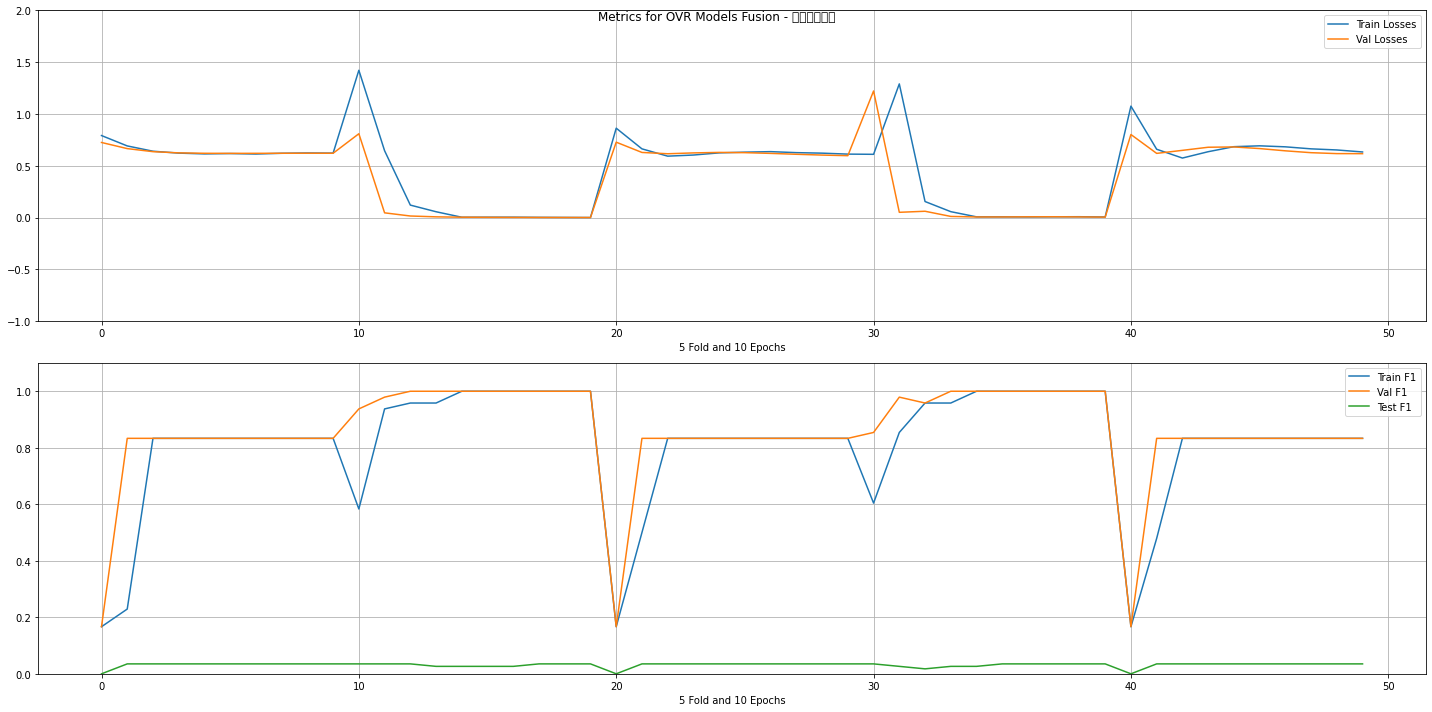

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
4,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
5,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
6,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
7,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
8,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
9,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
4,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316,1.000000,1.000000,0.026316
5,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
6,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088
7,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088,1.000000,1.000000,0.035088


Training for సాళంగనాట with 87 positive samples
FOLD 1 
 Data Sizes (Train/Validation) : 417/105


Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Class Weights : [0.6 3. ]
Epoch 1/10 : Training Loss: 0.825 / Validation Loss : 0.647 [Time : 17.387981 seconds]
Epoch 2/10 : Training Loss: 0.603 / Validation Loss : 0.575 [Time : 17.452799 seconds]
Epoch 3/10 : Training Loss: 0.535 / Validation Loss : 0.519 [Time : 17.379483 seconds]
Epoch 4/10 : Training Loss: 0.491 / Validation Loss : 0.489 [Time : 17.39749 seconds]
Epoch 5/10 : Training Loss: 0.472 / Validation Loss : 0.473 [Time : 17.347692 seconds]
Epoch 6/10 : Training Loss: 0.464 / Validation Loss : 0.467 [Time : 17.305301 seconds]
Epoch 7/10 : Training Loss: 0.465 / Validation Loss : 0.463 [Time : 17.480233 seconds]
Epoch 8/10 : Training Loss: 0.463 / Validation Loss : 0.461 [Time : 17.410273 seconds]
Epoch 9/10 : Training Loss: 0.465 / Validation Loss : 0.460 [Time : 17.470375 seconds]
Epoch 10/10 : Training Loss: 0.462 / Validation Loss : 0.459 [Time : 17.393132 seconds]
*** Confusion Matrix - Training ***
[[348   0]
 [ 69   0]]
*** Confusion Matrix - Validation ***
[[348  

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 6.644 / Validation Loss : 10.866 [Time : 16.463664 seconds]
Epoch 2/10 : Training Loss: 10.689 / Validation Loss : 3.814 [Time : 16.44953 seconds]
Epoch 3/10 : Training Loss: 3.691 / Validation Loss : 0.296 [Time : 17.290373 seconds]
Epoch 4/10 : Training Loss: 0.208 / Validation Loss : 0.177 [Time : 17.283594 seconds]
Epoch 5/10 : Training Loss: 0.224 / Validation Loss : 0.079 [Time : 17.331484 seconds]
Epoch 6/10 : Training Loss: 0.082 / Validation Loss : 0.061 [Time : 17.387498 seconds]
Epoch 7/10 : Training Loss: 0.072 / Validation Loss : 0.049 [Time : 17.348852 seconds]
Epoch 8/10 : Training Loss: 0.052 / Validation Loss : 0.041 [Time : 17.335734 seconds]
Epoch 9/10 : Training Loss: 0.048 / Validation Loss : 0.035 [Time : 17.38586 seconds]
Epoch 10/10 : Training Loss: 0.042 / Validation Loss : 0.031 [Time : 17.55238 seconds]
*** Confusion Matrix - Training ***
[[348   0]
 [  5  64]]
*** Confusion Matrix - Validation ***
[[348   0]
 [  4  65]]
Fold 2 : 1

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.867 / Validation Loss : 0.538 [Time : 16.641056 seconds]
Epoch 2/10 : Training Loss: 0.477 / Validation Loss : 0.481 [Time : 16.460363 seconds]
Epoch 3/10 : Training Loss: 0.465 / Validation Loss : 0.473 [Time : 16.583005 seconds]
Epoch 4/10 : Training Loss: 0.475 / Validation Loss : 0.473 [Time : 16.501718 seconds]
Epoch 5/10 : Training Loss: 0.476 / Validation Loss : 0.472 [Time : 16.517977 seconds]
Epoch 6/10 : Training Loss: 0.486 / Validation Loss : 0.473 [Time : 16.502482 seconds]
Epoch 7/10 : Training Loss: 0.487 / Validation Loss : 0.471 [Time : 16.556261 seconds]
Epoch 8/10 : Training Loss: 0.481 / Validation Loss : 0.471 [Time : 16.501642 seconds]
Epoch 9/10 : Training Loss: 0.485 / Validation Loss : 0.470 [Time : 16.516304 seconds]
Epoch 10/10 : Training Loss: 0.483 / Validation Loss : 0.469 [Time : 16.477104 seconds]
*** Confusion Matrix - Training ***
[[348   0]
 [ 70   0]]
*** Confusion Matrix - Validation ***
[[348   0]
 [ 70   0]]
Fold 3 : 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 5.047 / Validation Loss : 8.222 [Time : 16.494827 seconds]
Epoch 2/10 : Training Loss: 8.095 / Validation Loss : 3.688 [Time : 16.489012 seconds]
Epoch 3/10 : Training Loss: 3.470 / Validation Loss : 0.317 [Time : 16.464668 seconds]
Epoch 4/10 : Training Loss: 0.570 / Validation Loss : 0.206 [Time : 16.494595 seconds]
Epoch 5/10 : Training Loss: 0.212 / Validation Loss : 0.193 [Time : 16.509198 seconds]
Epoch 6/10 : Training Loss: 0.217 / Validation Loss : 0.124 [Time : 16.515594 seconds]
Epoch 7/10 : Training Loss: 0.127 / Validation Loss : 0.102 [Time : 16.577085 seconds]
Epoch 8/10 : Training Loss: 0.108 / Validation Loss : 0.087 [Time : 16.495864 seconds]
Epoch 9/10 : Training Loss: 0.098 / Validation Loss : 0.075 [Time : 16.552202 seconds]
Epoch 10/10 : Training Loss: 0.080 / Validation Loss : 0.065 [Time : 16.456524 seconds]
*** Confusion Matrix - Training ***
[[348   0]
 [ 10  60]]
*** Confusion Matrix - Validation ***
[[348   0]
 [  7  63]]
Fold 4 : 

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1/10 : Training Loss: 0.895 / Validation Loss : 0.473 [Time : 16.573463 seconds]
Epoch 2/10 : Training Loss: 0.451 / Validation Loss : 0.484 [Time : 16.472784 seconds]
Epoch 3/10 : Training Loss: 0.496 / Validation Loss : 0.483 [Time : 16.51036 seconds]
Epoch 4/10 : Training Loss: 0.507 / Validation Loss : 0.475 [Time : 16.477848 seconds]
Epoch 5/10 : Training Loss: 0.499 / Validation Loss : 0.473 [Time : 16.501156 seconds]
Epoch 6/10 : Training Loss: 0.493 / Validation Loss : 0.472 [Time : 16.489605 seconds]
Epoch 7/10 : Training Loss: 0.493 / Validation Loss : 0.472 [Time : 16.536995 seconds]
Epoch 8/10 : Training Loss: 0.488 / Validation Loss : 0.472 [Time : 16.513058 seconds]
Epoch 9/10 : Training Loss: 0.492 / Validation Loss : 0.471 [Time : 16.486081 seconds]
Epoch 10/10 : Training Loss: 0.489 / Validation Loss : 0.471 [Time : 16.516889 seconds]
*** Confusion Matrix - Training ***
[[348   0]
 [ 70   0]]
*** Confusion Matrix - Validation ***
[[348   0]
 [ 70   0]]
Fold 5 : 1

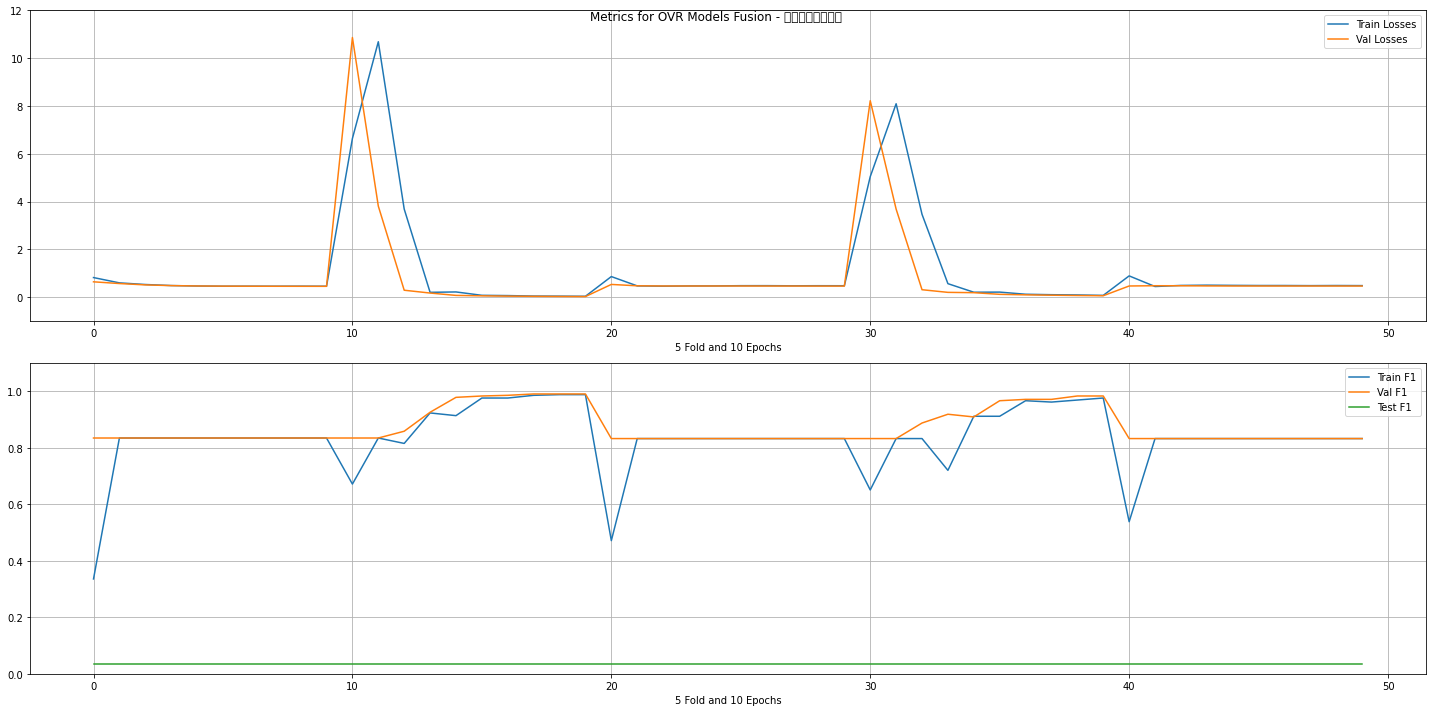

,train_f1,validation_f1,test_f1,train_precision,validation_precision,test_precision,train_recall,validation_recall,test_recall
8,0.988010,0.990408,0.035088,0.988010,0.990408,0.035088,0.988010,0.990408,0.035088
9,0.988010,0.990408,0.035088,0.988010,0.990408,0.035088,0.988010,0.990408,0.035088
7,0.985612,0.990408,0.035088,0.985612,0.990408,0.035088,0.985612,0.990408,0.035088
6,0.976019,0.985612,0.035088,0.976019,0.985612,0.035088,0.976019,0.985612,0.035088
9,0.976077,0.983254,0.035088,0.976077,0.983254,0.035088,0.976077,0.983254,0.035088
8,0.968900,0.983254,0.035088,0.968900,0.983254,0.035088,0.968900,0.983254,0.035088
5,0.976019,0.983213,0.035088,0.976019,0.983213,0.035088,0.976019,0.983213,0.035088
4,0.913669,0.978417,0.035088,0.913669,0.978417,0.035088,0.913669,0.978417,0.035088
6,0.966507,0.971292,0.035088,0.966507,0.971292,0.035088,0.966507,0.971292,0.035088
7,0.961722,0.971292,0.035088,0.961722,0.971292,0.035088,0.961722,0.971292,0.035088


In [24]:
le = LabelEncoder()
le.fit(data['Ragam'])
labels = le.transform(le.classes_)
sequences, attention_masks = get_seq_masks('ai4bharat/indic-bert',txt)
ovr_res, models = ovr_train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/IndicBERT_FineTuned',
                                  gpu, 'ai4bharat/indic-bert', 'OVR Models Fusion', labels, le.classes_,
                                  lbl_encoder=le, lr=1e-5, epochs=10, n_folds=5, feature='mel_spec',nindex_factor=5)

In [25]:
indic_df = create_results_table(ovr_res, le, n_results=1)

,Raga,train_confusion,validation_confusion,train_f1,validation_f1,train_precision,validation_precision,train_recall,validation_recall
Raga,,,,,,,,,
ఆహిరి,ఆహిరి,[164 0][ 4 29],[164 0][ 1 32],0.979695,0.994924,0.979695,0.994924,0.979695,0.994924
కన్నడగౌళ,కన్నడగౌళ,[60 0][ 0 12],[60 0][ 0 12],1,1,1,1,1,1
కాంబోది,కాంబోది,[68 0][ 0 14],[68 0][ 0 14],1,1,1,1,1,1
గుండుక్రియ,గుండుక్రియ,[100 0][ 0 20],[100 0][ 0 20],1,1,1,1,1,1
గుజ్జరి,గుజ్జరి,[52 0][ 0 10],[52 0][ 0 10],1,1,1,1,1,1
గౌళ,గౌళ,[44 0][0 9],[44 0][0 9],1,1,1,1,1,1
దేవగాంధారి,దేవగాంధారి,[120 0][ 0 24],[120 0][ 1 23],1,0.993056,1,0.993056,1,0.993056
దేసాక్షి,దేసాక్షి,[100 0][ 0 20],[100 0][ 0 20],1,1,1,1,1,1
దేసాళం,దేసాళం,[144 0][ 2 27],[144 0][ 0 29],0.988439,1,0.988439,1,0.988439,1


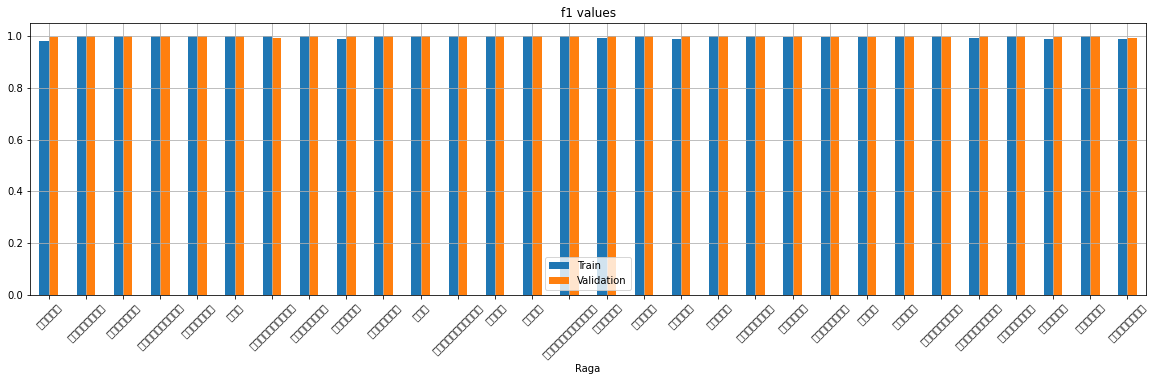

In [30]:
bar_plot(indic_df,'f1')

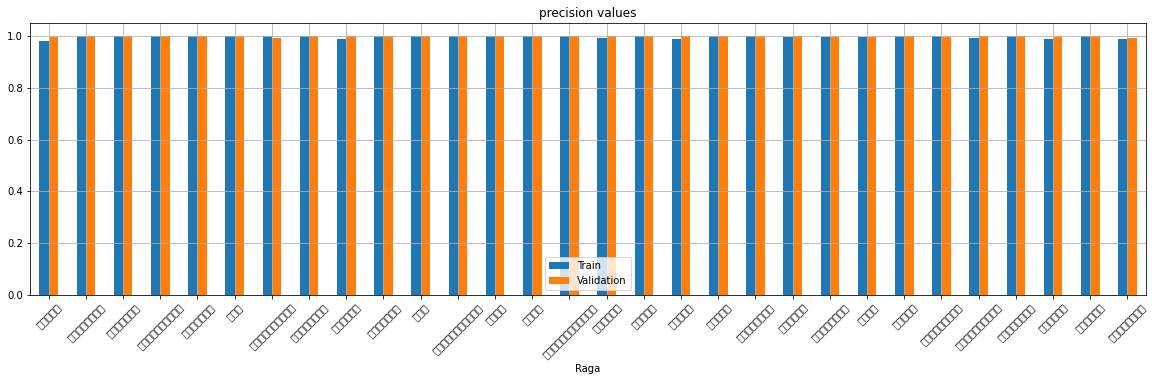

In [27]:
bar_plot(indic_df,'precision')

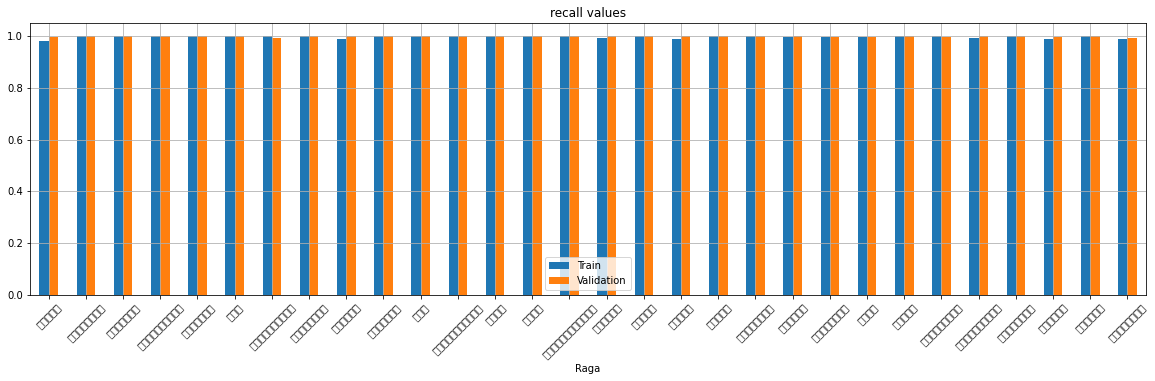

In [28]:
bar_plot(indic_df,'recall')

In [ ]:
predict_ovr(models,test_data,'/content/drive/MyDrive/IndicBERT_FineTuned','ai4bharat/indic-bert',feature='mel_spec')

Some weights of the model checkpoint at /content/drive/MyDrive/IndicBERT_FineTuned/pytorch_model.bin were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# MURIL Fusion

In [ ]:
sequences, attention_masks = get_seq_masks('google/muril-base-cased',txt)
ovr_muril_result, models = ovr_train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/MURIL_FineTuned',
                                gpu, 'google/muril-base-cased', 'OVR Models Fusion', labels, le.classes_,
                                  lbl_encoder=le, lr=1e-5, epochs=10, n_folds=5, 
                                  feature='mel_spec',nindex_factor=5,  mdlargs={'n_labels':n_labels})

In [ ]:
muril_df = create_results_table(ovr_muril_result, le, n_results=1)

In [ ]:
bar_plot(muril_df,'f1')

In [ ]:
bar_plot(muril_df,'precision')

In [ ]:
bar_plot(muril_df,'recall')

In [ ]:
predict_ovr(models,test_data,feature='mel_spec')

# XLM-R Fusion

In [ ]:
sequences, attention_masks = get_seq_masks('xlm-roberta-base',txt)
ovr_xlmr_result, models = ovr_train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/XLMR_Finetuned',
                                gpu, 'xlm-roberta-base', 'OVR Models Fusion', labels, le.classes_,
                                  lbl_encoder=le, lr=1e-5, epochs=10, n_folds=5, 
                                  feature='mel_spec',nindex_factor=5,  mdlargs={'n_labels':n_labels})

In [ ]:
xlmr_df = create_results_table(ovr_xlmr_result, le, n_results=1)

In [ ]:
bar_plot(xlmr_df,'f1')

In [ ]:
bar_plot(xlmr_df,'precision')

In [ ]:
bar_plot(xlmr_df,'recall')

In [ ]:
predict_ovr(models,test_data,feature='mel_spec')

# MBERT Fusion

In [ ]:
sequences, attention_masks = get_seq_masks('bert-base-multilingual-cased',txt)
ovr_mbert_result, models = ovr_train_model(data, test_data, sequences, attention_masks, '/content/drive/MyDrive/MBERT_Finetuned',
                                gpu, 'bert-base-multilingual-cased', 'OVR Models Fusion', labels, le.classes_,
                                  lbl_encoder=le, lr=1e-5, epochs=10, n_folds=5, 
                                  feature='mel_spec',nindex_factor=5,  mdlargs={'n_labels':n_labels})

In [ ]:
mbert_df = create_results_table(ovr_mbert_result, le, n_results=1)

In [ ]:
bar_plot(mbert_df,'f1')

In [ ]:
bar_plot(mbert_df,'precision')

In [ ]:
bar_plot(mbert_df,'recall')

In [ ]:
predict_ovr(models,test_data,feature='mel_spec')